# Packages

#### Libraries

In [582]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.options.display.float_format = "{:,.2f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast
from ydata_profiling import ProfileReport

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
import random

# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

#### Functions

In [583]:
def get_connections(df, max_level=3, col_name='connections'):

    G = nx.Graph()
    edges = list(zip(df["user_id_from"], df["user_id_to"]))
    G.add_edges_from(edges)

    connections_data = []

    for user in tqdm(G.nodes):
        user_connections = defaultdict(set)

        levels = {user: 0}
        queue = [(user, 0)]
        visited = set([user])

        while queue:
            current, level = queue.pop(0)

            if level >= max_level:
                continue

            for neighbor in G.neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    levels[neighbor] = level + 1
                    queue.append((neighbor, level + 1))
                    user_connections[level + 1].add(neighbor)

        sorted_connections = tuple(sorted(user_connections[lvl]) for lvl in sorted(user_connections))
        connections_data.append((user, sorted_connections))

    return pd.DataFrame(connections_data, columns=["user_id_from", col_name])

def level_depth(row):
    return len(row)

def number_connections(row):
    connections = 0
    for i in row:
        connections += len(i)

    return connections

def number_of_1st_connections(row):
        if len(row) > 0:
            return len(row[0])
        else:
            return 0 

def number_of_2nd_connections(row):
        if len(row) > 1:
            return len(row[1])
        else:
            return 0  

def number_of_3rd_connections(row):
        if len(row) > 2:
            return len(row[2])
        else:
            return 0 

# Pulling the data

## Plan
### My goal is to asnwer the question: Can we ban the users with connections and if yes, so how to implement and how many false positive cases?
#### Analysis by 3 types (Liveness / device / liveness+device) + Incident levels
- All the users with connections at all (Up to 3-4 levels)?
- How many of them who's already got an incident(s) in connected accounts?
- But how many with bans in connected
- Get a percentage compared to total numbers for the every comparing
- Choose the key countries

In [3]:
df_banned_users = read_bq("""
SELECT user_id,
       start_dttm,
       end_dttm
FROM dwh-storage-327422.ods_expel.tbl_ban
WHERE unban_applied_cd = 0
  AND DATE_DIFF(DATE(end_dttm), DATE(start_dttm), YEAR) >= 1
  AND DATE(end_dttm) >= DATE_ADD(CURRENT_DATE(), INTERVAL + 2 MONTH)
QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY end_dttm DESC) = 1
""")

df_all_incidents = read_bq("""
SELECT redmine_id,
       aggressor_mode,
       aggressor_id,
       city_id,
       city_name,
       incident_date,
       incident_type,
       information_status,
       MAX(incident_level_digit) AS incident_level_digit,
FROM (SELECT redmine_id,
             'driver'  AS aggressor_mode,
             driver_id AS aggressor_id,
             city_id,
             city_name,
             incident_date,
             incident_type,
             incident_level,
             information_status,
             CASE
                 WHEN incident_level = 'Green' THEN 1
                 WHEN incident_level = 'Yellow' THEN 2
                 WHEN incident_level = 'Red' THEN 3
                 ELSE 0
                 END      incident_level_digit
      FROM indriver-bi.safety.vw_safety_incidents_detail
      WHERE aggressor = 'Driver'
        AND information_status = 'Confirmed'
      UNION
      DISTINCT
      SELECT redmine_id,
             'pax'   AS aggressor_mode,
             pass_id AS aggressor_id,
             city_id,
             city_name,
             incident_date,
             incident_type,
             incident_level,
             information_status,
             CASE
                 WHEN incident_level = 'Green' THEN 1
                 WHEN incident_level = 'Yellow' THEN 2
                 WHEN incident_level = 'Red' THEN 3
                 ELSE 0
                 END    incident_level_digit
      FROM indriver-bi.safety.vw_safety_incidents_detail
      WHERE aggressor = 'Passenger'
        AND information_status = 'Confirmed')
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8                        
""")

df_all_incidents['incident_date'] = pd.to_datetime(df_all_incidents['incident_date'])

In [4]:
df_all_types_together = read_bq("""
WITH cte AS (SELECT t1.user_id_from,
                    t3.mode,
                    t1.user_id_to,
                    t1.connection_type,
                    t2.connection_type               AS connection_type_2,
                    CASE
                        WHEN (t1.connection_type = 'device' OR t1.connection_type = 'liveness') AND
                             (t2.connection_type = 'device' OR t2.connection_type = 'liveness') THEN 'Device, Liveness'
                        ELSE t1.connection_type
                        END                             connection_filled_type,
                    COALESCE(t1.confidence_level, 1) AS confidence_level_1,
                    COALESCE(t2.confidence_level, 1) AS confidence_level_2
             FROM indriver-e6e40.ods_user_connections.user_connections t1
                      LEFT JOIN indriver-e6e40.ods_user_connections.user_connections t2
                                ON t1.user_id_from = t2.user_id_from AND t1.user_id_to = t2.user_id_to AND
                                   t1.connection_type != t2.connection_type
                      JOIN (SELECT id, created, mode
                            FROM indriver-e6e40.ods_monolith.tbl_user) t3
                           ON t1.user_id_from = t3.id
             WHERE mode IS NOT NULL)
SELECT *, ROUND(((users / SUM(users) OVER (PARTITION BY connection_filled_type, mode)) * 100), 2) AS share
FROM (SELECT connection_filled_type,
             mode,
             CASE
                 WHEN connection_type_2 IN ('liveness', 'device') AND connection_type IN ('liveness', 'device')
                     THEN ROUND(((confidence_level_1 + confidence_level_2) / 2) * 100, 0)
                 WHEN connection_type IN ('liveness', 'device') AND connection_type_2 IS NULL
                     THEN ROUND(confidence_level_1 * 100, 0)
                 ELSE NULL
                 END                         total_conf_level,
             COUNT(DISTINCT user_id_from) AS users
      FROM cte
      GROUP BY 1, 2, 3)
""")

df_all_types_together.head()

,connection_filled_type,mode,total_conf_level,users,share
0,device,client,100.00,5376044,100.00
1,"Device, Liveness",driver,99.00,14,0.60
2,"Device, Liveness",driver,97.00,2,0.09
3,"Device, Liveness",driver,95.00,2,0.09
4,"Device, Liveness",driver,98.00,6,0.26


In [5]:
df_user_par = read_bq("""
WITH user AS (SELECT id,
                     DATE(created)                                 AS created,
                     DATE_DIFF(CURRENT_DATE(), DATE(created), DAY) AS lifetime,
                     t2.country_name,
                     t2.city_name,
                     mode
              FROM indriver-e6e40.ods_monolith.tbl_user t1
                       JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                            ON
                                t1.city_id = t2.city_id
              WHERE DATE(created) >= '2024-01-01'),
     rides AS (SELECT user_id,
                      MAX(CASE WHEN rides_count > 0 THEN 1 ELSE 0 END) AS has_ride,
                      SUM(rides_count)                                 AS rides,
                      SUM(orders_count)                                AS orders,
                      SUM(gmv_clean_usd)                               AS gmv
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
               WHERE metric_date_utc >= '2024-01-01'
               GROUP BY 1)
SELECT t1.id                    AS user_id,
       t1.created,
       t1.country_name,
       t1.city_name,
       t1.mode,
       COALESCE(t2.has_ride, 0) AS has_ride,
       COALESCE(t2.rides, 0)    AS rides,
       COALESCE(t2.orders, 0)   AS orders,
       COALESCE(t2.gmv, 0)      AS gmv,
       CASE
           WHEN COALESCE(t2.rides, 0) BETWEEN 1 AND 10 THEN '1-10'
           WHEN COALESCE(t2.rides, 0) BETWEEN 11 AND 30 THEN '10-30'
           WHEN COALESCE(t2.rides, 0) BETWEEN 31 AND 100 THEN '30-100'
           WHEN COALESCE(t2.rides, 0) BETWEEN 101 AND 500 THEN '100-500'
           WHEN COALESCE(t2.rides, 0) >= 501 THEN '>501'
           WHEN COALESCE(t2.rides, 0) = 0 THEN '0'
           ELSE NULL
           END                     rides_bucket,
       CASE
           WHEN COALESCE(t2.gmv, 0) BETWEEN 1 AND 100 THEN '1-10'
           WHEN COALESCE(t2.gmv, 0) BETWEEN 101 AND 300 THEN '100-300'
           WHEN COALESCE(t2.gmv, 0) BETWEEN 301 AND 1000 THEN '300-1000'
           WHEN COALESCE(t2.gmv, 0) BETWEEN 1001 AND 5000 THEN '100-5000'
           WHEN COALESCE(t2.gmv, 0) >= 5001 THEN '>5001'
           WHEN COALESCE(t2.gmv, 0) = 0 THEN '0'
           ELSE NULL
           END                     rides_bucket

FROM user t1
         LEFT JOIN rides t2 ON t1.id = t2.user_id
""")
df_user_par.to_csv('user_data.csv')
df_user_par = df_user_par.rename(columns={'rides_bucket_1':'gmv_bucket'})
df_user_par.head()

KeyboardInterrupt: 

In [6]:
df_connections = read_bq("""
    SELECT user_id_from,
        user_id_to,
        connection_type,
        COALESCE(confidence_level, 1)                 AS confidence_level,
        ROUND(COALESCE(confidence_level, 1) * 100, 0) AS confidence_level_group
    FROM indriver-e6e40.ods_user_connections.user_connections
    WHERE confidence_level >= 0.98
""")

df_connections.head()

,user_id_from,user_id_to,connection_type,confidence_level,confidence_level_group
0,8969194,41293769,device,1.00,100.00
1,8969194,103629962,device,1.00,100.00
2,8969194,120017427,device,1.00,100.00
3,8969194,126523858,device,1.00,100.00
4,8969194,19914929,device,1.00,100.00


In [321]:
df_connections['confidence_level_group'].value_counts()

confidence_level_group
100.00    7396305
99.00       31381
98.00       27647
Name: count, dtype: int64

In [7]:
df_user_par = pd.read_csv('user_data.csv')
df_user_par

,Unnamed: 0,user_id,created,country_name,city_name,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1
0,0,231443617,2024-05-03,India,Kolkata,client,0,0,1,0.00,0,0
1,1,231512935,2024-05-04,Chile,Iquique y Alto Hospicio,client,1,2,4,4.43,1-10,1-10
2,2,231516006,2024-05-04,Brazil,Boa Vista,client,0,0,0,0.00,0,0
3,3,231487371,2024-05-03,USA,New York City,client,0,0,1,0.00,0,0
4,4,231486565,2024-05-03,Mexico,Morelia,client,0,0,0,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69553129,69553129,278831396,2025-01-31,Brazil,São Paulo,client,0,0,0,0.00,0,0
69553130,69553130,278962273,2025-02-01,Peru,Lima,client,1,2,4,4.79,1-10,1-10
69553131,69553131,279011937,2025-02-01,Morocco,Rabat (الرباط),client,0,0,3,0.00,0,0
69553132,69553132,278985605,2025-02-01,Morocco,Casablanca (الدار البيضاء),driver,0,0,0,0.00,0,0


In [324]:
df_connections[(df_connections['connection_type']=='liveness') & (df_connections['confidence_level']>=0.99)]['confidence_level_group'].value_counts()

confidence_level_group
100.00    1181630
99.00       14753
Name: count, dtype: int64

In [8]:
# df_device_connected = get_connections(df_connections[df_connections['connection_type']=='device'], col_name='device_conn')
# df_liveness_connected = get_connections(df_connections[df_connections['connection_type']=='liveness'], col_name='liveness_conn')
# df_total_connected = get_connections(df_connections, col_name='all_types_conn')
df_liveness_connected_99 = get_connections(df_connections[(df_connections['connection_type']=='liveness') & (df_connections['confidence_level']>=0.99)], col_name='liveness_conn')


# df_two_types_connected = df_device_connected.merge(df_liveness_connected, how='inner', left_on='user_id_from', right_on='user_id_from')
# df_all_types_connected = df_two_types_connected.merge(df_total_connected, how='inner', left_on='user_id_from', right_on='user_id_from')

# df_all_types_connected.head()

  0%|          | 0/1113068 [00:00<?, ?it/s]

In [9]:
df_liveness_connected_99.head(15)

,user_id_from,liveness_conn
0,105880078,"([68464945, 286984050],)"
1,286984050,"([68464945, 105880078],)"
2,198855292,"([235306259],)"
3,235306259,"([198855292],)"
4,274843700,"([288038371],)"
5,288038371,"([274843700],)"
6,62703570,"([64454250, 162468319, 237169161],)"
7,237169161,"([62703570, 64454250, 162468319],)"
8,244863967,"([211940908, 287290053],)"
9,287290053,"([211940908, 244863967],)"


# Research

Ответить на вопросы:
- Какой % по фоткам лучше всего определяет инциденты
- Как мы можем оценивать по фоткам и девайсам вместе
- Сколько повторных инцидентов от общего кол-ва можем сократить (И по фоткам, и по девайсам), если забаним всех до 3 уровня


##### Liveness & Device in percentage

In [27]:
df_all_types_together.query("total_conf_level >= 90").pivot_table(columns='connection_filled_type', index='total_conf_level', values='share', aggfunc='max').fillna('-')

connection_filled_type,"Device, Liveness",device,liveness
total_conf_level,,,
90.00,-,-,16.37
91.00,-,-,23.23
92.00,-,-,18.34
93.00,-,-,13.86
94.00,-,-,9.91
95.00,0.03,-,6.24
96.00,0.09,-,3.67
97.00,0.05,-,1.94
98.00,0.17,-,0.80


#### Liveness

##### Group with all % significance 

In [159]:
df_liveness_connected['level_depth'] = df_liveness_connected['liveness_conn'].apply(level_depth)
df_liveness_connected['number_connections'] = df_liveness_connected['liveness_conn'].apply(number_connections)
df_liveness_connected['number_connections_1lvl'] = df_liveness_connected['liveness_conn'].apply(number_of_1st_connections)
df_liveness_connected['number_connections_2lvl'] = df_liveness_connected['liveness_conn'].apply(number_of_2nd_connections)
df_liveness_connected['number_connections_3lvl'] = df_liveness_connected['liveness_conn'].apply(number_of_3rd_connections)

df_liveness_connected_merged = df_liveness_connected.merge(df_user_par, how='inner', left_on='user_id_from', right_on='user_id')


In [375]:
city = df_liveness_connected_merged.groupby(['city_name'], as_index=False)['user_id_from'].count().sort_values('user_id_from', ascending=False).head(5)['city_name'].to_list()

df_liveness_connected_agg = df_liveness_connected_merged[df_liveness_connected_merged['number_connections']<= np.percentile(df_liveness_connected_merged['number_connections'], 99.9)].query("mode == 'client'") \
    .groupby(['mode', 'rides_bucket'], as_index=False)[['user_id', 'number_connections', 'number_connections_1lvl', 'number_connections_2lvl', 'number_connections_3lvl']].agg(
    {'user_id':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum'}
)

df_liveness_connected_agg['mean_conn_acc'] = (df_liveness_connected_agg['number_connections'] / df_liveness_connected_agg['user_id']).round(2)
df_liveness_connected_agg['mean_conn_acc_1st'] = (df_liveness_connected_agg['number_connections_1lvl'] / df_liveness_connected_agg['user_id']).round(2)
df_liveness_connected_agg['category'] = 'All %'




df_liveness_connected_agg

,mode,rides_bucket,user_id,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,mean_conn_acc,mean_conn_acc_1st,category
0,client,0,114088,1237873,250523,222952,764398,10.85,2.20,<98%
1,client,1-10,221378,2806892,416460,439349,1951083,12.68,1.88,<98%
2,client,10-30,61551,820350,118552,124834,576964,13.33,1.93,<98%
3,client,100-500,7164,95072,13904,14030,67138,13.27,1.94,<98%
4,client,30-100,33760,458001,66160,67298,324543,13.57,1.96,<98%
5,client,>501,96,1767,175,263,1329,18.41,1.82,<98%


In [162]:
df_liveness_connected_inc = df_liveness_connected_merged.merge(df_all_incidents, how='left', left_on='user_id_from', right_on='aggressor_id')


In [398]:

df_liveness_connected_inc_agg = df_liveness_connected_inc[df_liveness_connected_inc['number_connections']<= np.percentile(df_liveness_connected_inc['number_connections'], 99.9)].query("mode == 'client'").groupby(['mode', 'rides_bucket'], as_index=False)[[
    'user_id', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'aggressor_id'
    ]].agg(
    {'user_id':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'aggressor_id':'count'}
)

df_liveness_connected_inc_agg['mean_conn_acc'] = (df_liveness_connected_inc_agg['number_connections'] / df_liveness_connected_inc_agg['user_id']).round(2)
df_liveness_connected_inc_agg['mean_conn_acc_1st'] = (df_liveness_connected_inc_agg['number_connections_1lvl'] / df_liveness_connected_inc_agg['user_id']).round(2)
df_liveness_connected_inc_agg['rel_ir'] = df_liveness_connected_inc_agg['aggressor_id'] / df_liveness_connected_inc_agg['user_id']*1000
df_liveness_connected_inc_agg['category'] = 'All %'


df_liveness_connected_inc_agg.sort_values(['mode', 'rides_bucket'], ascending=[True, True])


,mode,rides_bucket,user_id,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,aggressor_id,mean_conn_acc,mean_conn_acc_1st,rel_ir,category
0,client,0,114226,1244628,255899,225448,763281,1255,10.90,2.24,10.99,<98%
1,client,1-10,221491,2808171,417418,439587,1951166,1494,12.68,1.88,6.75,<98%
2,client,10-30,61558,820380,118581,124835,576964,408,13.33,1.93,6.63,<98%
3,client,100-500,7164,95072,13904,14030,67138,64,13.27,1.94,8.93,<98%
4,client,30-100,33762,458005,66162,67299,324544,224,13.57,1.96,6.63,<98%
5,client,>501,96,1767,175,263,1329,1,18.41,1.82,10.42,<98%


##### Group with 99%+ significance 

In [10]:
df_liveness_connected_99['level_depth'] = df_liveness_connected_99['liveness_conn'].apply(level_depth)
df_liveness_connected_99['number_connections'] = df_liveness_connected_99['liveness_conn'].apply(number_connections)
df_liveness_connected_99['number_connections_1lvl'] = df_liveness_connected_99['liveness_conn'].apply(number_of_1st_connections)
df_liveness_connected_99['number_connections_2lvl'] = df_liveness_connected_99['liveness_conn'].apply(number_of_2nd_connections)
df_liveness_connected_99['number_connections_3lvl'] = df_liveness_connected_99['liveness_conn'].apply(number_of_3rd_connections)

df_liveness_connected_99_merged = df_liveness_connected_99.merge(df_user_par, how='inner', left_on='user_id_from', right_on='user_id')

In [11]:
# city = df_liveness_connected_99.groupby(['city_name'], as_index=False)['user_id_from'].count().sort_values('user_id_from', ascending=False).head(5)['city_name'].to_list()

df_liveness_connected_99_agg = df_liveness_connected_99_merged[df_liveness_connected_99_merged['number_connections']<= np.percentile(df_liveness_connected_99_merged['number_connections'], 99.9)].query("mode == 'client'") \
    .groupby(['mode', 'rides_bucket'], as_index=False)[['user_id_from', 'number_connections', 'number_connections_1lvl', 'number_connections_2lvl', 'number_connections_3lvl']].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum'}
)

df_liveness_connected_99_agg['mean_conn_acc'] = (df_liveness_connected_99_agg['number_connections'] / df_liveness_connected_99_agg['user_id_from']).round(2)
df_liveness_connected_99_agg['mean_conn_acc_1st'] = (df_liveness_connected_99_agg['number_connections_1lvl'] / df_liveness_connected_99_agg['user_id_from']).round(2)



df_liveness_connected_99_agg

,mode,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,mean_conn_acc,mean_conn_acc_1st
0,client,0,89163,257783,231089,21792,4902,2.89,2.59
1,client,1-10,177430,335667,319879,6814,8974,1.89,1.80
2,client,10-30,53441,96422,92934,1349,2139,1.80,1.74
3,client,100-500,6625,11650,11233,111,306,1.76,1.70
4,client,30-100,30242,54219,52852,631,736,1.79,1.75
5,client,>501,114,217,217,0,0,1.90,1.90


In [12]:
df_liveness_connected_99_inc = df_liveness_connected_99_merged.merge(df_all_incidents, how='left', left_on='user_id_from', right_on='aggressor_id')

In [13]:
df_liveness_connected_99_inc_agg = df_liveness_connected_99_inc[df_liveness_connected_99_inc['number_connections']<= np.percentile(df_liveness_connected_99_inc['number_connections'], 99.9)].query("mode == 'client'").groupby(['mode', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'aggressor_id'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'aggressor_id':'count'}
)

df_liveness_connected_99_inc_agg['mean_conn_acc'] = (df_liveness_connected_99_inc_agg['number_connections'] / df_liveness_connected_99_inc_agg['user_id_from']).round(2)
df_liveness_connected_99_inc_agg['mean_conn_acc_1st'] = (df_liveness_connected_99_inc_agg['number_connections_1lvl'] / df_liveness_connected_99_inc_agg['user_id_from']).round(2)
df_liveness_connected_99_inc_agg['rel_ir'] = df_liveness_connected_99_inc_agg['aggressor_id'] / df_liveness_connected_99_inc_agg['user_id_from']*1000

df_liveness_connected_99_inc_agg.sort_values(['mode', 'rides_bucket'], ascending=[True, True])


,mode,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,aggressor_id,mean_conn_acc,mean_conn_acc_1st,rel_ir
0,client,0,89507,267259,237993,24567,4699,3147,2.99,2.66,35.16
1,client,1-10,177836,339311,323156,7130,9025,4136,1.91,1.82,23.26
2,client,10-30,53487,96685,93171,1375,2139,893,1.81,1.74,16.70
3,client,100-500,6629,11658,11241,111,306,125,1.76,1.70,18.86
4,client,30-100,30264,54319,52951,632,736,481,1.79,1.75,15.89
5,client,>501,114,217,217,0,0,4,1.90,1.90,35.09


##### GMV 

In [14]:
df_cum_sum_drivers = read_bq("""
      WITH cte AS (SELECT user_id,
                        t1.country_id,
                        t2.country_name,
                        t1.city_id,
                        t2.city_name,
                        metric_date,
                        MIN(metric_date) OVER (PARTITION BY user_id, user_type)                              AS first_date,
                        DATE_DIFF(metric_date, MIN(metric_date) OVER (PARTITION BY user_id, user_type), DAY) AS day_diff,
                        gmv_clean_usd,
                        rides_count
                  FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                              ON
                                    t1.city_id = t2.city_id
                  WHERE user_type = 'driver'
                  AND rides_count > 0
                  AND t1.country_id = 11
                  AND metric_date_utc >= '2024-01-01')
      SELECT month,
            day_diff,
            SUM(gmv)
            OVER (PARTITION BY month ORDER BY day_diff ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_sum
      FROM (SELECT DATE_TRUNC(first_date, MONTH) AS month,
                  day_diff,
                  COUNT(user_id)                AS users,
                  AVG(gmv_clean_usd)            AS gmv
            FROM cte
            GROUP BY 1, 2)
""")

df_cum_sum_drivers

,month,day_diff,cum_sum
0,2024-01-01,0,9.73
1,2024-01-01,1,21.23
2,2024-01-01,2,32.69
3,2024-01-01,3,44.55
4,2024-01-01,4,56.76
...,...,...,...
4840,2025-01-01,128,"1,429.92"
4841,2025-01-01,129,"1,442.96"
4842,2025-01-01,130,"1,454.72"
4843,2025-01-01,131,"1,463.61"


In [15]:
df_cum_sum_drivers[(df_cum_sum_drivers['day_diff']>=350) & (df_cum_sum_drivers['day_diff']<=370)]['cum_sum'].mean().round(2)

4188.35

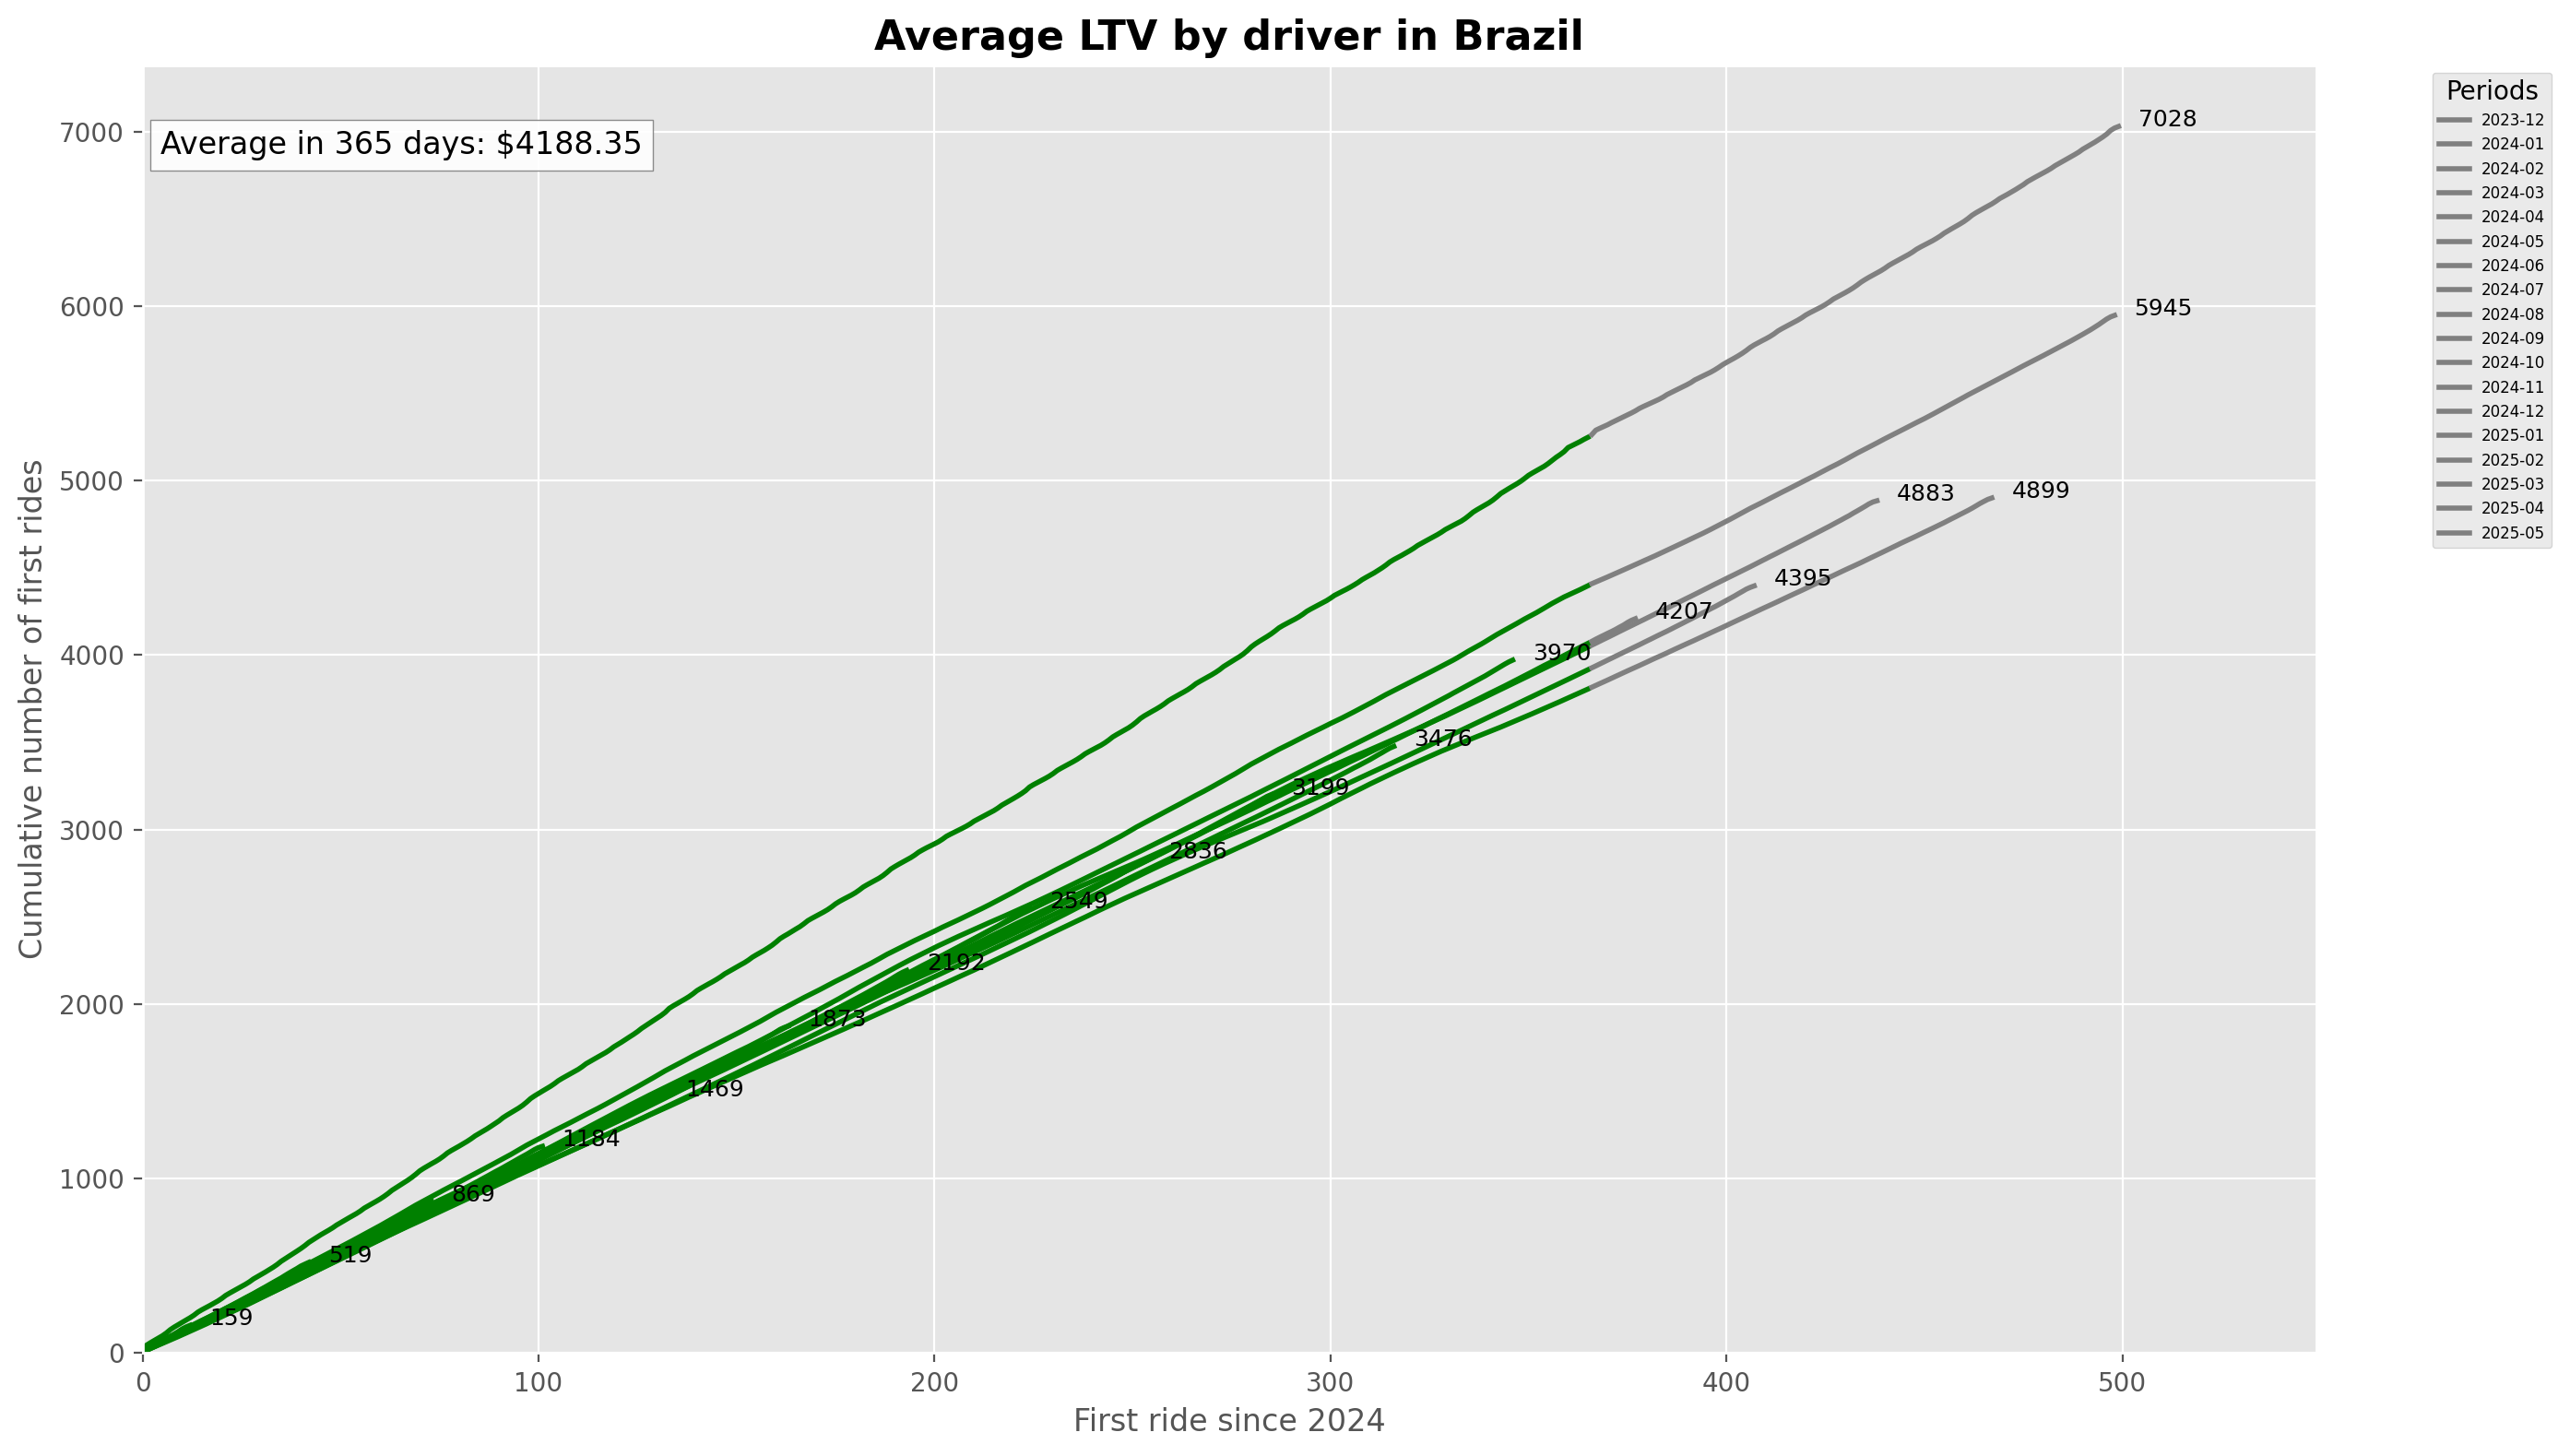

In [16]:
plt.style.use("ggplot") 

plt.figure(figsize=(14, 8))
ax = plt.gca()


for month, group in df_cum_sum_drivers.groupby('month'):
    group = group.sort_values('day_diff')

    # ax.plot(group['day_diff'], group['cum_sum'], label=pd.to_datetime(month).strftime('%Y-%m'), linewidth=2)
    last_point = group.iloc[-1]
    ax.text(
        last_point['day_diff'] + 5, 
        last_point['cum_sum'],
        f"{int(last_point['cum_sum'])}",
        fontsize=9,
        color='black'
    )

cutoff_x = 365

for month, group in df_cum_sum_drivers.groupby('month'):
    group = group.sort_values('day_diff')
    
    part1 = group[group['day_diff'] <= cutoff_x]
    part2 = group[group['day_diff'] > cutoff_x]

    base_color = 'green'
    highlight_color = 'gray'

    ax.plot(
        part1['day_diff'],
        part1['cum_sum'],
        color=base_color,
        linewidth=2
    )

    ax.plot(
        part2['day_diff'],
        part2['cum_sum'],
        color=highlight_color,
        linewidth=2,
        label=pd.to_datetime(month).strftime('%Y-%m')  
    )

ax.set_title('Average LTV by driver in Brazil', fontsize=16, weight='bold')
ax.set_xlabel('First ride since 2024', fontsize=12)
ax.set_ylabel('Cumulative number of first rides', fontsize=12)

mean = df_cum_sum_drivers[(df_cum_sum_drivers['day_diff']>=350) & (df_cum_sum_drivers['day_diff']<=370)]['cum_sum'].mean().round(2)

stats_text = f'Average in 365 days: ${mean}'

# Размещаем текст в правом верхнем углу
plt.text(0.23, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

x_max = df_cum_sum_drivers['day_diff'].max()
y_max = df_cum_sum_drivers['cum_sum'].max()

ax.set_xlim(0, x_max * 1.1)  
ax.set_ylim(0, y_max * 1.05)

plt.legend(title='Periods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)

plt.tight_layout()
plt.show()

In [17]:
df_potential_lost_drivers = read_bq("""
    WITH cte AS (SELECT redmine_id,
                    CASE
                        WHEN aggressor = 'Driver' THEN 'driver'
                        WHEN aggressor = 'Passenger' THEN 'pax'
                        ELSE 'unknown'
                        END AS aggressor_mode,
                    CASE
                        WHEN aggressor = 'Driver' THEN driver_id
                        WHEN aggressor = 'Passenger' THEN pass_id
                        ELSE NULL
                        END AS aggressor_id,
                    driver_id,
                    city_id,
                    city_name,
                    incident_date,
                    incident_type,
                    incident_level,
                    information_status,
             FROM `indriver-bi.safety.vw_safety_incidents_detail`
             WHERE aggressor = 'Passenger'
               AND incident_date BETWEEN '2024-01-01' AND '2025-01-01'
               AND information_status = 'Confirmed'),
     rides AS (SELECT user_id,
                      t1.country_id,
                      t2.country_name,
                      t1.city_id,
                      t2.city_name,
                      metric_date,
                      gmv_clean_usd,
                      rides_count
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                             ON
                                 t1.city_id = t2.city_id
               WHERE user_type = 'driver'
                 AND rides_count > 0
                 AND metric_date_utc >= '2024-01-01'),
     number_rides AS (SELECT user_id,
                             t1.country_id,
                             t2.country_name,
                             SUM(rides_count) AS rides_count,
                      FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                    ON
                                        t1.city_id = t2.city_id
                      WHERE user_type = 'driver'
                        AND metric_date_utc >= '2023-01-01'
                      GROUP BY 1, 2, 3)
    SELECT *
    FROM cte t1
            LEFT JOIN number_rides rid
                    ON t1.driver_id = rid.user_id
            LEFT JOIN rides t2 ON t1.driver_id = t2.user_id
        AND t2.metric_date > t1.incident_date
    QUALIFY ROW_NUMBER() OVER (PARTITION BY redmine_id ORDER BY metric_date) = 1
""")

df_potential_lost_drivers.head()

KeyboardInterrupt: 

In [105]:
def binary_check(row):
    if pd.isnull(row['user_id_1']):
        return 1
    else:
        return 0

df_potential_lost_drivers['binary_check'] = df_potential_lost_drivers.apply(binary_check, axis=1)
df_lost_drivers = df_potential_lost_drivers[(df_potential_lost_drivers['binary_check']==1)&(df_potential_lost_drivers['rides_count']>150)]

In [106]:
# confidence interval for earned money

avg_money_earned = df_cum_sum_drivers[(df_cum_sum_drivers['day_diff']>=350) & (df_cum_sum_drivers['day_diff']<=370)]['cum_sum']


interval = st.t.interval(confidence=0.95, df=len(avg_money_earned)-1, 
              loc=np.mean(avg_money_earned), 
              scale=st.sem(avg_money_earned),) 

interval

(4134.663140702344, 4347.675793244846)

In [107]:
def addition(row):
    first_value = np.round(row['driver_id'] * interval[0], 2)
    second_value = np.round(row['driver_id'] * interval[1], 2)

    return str([first_value, second_value])

df_potential_lost_drivers_agg = df_lost_drivers.groupby(['binary_check', 'incident_level'], as_index=False)['driver_id'].count()

df_potential_lost_drivers_agg['total'] = df_potential_lost_drivers['driver_id'].count()

df_potential_lost_drivers_agg['share_of_lost'] = df_potential_lost_drivers_agg['driver_id'] / df_potential_lost_drivers_agg['total'] * 100

df_potential_lost_drivers_agg['avg_earned_money_by_driver'] = df_cum_sum_drivers[(df_cum_sum_drivers['day_diff']>=350) & (df_cum_sum_drivers['day_diff']<=370)]['cum_sum'].mean().round(2)

df_potential_lost_drivers_agg['interval_avg_money'] = str(np.round(interval, 2))

df_potential_lost_drivers_agg['pot_lost_money'] = df_potential_lost_drivers_agg['driver_id'] * df_potential_lost_drivers_agg['avg_earned_money_by_driver']

df_potential_lost_drivers_agg['interval_evaluation'] = df_potential_lost_drivers_agg.apply(addition, axis=1)

df_potential_lost_drivers_agg

,binary_check,incident_level,driver_id,total,share_of_lost,avg_earned_money_by_driver,interval_avg_money,pot_lost_money,interval_evaluation
0,1,Green,177,54643,0.32,"4,241.17",[4134.66 4347.68],"750,687.09","[731835.38, 769538.62]"
1,1,Red,621,54643,1.14,"4,241.17",[4134.66 4347.68],"2,633,766.57","[2567625.81, 2699906.67]"
2,1,Yellow,930,54643,1.70,"4,241.17",[4134.66 4347.68],"3,944,288.10","[3845236.72, 4043338.49]"


##### Impact of connections

In [192]:
# rides and gmv
users_list = df_liveness_connected_99_merged.query("rides_bucket == '0' or rides_bucket == '1-10'").query("incident_level_digit == 2")['all_users_connections'].to_list()

total_list = []

for i in users_list:
    for z in i:
        total_list.append(z)

total_list = tuple(total_list)

In [193]:
len(total_list)

33402

In [194]:
df_level = read_bq(f"""
SELECT user_id,
       t1.country_id,
       t2.country_name,
       SUM(rides_count)   AS rides_count,
       SUM(gmv_clean_usd) AS gmv_clean_usd
FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
         JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
              ON
                  t1.city_id = t2.city_id
WHERE 1 = 1
  AND metric_date_utc >= '2024-01-01'
  AND user_id IN {total_list}
GROUP BY 1, 2, 3
""")
df_level

,user_id,country_id,country_name,rides_count,gmv_clean_usd
0,241682964,11,Brazil,1,4.92
1,251769294,11,Brazil,8,36.34
2,245472909,11,Brazil,0,0.00
3,271139449,11,Brazil,0,0.00
4,250260765,11,Brazil,1,2.56
...,...,...,...,...,...
3850,185856572,11,Brazil,9,59.38
3851,219047589,11,Brazil,0,0.00
3852,260523014,11,Brazil,27,85.70
3853,213772175,11,Brazil,2,5.28


In [195]:
df_level.shape[0], len(total_list)

(3855, 33402)

In [156]:
df_gathered_info_aggressors = pd.DataFrame(
    {
        'total_users':[33402, 1834, 1597],
        'level':['yellow', 'red', 'green'],
        'found_in_rides':[3855, 747, 937],
        'rides':[36890, 5428, 11201],
        'gmv':[157660.38, 28300.77, 47117.21]
    }
    )

df_gathered_info_aggressors

,total_users,level,found_in_rides,rides,gmv
0,33402,yellow,3855,36890,"157,660.38"
1,1834,red,747,5428,"28,300.77"
2,1597,green,937,11201,"47,117.21"


## Incidents by connections and bans

##### Functions

In [19]:
list_of_red_aggressors = set(df_all_incidents[df_all_incidents['incident_level_digit']==3]['aggressor_id'])
list_of_yellow_aggressors = set(df_all_incidents[df_all_incidents['incident_level_digit']==2]['aggressor_id'])
list_of_green_aggressors = set(df_all_incidents[df_all_incidents['incident_level_digit']==1]['aggressor_id'])

def level_1st_aggressors(row): # Check everyone who committed the incidents in 1st level
        aggressors = []
        aggressor_numbers = 0
        result_dict = {}
        iterable = row[0]
        for user in iterable:
            if user in set(list_of_aggressors):
                aggressors.append(user)
                aggressor_numbers += 1
            else:
                continue

        result_dict[aggressor_numbers] = aggressors
        return result_dict

def level_2nd_aggressors(row): # if there are connections of over than 1st level, so check everyone in terms of current level

    if len(row) > 1:
        aggressors = []
        aggressor_numbers = 0
        result_dict = {}
        iterable = row[1]
        for user in iterable:
            if user in set(list_of_aggressors):
                aggressors.append(user)
                aggressor_numbers += 1
    
        result_dict[aggressor_numbers] = aggressors
        
        return result_dict
    else:
        return 0

def level_3rd_aggressors(row): # if there are connections of over than 2nd level, then check everyone in 3rd level


    if len(row) > 2:
        aggressors = []
        aggressor_numbers = 0
        result_dict = {}
        iterable = row[2]
        for user in iterable:
            if user in set(list_of_aggressors):
                aggressors.append(user)
                aggressor_numbers += 1
    
        result_dict[aggressor_numbers] = aggressors
        
        return result_dict
    else:
        return 0

def all_connections_users(row):
        all_connections = []
        for iterable in row:
            for user in iterable:
                all_connections.append(user)

        return all_connections

def all_connected_aggressors_number_red(row):
        aggressor_numbers = 0
        for user in row:
            if user in list_of_red_aggressors:
                aggressor_numbers += 1
            else:
                continue

        return aggressor_numbers

def all_connected_aggressors_number_yellow(row):
        aggressor_numbers = 0
        for user in row:
            if user in list_of_yellow_aggressors:
                aggressor_numbers += 1
            else:
                continue

        return aggressor_numbers

def all_connected_aggressors_number_green(row):
        aggressor_numbers = 0
        for user in row:
            if user in list_of_green_aggressors:
                aggressor_numbers += 1
            else:
                continue

        return aggressor_numbers

def all_connected_banned_number(row):
        aggressor_numbers = 0
        for user in row:
            if user in list_of_banned:
                aggressor_numbers += 1
            else:
                continue

        return aggressor_numbers

def level_1st_aggressors_number(row):
        aggressor_numbers = 0
        iterable = row[0]
        for user in iterable:
            if user in list_of_aggressors:
                aggressor_numbers += 1
            else:
                continue

        return aggressor_numbers

def level_2nd_aggressors_number(row):
    if len(row) > 1:
        aggressor_numbers = 0
        iterable = row[1]
        for user in iterable:
            if user in set(list_of_aggressors):
                aggressor_numbers += 1
        
        return aggressor_numbers
    else:
        return 0

def level_3rd_aggressors_number(row):


    if len(row) > 2:
        aggressor_numbers = 0
        iterable = row[2]
        for user in iterable:
            if user in set(list_of_aggressors):
                aggressor_numbers += 1
        
        return aggressor_numbers
    else:
        return 0
    
def banned_flg(row):
    if row == 0:
        return 'Not banned'
    else:
        return 'Banned'
    
def aggr_flg(row):
    if row == 0:
        return 0
    else:
        return 1

In [23]:
# Bans

list_of_banned = set(df_banned_users['user_id'])
df_liveness_connected_99['connected_banned_number'] = df_liveness_connected_99['all_users_connections'].apply(all_connected_banned_number)

KeyError: 'all_users_connections'

In [74]:
total_incidents_for_results = read_bq("""
  SELECT redmine_id,
        aggressor_mode,
        aggressor_id,
        city_id,
        city_name,
        incident_date,
        incident_type,
        information_status,
        MAX(incident_level_digit) AS incident_level_digit,
  FROM (SELECT redmine_id,
              'driver'  AS aggressor_mode,
              driver_id AS aggressor_id,
              city_id,
              city_name,
              incident_date,
              incident_type,
              incident_level,
              information_status,
              CASE
                  WHEN incident_level = 'Green' THEN 1
                  WHEN incident_level = 'Yellow' THEN 2
                  WHEN incident_level = 'Red' THEN 3
                  ELSE 0
                  END      incident_level_digit
        FROM indriver-bi.safety.vw_safety_incidents_detail
        WHERE aggressor = 'Driver'
          AND information_status = 'Confirmed'
          AND country_name = 'Brazil'
        UNION
        DISTINCT
        SELECT redmine_id,
              'pax'   AS aggressor_mode,
              pass_id AS aggressor_id,
              city_id,
              city_name,
              incident_date,
              incident_type,
              incident_level,
              information_status,
              CASE
                  WHEN incident_level = 'Green' THEN 1
                  WHEN incident_level = 'Yellow' THEN 2
                  WHEN incident_level = 'Red' THEN 3
                  ELSE 0
                  END    incident_level_digit
        FROM indriver-bi.safety.vw_safety_incidents_detail
        WHERE aggressor = 'Passenger'
          AND information_status = 'Confirmed'
          AND country_name = 'Brazil')
  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
""")

In [77]:
total_incidents_for_results[total_incidents_for_results['incident_level_digit'].isin([2,3])]

,redmine_id,aggressor_mode,aggressor_id,city_id,city_name,incident_date,incident_type,information_status,incident_level_digit
0,287540,pax,153965104,4541,Uberlândia,2022-12-31,Car theft,Confirmed,3
2,SQ-198830,pax,232159038,25961,Mogi das Cruzes,2024-05-24,Car theft,Confirmed,3
3,SQ-221650,pax,100665215,4548,Foz do Iguaçu,2024-06-19,Bothering before/after a trip for the purpose ...,Confirmed,2
4,346369,pax,135784829,5007,Porto Seguro,2023-04-14,Bothering before/after a trip for the purpose ...,Confirmed,2
5,SQ-443938,pax,174778599,4518,Aracaju,2025-01-10,Bothering before/after a trip for the purpose ...,Confirmed,2
...,...,...,...,...,...,...,...,...,...
56362,SQ-478635,pax,279065039,4755,Porto Alegre,2025-02-02,Buying/transportation of drugs,Confirmed,2
56368,SQ-231960,driver,63204808,4755,Porto Alegre,2024-06-30,Fraud,Confirmed,2
56369,SQ-471286,driver,133923442,4755,Porto Alegre,2025-01-25,Bothering before/after a trip for the purpose ...,Confirmed,2
56371,SQ-522684,driver,130107423,4755,Porto Alegre,2025-03-02,Intimate actions,Confirmed,2


In [72]:
df_liveness_connected_99_merged

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,Unnamed: 0,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1,user_id_y,start_dttm,end_dttm,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
0,235306259,"([198855292],)",1,1,1,0,0,62621431,235306259,2024-05-26,Brazil,São Paulo,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[198855292],0,0,0,0
1,274843700,"([288038371],)",1,1,1,0,0,61012385,274843700,2025-01-05,Brazil,São Paulo,client,1,8,20,22.91,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[288038371],0,0,0,0
2,237169161,"([62703570, 64454250, 162468319],)",1,3,3,0,0,35926692,237169161,2024-06-06,Brazil,Rio de Janeiro,client,1,8,27,45.61,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[62703570, 64454250, 162468319]",0,0,0,0
3,244863967,"([211940908, 287290053],)",1,2,2,0,0,33391589,244863967,2024-07-17,Brazil,São Paulo,client,1,1,6,20.24,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[211940908, 287290053]",0,0,0,0
4,280297948,"([49972462],)",1,1,1,0,0,19986764,280297948,2025-02-09,Brazil,Florianópolis,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[49972462],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369451,255072925,"([175630845],)",1,1,1,0,0,68144861,255072925,2024-09-13,Brazil,Brasília,client,0,0,3,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[175630845],0,0,0,0
369452,233191548,"([22879005],)",1,1,1,0,0,22062314,233191548,2024-05-13,Brazil,Recife,client,1,8,25,36.41,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[22879005],0,0,0,0
369453,223631016,"([120411099],)",1,1,1,0,0,68354192,223631016,2024-03-14,Brazil,Iperó,driver,1,4,13,28.95,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[120411099],0,0,0,0
369454,219540601,"([119070237],)",1,1,1,0,0,26680849,219540601,2024-02-17,Brazil,Campinas,client,1,5,21,23.01,1-10,1-10,219540601,2024-08-13 07:21:45+00:00,2092-08-31 10:35:52+00:00,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Banned,[119070237],0,0,0,0


In [73]:
df_all_incidents

,redmine_id,aggressor_mode,aggressor_id,city_id,city_name,incident_date,incident_type,information_status,incident_level_digit
0,279322,pax,150761101,5667,Surabaya,2022-12-22,Bothering before/after a trip for the purpose ...,Confirmed,2
1,SQ-133099,pax,145063535,4148,Boa Vista,2024-03-09,Bothering before/after a trip for the purpose ...,Confirmed,2
2,SQ-460017,pax,243049848,4272,Chiclayo,2025-01-21,Attempted robbery,Confirmed,1
3,SQ-508583,pax,143716015,4299,Johannesburg,2025-02-21,None,Confirmed,1
4,SQ-531757,pax,280635331,4178,Uberaba,2025-03-08,Damage to someone else's property,Confirmed,1
...,...,...,...,...,...,...,...,...,...
245464,SQ-513076,driver,177949312,10155,Cairo (القاهرة),2025-02-23,"Bothering before/after a trip SMS, call, messe...",Confirmed,2
245465,SQ-216744,driver,93905175,10155,Cairo (القاهرة),2024-06-14,"Bothering before/after a trip SMS, call, messe...",Confirmed,2
245466,SQ-41947,driver,99582294,10155,Cairo (القاهرة),2023-10-28,Bothering before/after a trip for the purpose ...,Confirmed,2
245467,SQ-371607,driver,108854005,10155,Cairo (القاهرة),2024-11-24,"Bothering before/after a trip SMS, call, messe...",Confirmed,2


##### 99%+

In [21]:
# df_liveness_connected_merged
df_liveness_connected_99_merged = df_liveness_connected_99_merged.merge(df_banned_users, how='left', left_on='user_id_from', right_on='user_id')
df_liveness_connected_99_merged = df_liveness_connected_99_merged.merge(df_all_incidents, how='left', left_on='user_id_from', right_on='aggressor_id')

df_liveness_connected_99_merged['aggressor_id'] = df_liveness_connected_99_merged['aggressor_id'].fillna(0)
df_liveness_connected_99_merged['aggressor_flag'] = df_liveness_connected_99_merged['aggressor_id'].apply(aggr_flg)

df_liveness_connected_99_merged['user_id_y'] = df_liveness_connected_99_merged['user_id_y'].fillna(0)
df_liveness_connected_99_merged['banned_flg'] = df_liveness_connected_99_merged['user_id_y'].apply(banned_flg)

In [22]:
df_liveness_connected_99_merged['all_users_connections'] = df_liveness_connected_99_merged['liveness_conn'].apply(all_connections_users)

# df_liveness_connected_99_merged['level_1_aggressors'] = df_liveness_connected_99_merged['liveness_conn'].apply(level_1st_aggressors)
# df_liveness_connected_99_merged['level_2_aggressors'] = df_liveness_connected_99_merged['liveness_conn'].apply(level_2nd_aggressors)
# df_liveness_connected_99_merged['level_3_aggressors'] = df_liveness_connected_99_merged['liveness_conn'].apply(level_3rd_aggressors)

# df_liveness_connected_99_merged['level_1_aggressors_number'] = df_liveness_connected_99_merged['liveness_conn'].apply(level_1st_aggressors_number)
# df_liveness_connected_99_merged['level_2_aggressors_number'] = df_liveness_connected_99_merged['liveness_conn'].apply(level_2nd_aggressors_number)
# df_liveness_connected_99_merged['level_3_aggressors_number'] = df_liveness_connected_99_merged['liveness_conn'].apply(level_3rd_aggressors_number)

df_liveness_connected_99_merged['red_aggressors_number'] = df_liveness_connected_99_merged['all_users_connections'].apply(all_connected_aggressors_number_red)
df_liveness_connected_99_merged['yellow_aggressors_number'] = df_liveness_connected_99_merged['all_users_connections'].apply(all_connected_aggressors_number_yellow)
df_liveness_connected_99_merged['green_aggressors_number'] = df_liveness_connected_99_merged['all_users_connections'].apply(all_connected_aggressors_number_green)

df_liveness_connected_99_merged['connected_banned_number'] = df_liveness_connected_99_merged['all_users_connections'].apply(all_connected_banned_number)

df_liveness_connected_99_merged

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,Unnamed: 0,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1,user_id_y,start_dttm,end_dttm,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
0,235306259,"([198855292],)",1,1,1,0,0,62621431,235306259,2024-05-26,Brazil,São Paulo,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[198855292],0,0,0,0
1,274843700,"([288038371],)",1,1,1,0,0,61012385,274843700,2025-01-05,Brazil,São Paulo,client,1,8,20,22.91,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[288038371],0,0,0,0
2,237169161,"([62703570, 64454250, 162468319],)",1,3,3,0,0,35926692,237169161,2024-06-06,Brazil,Rio de Janeiro,client,1,8,27,45.61,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[62703570, 64454250, 162468319]",0,0,0,0
3,244863967,"([211940908, 287290053],)",1,2,2,0,0,33391589,244863967,2024-07-17,Brazil,São Paulo,client,1,1,6,20.24,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[211940908, 287290053]",0,0,0,0
4,280297948,"([49972462],)",1,1,1,0,0,19986764,280297948,2025-02-09,Brazil,Florianópolis,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[49972462],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369451,255072925,"([175630845],)",1,1,1,0,0,68144861,255072925,2024-09-13,Brazil,Brasília,client,0,0,3,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[175630845],0,0,0,0
369452,233191548,"([22879005],)",1,1,1,0,0,22062314,233191548,2024-05-13,Brazil,Recife,client,1,8,25,36.41,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[22879005],0,0,0,0
369453,223631016,"([120411099],)",1,1,1,0,0,68354192,223631016,2024-03-14,Brazil,Iperó,driver,1,4,13,28.95,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[120411099],0,0,0,0
369454,219540601,"([119070237],)",1,1,1,0,0,26680849,219540601,2024-02-17,Brazil,Campinas,client,1,5,21,23.01,1-10,1-10,219540601,2024-08-13 07:21:45+00:00,2092-08-31 10:35:52+00:00,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Banned,[119070237],0,0,0,0


In [25]:
df_all_incidents[df_all_incidents['aggressor_id']==91039989]

,redmine_id,aggressor_mode,aggressor_id,city_id,city_name,incident_date,incident_type,information_status,incident_level_digit
175779,SQ-40309,pax,91039989,4375,Rio de Janeiro,2023-10-26,Bothering before/after a trip for the purpose ...,Confirmed,2


In [26]:
df_banned_users[df_banned_users['user_id']==91039989]

,user_id,start_dttm,end_dttm
3941152,91039989,2023-10-26 03:42:05+00:00,2091-11-13 06:56:12+00:00


In [27]:
df_connections[df_connections['user_id_to']==222301117]

,user_id_from,user_id_to,connection_type,confidence_level,confidence_level_group
3240495,124404120,222301117,liveness,1.00,100.00


In [71]:
df_liveness_connected_99_merged

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,Unnamed: 0,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1,user_id_y,start_dttm,end_dttm,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
0,235306259,"([198855292],)",1,1,1,0,0,62621431,235306259,2024-05-26,Brazil,São Paulo,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[198855292],0,0,0,0
1,274843700,"([288038371],)",1,1,1,0,0,61012385,274843700,2025-01-05,Brazil,São Paulo,client,1,8,20,22.91,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[288038371],0,0,0,0
2,237169161,"([62703570, 64454250, 162468319],)",1,3,3,0,0,35926692,237169161,2024-06-06,Brazil,Rio de Janeiro,client,1,8,27,45.61,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[62703570, 64454250, 162468319]",0,0,0,0
3,244863967,"([211940908, 287290053],)",1,2,2,0,0,33391589,244863967,2024-07-17,Brazil,São Paulo,client,1,1,6,20.24,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[211940908, 287290053]",0,0,0,0
4,280297948,"([49972462],)",1,1,1,0,0,19986764,280297948,2025-02-09,Brazil,Florianópolis,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[49972462],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369451,255072925,"([175630845],)",1,1,1,0,0,68144861,255072925,2024-09-13,Brazil,Brasília,client,0,0,3,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[175630845],0,0,0,0
369452,233191548,"([22879005],)",1,1,1,0,0,22062314,233191548,2024-05-13,Brazil,Recife,client,1,8,25,36.41,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[22879005],0,0,0,0
369453,223631016,"([120411099],)",1,1,1,0,0,68354192,223631016,2024-03-14,Brazil,Iperó,driver,1,4,13,28.95,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[120411099],0,0,0,0
369454,219540601,"([119070237],)",1,1,1,0,0,26680849,219540601,2024-02-17,Brazil,Campinas,client,1,5,21,23.01,1-10,1-10,219540601,2024-08-13 07:21:45+00:00,2092-08-31 10:35:52+00:00,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Banned,[119070237],0,0,0,0


In [28]:
# Total

df_liveness_connected_99_agg_rec_inc = df_liveness_connected_99_merged.query("mode == 'client'").groupby(['banned_flg', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'red_aggressors_number',
    'yellow_aggressors_number',
    'green_aggressors_number',
    'connected_banned_number'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'red_aggressors_number':'sum',
     'yellow_aggressors_number':'sum',
     'green_aggressors_number':'sum',
     'connected_banned_number':'sum'}
)

df_liveness_connected_99_agg_rec_inc['mean_connected_numbers'] = df_liveness_connected_99_agg_rec_inc['number_connections'] / df_liveness_connected_99_agg_rec_inc['user_id_from']
df_liveness_connected_99_agg_rec_inc['total_incidents'] = df_liveness_connected_99_agg_rec_inc['red_aggressors_number'] + df_liveness_connected_99_agg_rec_inc['yellow_aggressors_number'] + df_liveness_connected_99_agg_rec_inc['green_aggressors_number']
df_liveness_connected_99_agg_rec_inc['number_inc_by_user'] = df_liveness_connected_99_agg_rec_inc['total_incidents'] / df_liveness_connected_99_agg_rec_inc['user_id_from']
df_liveness_connected_99_agg_rec_inc['share_of_banned'] = df_liveness_connected_99_agg_rec_inc['connected_banned_number'] / df_liveness_connected_99_agg_rec_inc['number_connections']*100
df_liveness_connected_99_agg_rec_inc['number_conn_by_users'] = df_liveness_connected_99_agg_rec_inc['number_connections'] / df_liveness_connected_99_agg_rec_inc['user_id_from']


df_liveness_connected_99_agg_rec_inc[[
    'rides_bucket', 'banned_flg', 'user_id_from', 'number_connections', 
    'mean_connected_numbers', 'red_aggressors_number', 'yellow_aggressors_number', 
    'green_aggressors_number', 'connected_banned_number'
    ]]

df_liveness_connected_99_agg_rec_inc

,banned_flg,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,mean_connected_numbers,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users
0,Banned,0,14878,138926,117517,18919,2490,3208,25031,5158,95251,9.34,33397,2.24,68.56,9.34
1,Banned,1-10,14100,65347,58834,3716,2797,1677,10476,3832,41594,4.63,15985,1.13,63.65,4.63
2,Banned,10-30,3757,10436,10027,140,269,112,1120,397,4609,2.78,1629,0.43,44.16,2.78
3,Banned,100-500,565,2054,1253,316,485,15,88,36,467,3.64,139,0.25,22.74,3.64
4,Banned,30-100,2197,5898,5467,109,322,27,497,229,2245,2.68,753,0.34,38.06,2.68
5,Banned,>501,17,90,90,0,0,0,18,8,71,5.29,26,1.53,78.89,5.29
6,Not banned,0,74747,201772,122639,25918,53215,217,3483,552,20000,2.70,4252,0.06,9.91,2.70
7,Not banned,1-10,163916,395088,267991,40284,86813,265,3136,979,23244,2.41,4380,0.03,5.88,2.41
8,Not banned,10-30,49769,110083,83486,7288,19309,72,707,324,6648,2.21,1103,0.02,6.04,2.21
9,Not banned,100-500,6066,10855,10006,137,712,6,81,45,888,1.79,132,0.02,8.18,1.79


In [29]:
# By aggressors

df_liveness_connected_99_agg_rec_inc_sep = df_liveness_connected_99_merged[df_liveness_connected_99_merged['aggressor_flag']==1].query("mode == 'client'").groupby(['incident_level_digit', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'red_aggressors_number',
    'yellow_aggressors_number',
    'green_aggressors_number',
    'connected_banned_number'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'red_aggressors_number':'sum',
     'yellow_aggressors_number':'sum',
     'green_aggressors_number':'sum',
     'connected_banned_number':'sum'}
)

df_liveness_connected_99_agg_rec_inc_sep['total_incidents'] = df_liveness_connected_99_agg_rec_inc_sep['red_aggressors_number'] + df_liveness_connected_99_agg_rec_inc_sep['yellow_aggressors_number'] + df_liveness_connected_99_agg_rec_inc_sep['green_aggressors_number']
df_liveness_connected_99_agg_rec_inc_sep['number_inc_by_user'] = df_liveness_connected_99_agg_rec_inc_sep['total_incidents'] / df_liveness_connected_99_agg_rec_inc_sep['user_id_from']
df_liveness_connected_99_agg_rec_inc_sep['share_of_banned'] = df_liveness_connected_99_agg_rec_inc_sep['connected_banned_number'] / df_liveness_connected_99_agg_rec_inc_sep['number_connections']*100
df_liveness_connected_99_agg_rec_inc_sep['number_conn_by_users'] = df_liveness_connected_99_agg_rec_inc_sep['number_connections'] / df_liveness_connected_99_agg_rec_inc_sep['user_id_from']

df_liveness_connected_99_agg_rec_inc_sep[[
    'rides_bucket', 'incident_level_digit', 'user_id_from', 
    'number_connections', 'number_conn_by_users', 'connected_banned_number', 'share_of_banned', 
    'total_incidents', 'number_inc_by_user', 'red_aggressors_number', 
    'yellow_aggressors_number', 'green_aggressors_number'
    ]]

df_liveness_connected_99_agg_rec_inc_sep

,incident_level_digit,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users
0,1,0,601,3517,3339,143,35,131,851,571,2988,1553,2.58,84.96,5.85
1,1,1-10,1040,4931,4763,140,28,102,1093,749,3858,1944,1.87,78.24,4.74
2,1,10-30,305,763,751,12,0,4,81,63,358,148,0.49,46.92,2.50
3,1,100-500,44,84,82,2,0,0,2,5,22,7,0.16,26.19,1.91
4,1,30-100,158,428,427,1,0,3,51,43,228,97,0.61,53.27,2.71
5,1,>501,1,1,1,0,0,0,0,0,0,0,0.00,0.00,1.00
6,2,0,2049,34911,27665,7168,78,215,8252,1110,23422,9577,4.67,67.09,17.04
7,2,1-10,2457,17862,16105,1068,689,233,4680,1365,13743,6278,2.56,76.94,7.27
8,2,10-30,507,2055,2003,52,0,7,471,163,1413,641,1.26,68.76,4.05
9,2,100-500,71,160,158,2,0,0,22,5,70,27,0.38,43.75,2.25


In [445]:
df_liveness_connected_99_merged[(df_liveness_connected_99_merged['aggressor_flag']>0)& (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))]

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,Unnamed: 0,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1,user_id_y,start_dttm,end_dttm,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
29,219045816,"([215789949, 229192936, 288965005, 291060175, ...",1,6,6,0,0,10448029,219045816,2024-02-14,Brazil,São Paulo,client,1,3,13,13.28,1-10,1-10,219045816,2024-02-28 16:42:23+00:00,2092-03-17 19:56:30+00:00,SQ-124692,pax,219045816,4142,São Paulo,2024-02-22,Robbery,Confirmed,2,1,Banned,"[215789949, 229192936, 288965005, 291060175, 2...",0,4,0,6
124,286066266,"([155760439, 228538853, 233375959, 239946409, ...",1,14,14,0,0,47908515,286066266,2025-03-17,Brazil,Recife,client,0,0,0,0.00,0,0,286066266,2025-04-06 03:50:05+00:00,2125-04-09 22:30:05+00:00,SQ-585371,pax,286066266,4142,São Paulo,2025-04-06,Bothering before/after a trip for the purpose ...,Confirmed,2,1,Banned,"[155760439, 228538853, 233375959, 239946409, 2...",0,0,0,8
189,218501208,"([112878221, 187387244, 280369753],)",1,3,3,0,0,8701292,218501208,2024-02-10,Brazil,Salvador,client,1,1,22,6.00,1-10,1-10,218501208,2024-03-24 05:55:23+00:00,2092-04-11 09:09:30+00:00,SQ-144563,pax,218501208,4153,Salvador,2024-03-24,Bothering before/after a trip for the purpose ...,Confirmed,2,1,Banned,"[112878221, 187387244, 280369753]",0,0,0,1
204,249600181,"([52910529, 61462666, 92515822, 148152268, 150...",1,17,17,0,0,38808959,249600181,2024-08-12,Brazil,Rio de Janeiro,client,0,0,231,0.00,0,0,249600181,2024-08-23 03:00:00+00:00,2094-08-23 03:00:00+00:00,SQ-280342,pax,249600181,4375,Rio de Janeiro,2024-08-23,Bothering before/after a trip for the purpose ...,Confirmed,2,1,Banned,"[52910529, 61462666, 92515822, 148152268, 1506...",0,7,0,10
224,230605177,"([289346695],)",1,1,1,0,0,17576397,230605177,2024-04-28,Brazil,Salvador,client,1,41,71,133.28,30-100,100-300,230605177,2024-11-15 16:37:14+00:00,2092-12-03 19:51:21+00:00,SQ-363246,pax,230605177,4153,Salvador,2024-11-15,Buying/transportation of drugs,Confirmed,2,1,Banned,[289346695],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367920,230533626,"([254343941],)",1,1,1,0,0,51259197,230533626,2024-04-28,Brazil,Salvador,client,1,2,17,9.10,1-10,1-10,230533626,2024-05-28 18:11:02+00:00,2092-06-15 21:25:09+00:00,SQ-201280,pax,230533626,4153,Salvador,2024-05-28,Robbery,Confirmed,2,1,Banned,[254343941],0,0,0,0
368118,243823346,"([290256991],)",1,1,1,0,0,25742244,243823346,2024-07-12,Mexico,Guadalajara,client,0,0,1,0.00,0,0,243823346,2024-07-20 15:39:50+00:00,2090-07-20 06:00:00+00:00,SQ-248998,pax,243823346,4225,Guadalajara,2024-07-17,Car theft,Confirmed,3,1,Banned,[290256991],0,0,0,1
368940,213580960,"([290069348],)",1,1,1,0,0,43016457,213580960,2024-01-08,Peru,Lima,client,1,32,71,98.03,30-100,1-10,213580960,2024-10-20 06:00:00+00:00,2099-10-20 06:00:00+00:00,SQ-337020,pax,213580960,4199,Lima,2024-10-20,Fraud,Confirmed,2,1,Banned,[290069348],0,0,0,0
369211,278254919,"([141683614],)",1,1,1,0,0,23700460,278254919,2025-01-28,Brazil,São Paulo,client,0,0,1,0.00,0,0,278254919,2025-02-09 06:45:37+00:00,2125-02-13 01:25:37+00:00,SQ-489414,pax,278254919,4142,São Paulo,2025-02-09,Theft,Confirmed,2,1,Banned,[141683614],0,0,0,0


In [562]:
df_liveness_connected_99_merged[(df_liveness_connected_99_merged['aggressor_flag']>0)& (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))]

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,Unnamed: 0,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1,user_id_y,start_dttm,end_dttm,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
29,219045816,"([215789949, 229192936, 288965005, 291060175, ...",1,6,6,0,0,10448029,219045816,2024-02-14,Brazil,São Paulo,client,1,3,13,13.28,1-10,1-10,219045816,2024-02-28 16:42:23+00:00,2092-03-17 19:56:30+00:00,SQ-124692,pax,219045816,4142,São Paulo,2024-02-22,Robbery,Confirmed,2,1,Banned,"[215789949, 229192936, 288965005, 291060175, 2...",0,4,0,6
124,286066266,"([155760439, 228538853, 233375959, 239946409, ...",1,14,14,0,0,47908515,286066266,2025-03-17,Brazil,Recife,client,0,0,0,0.00,0,0,286066266,2025-04-06 03:50:05+00:00,2125-04-09 22:30:05+00:00,SQ-585371,pax,286066266,4142,São Paulo,2025-04-06,Bothering before/after a trip for the purpose ...,Confirmed,2,1,Banned,"[155760439, 228538853, 233375959, 239946409, 2...",0,0,0,8
189,218501208,"([112878221, 187387244, 280369753],)",1,3,3,0,0,8701292,218501208,2024-02-10,Brazil,Salvador,client,1,1,22,6.00,1-10,1-10,218501208,2024-03-24 05:55:23+00:00,2092-04-11 09:09:30+00:00,SQ-144563,pax,218501208,4153,Salvador,2024-03-24,Bothering before/after a trip for the purpose ...,Confirmed,2,1,Banned,"[112878221, 187387244, 280369753]",0,0,0,1
204,249600181,"([52910529, 61462666, 92515822, 148152268, 150...",1,17,17,0,0,38808959,249600181,2024-08-12,Brazil,Rio de Janeiro,client,0,0,231,0.00,0,0,249600181,2024-08-23 03:00:00+00:00,2094-08-23 03:00:00+00:00,SQ-280342,pax,249600181,4375,Rio de Janeiro,2024-08-23,Bothering before/after a trip for the purpose ...,Confirmed,2,1,Banned,"[52910529, 61462666, 92515822, 148152268, 1506...",0,7,0,10
224,230605177,"([289346695],)",1,1,1,0,0,17576397,230605177,2024-04-28,Brazil,Salvador,client,1,41,71,133.28,30-100,100-300,230605177,2024-11-15 16:37:14+00:00,2092-12-03 19:51:21+00:00,SQ-363246,pax,230605177,4153,Salvador,2024-11-15,Buying/transportation of drugs,Confirmed,2,1,Banned,[289346695],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367920,230533626,"([254343941],)",1,1,1,0,0,51259197,230533626,2024-04-28,Brazil,Salvador,client,1,2,17,9.10,1-10,1-10,230533626,2024-05-28 18:11:02+00:00,2092-06-15 21:25:09+00:00,SQ-201280,pax,230533626,4153,Salvador,2024-05-28,Robbery,Confirmed,2,1,Banned,[254343941],0,0,0,0
368118,243823346,"([290256991],)",1,1,1,0,0,25742244,243823346,2024-07-12,Mexico,Guadalajara,client,0,0,1,0.00,0,0,243823346,2024-07-20 15:39:50+00:00,2090-07-20 06:00:00+00:00,SQ-248998,pax,243823346,4225,Guadalajara,2024-07-17,Car theft,Confirmed,3,1,Banned,[290256991],0,0,0,1
368940,213580960,"([290069348],)",1,1,1,0,0,43016457,213580960,2024-01-08,Peru,Lima,client,1,32,71,98.03,30-100,1-10,213580960,2024-10-20 06:00:00+00:00,2099-10-20 06:00:00+00:00,SQ-337020,pax,213580960,4199,Lima,2024-10-20,Fraud,Confirmed,2,1,Banned,[290069348],0,0,0,0
369211,278254919,"([141683614],)",1,1,1,0,0,23700460,278254919,2025-01-28,Brazil,São Paulo,client,0,0,1,0.00,0,0,278254919,2025-02-09 06:45:37+00:00,2125-02-13 01:25:37+00:00,SQ-489414,pax,278254919,4142,São Paulo,2025-02-09,Theft,Confirmed,2,1,Banned,[141683614],0,0,0,0


In [568]:
63202*0.312

19719.024

In [565]:
total_list = []

for i in df_liveness_connected_99_merged[(df_liveness_connected_99_merged['aggressor_flag']>0)& (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))]\
['all_users_connections']:
    for z in i:
        total_list.append(z)

total_list = tuple(set(total_list))
len(total_list)

19813

In [558]:
perc = np.percentile(df_liveness_connected_99_merged[(df_liveness_connected_99_merged['aggressor_flag']>0)]['number_connections'], 95)

x = df_liveness_connected_99_merged[(df_liveness_connected_99_merged['aggressor_flag']>0)& (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))].groupby('number_connections', as_index=False)['user_id_from'].nunique()

In [532]:
df_share_of_conn = x
df_share_of_conn['total'] = df_liveness_connected_99_merged[(df_liveness_connected_99_merged['aggressor_flag']>0)& (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))]['number_connections'].count()

df_share_of_conn['share'] = df_share_of_conn['user_id_from']/df_share_of_conn['total']*100

df_share_of_conn['number_of_connections'] = df_share_of_conn['user_id_from']*df_share_of_conn['number_connections']

# df_share_of_conn[df_share_of_conn['number_connections']>13]
df_share_of_conn['number_of_connections'].sum()

63202

In [463]:
df_incidents_brazil = read_bq("""
SELECT redmine_id,
       aggressor_mode,
       aggressor_id,
       city_id,
       city_name,
       date_trunc(incident_date, year) as year,
       date_trunc(incident_date, month) as month,
       incident_type,
       information_status,
       MAX(incident_level_digit) AS incident_level_digit,
FROM (SELECT redmine_id,
             'driver'  AS aggressor_mode,
             driver_id AS aggressor_id,
             city_id,
             city_name,
             incident_date,
             incident_type,
             incident_level,
             information_status,
             CASE
                 WHEN incident_level = 'Green' THEN 1
                 WHEN incident_level = 'Yellow' THEN 2
                 WHEN incident_level = 'Red' THEN 3
                 ELSE 0
                 END      incident_level_digit
      FROM indriver-bi.safety.vw_safety_incidents_detail
      WHERE aggressor = 'Driver'
        AND information_status = 'Confirmed'
        AND country_name = 'Brazil'
      UNION
      DISTINCT
      SELECT redmine_id,
             'pax'   AS aggressor_mode,
             pass_id AS aggressor_id,
             city_id,
             city_name,
             incident_date,
             incident_type,
             incident_level,
             information_status,
             CASE
                 WHEN incident_level = 'Green' THEN 1
                 WHEN incident_level = 'Yellow' THEN 2
                 WHEN incident_level = 'Red' THEN 3
                 ELSE 0
                 END    incident_level_digit
      FROM indriver-bi.safety.vw_safety_incidents_detail
      WHERE aggressor = 'Passenger'
        AND information_status = 'Confirmed'
        AND country_name = 'Brazil')
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
""")

In [471]:
df_incidents_brazil[df_incidents_brazil['incident_level_digit'].isin([2,3])].groupby(['year'], as_index=False)['aggressor_id'].nunique()

,year,aggressor_id
0,2000-01-01,6
1,2022-01-01,3952
2,2023-01-01,12454
3,2024-01-01,15060
4,2025-01-01,4800


In [ ]:
print(f"{np.round((6769/(15060+4800)*100),1)}%")

34.10%


In [ ]:
data = [1410,1416,1289,1223,1093,1090,1154,1231,1076,1094,1002,(411*2.1)]

estim = stats.t.interval(cl, df=len(data)-1, loc=np.mean(data), scale=np.std(data, ddof=1) / np.sqrt(len(data)))

print(f"Lower = {estim[0]:.0f}, Upper = {estim[1]:.0f}")
print(f"For the 25 year: lower - {estim[0]*12:.0f}, upper - {estim[1]*12:.0f}")

Lower = 1059, Upper = 1264
For the 25 year: lower - 12708, upper - 15174


In [365]:
df_incidents_latam = read_bq("""
SELECT redmine_id,
       aggressor_mode,
       aggressor_id,
       city_id,
       city_name,
       date_trunc(incident_date, year) as year,
       date_trunc(incident_date, month) as month,
       incident_type,
       information_status,
       MAX(incident_level_digit) AS incident_level_digit,
FROM (SELECT redmine_id,
             'driver'  AS aggressor_mode,
             driver_id AS aggressor_id,
             city_id,
             city_name,
             incident_date,
             incident_type,
             incident_level,
             information_status,
             CASE
                 WHEN incident_level = 'Green' THEN 1
                 WHEN incident_level = 'Yellow' THEN 2
                 WHEN incident_level = 'Red' THEN 3
                 ELSE 0
                 END      incident_level_digit
      FROM indriver-bi.safety.vw_safety_incidents_detail
      WHERE aggressor = 'Driver'
        AND information_status = 'Confirmed'
        AND macroregion_name IN ('Brazil', 'Latin America')
      UNION
      DISTINCT
      SELECT redmine_id,
             'pax'   AS aggressor_mode,
             pass_id AS aggressor_id,
             city_id,
             city_name,
             incident_date,
             incident_type,
             incident_level,
             information_status,
             CASE
                 WHEN incident_level = 'Green' THEN 1
                 WHEN incident_level = 'Yellow' THEN 2
                 WHEN incident_level = 'Red' THEN 3
                 ELSE 0
                 END    incident_level_digit
      FROM indriver-bi.safety.vw_safety_incidents_detail
      WHERE aggressor = 'Passenger'
        AND information_status = 'Confirmed'
        AND macroregion_name IN ('Brazil', 'Latin America'))
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
""")

In [502]:
df_incidents_latam[df_incidents_latam['incident_level_digit'].isin([2,3])].groupby('year', as_index=False)['aggressor_id'].nunique()

,year,aggressor_id
0,2000-01-01,37
1,2022-01-01,20448
2,2023-01-01,29674
3,2024-01-01,38154
4,2025-01-01,15728


In [533]:
data = [3266,3287,3103,3218,3259,3310,3101,3371,3649,3463,3670,3513,(1528*2)]

estim = stats.t.interval(cl, df=len(data)-1, loc=np.mean(data), scale=np.std(data, ddof=1) / np.sqrt(len(data)))

print(f"Lower = {estim[0]:.0f}, Upper = {estim[1]:.0f}")
print(f"For the 25 year: lower - {estim[0]*12:.0f}, upper - {estim[1]*12:.0f}")

Lower = 3208, Upper = 3448
For the 25 year: lower - 38498, upper - 41378


In [549]:
print('Lower -', int(38498*0.4),'Mean -', int(((38498*0.4+41378*0.4)/2)), 'Upper -', int(41378*0.4))

Lower - 15399 Mean - 15975 Upper - 16551


In [578]:
df_share_of_conn['lower_boundary'] = (df_share_of_conn['share']/100)*15399
df_share_of_conn['mean'] = (df_share_of_conn['share']/100)*15975
df_share_of_conn['upper_boundary'] = (df_share_of_conn['share']/100)*16551

df_share_of_conn['connections_mean'] = (df_share_of_conn['mean'] * df_share_of_conn['number_connections'])*0.4
df_share_of_conn['connections_lower'] = (df_share_of_conn['lower_boundary'] * df_share_of_conn['number_connections'])*0.4
df_share_of_conn['connections_upper'] = (df_share_of_conn['upper_boundary'] * df_share_of_conn['number_connections'])*0.4

df_share_of_conn['lower_boundary'] = df_share_of_conn['lower_boundary'].astype('int')
df_share_of_conn['mean'] = df_share_of_conn['mean'].astype('int')
df_share_of_conn['upper_boundary'] = df_share_of_conn['upper_boundary'].astype('int')
df_share_of_conn['connections_mean'] = df_share_of_conn['connections_mean'].astype('int')
df_share_of_conn['connections_lower'] = df_share_of_conn['connections_lower'].astype('int')
df_share_of_conn['connections_upper'] = df_share_of_conn['connections_upper'].astype('int')

df_share_of_conn[['number_connections', 'user_id_from', 'total', 'share', 'lower_boundary',	'mean',	'upper_boundary','connections_mean','connections_lower','connections_upper']]
df_share_of_conn
print(int(df_share_of_conn['connections_lower'].sum()), int(df_share_of_conn['connections_mean'].sum()), int(df_share_of_conn['connections_upper'].sum()))
print(int(df_share_of_conn.query("number_connections <= 20")['connections_lower'].sum()), int(df_share_of_conn.query("number_connections <= 20")['connections_mean'].sum()), int(df_share_of_conn.query("number_connections <= 20")['connections_upper'].sum()))


57480 59635 61781
22780 23634 24486


In [580]:
59635*0.03
23634*0.03

709.02

##### All %

In [353]:
df_liveness_connected_inc_total = df_liveness_connected_inc.merge(df_banned_users, how='left', left_on='user_id_from', right_on='user_id')

df_liveness_connected_inc_total['aggressor_id'] = df_liveness_connected_inc_total['aggressor_id'].fillna(0)
df_liveness_connected_inc_total['aggressor_flag'] = df_liveness_connected_inc_total['aggressor_id'].apply(aggr_flg)

df_liveness_connected_inc_total['user_id_y'] = df_liveness_connected_inc_total['user_id_y'].fillna(0)
df_liveness_connected_inc_total['banned_flg'] = df_liveness_connected_inc_total['user_id_y'].apply(banned_flg)

df_liveness_connected_inc_total

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,gmv_bucket,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,user_id_y,start_dttm,end_dttm,aggressor_flag,banned_flg
0,215547706,"([91774439],)",1,1,1,0,0,215547706,2024-01-21,Brazil,Salvador,client,1,1,9,5.21,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
1,281662774,"([104685230], [152288768, 182878030], [2061462...",3,4,1,2,1,281662774,2025-02-17,Brazil,São Paulo,client,0,0,1,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
2,254912902,"([154156656, 161307487, 186543551],)",1,3,3,0,0,254912902,2024-09-12,Brazil,Brasília,client,1,6,29,18.94,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
3,217000761,"([104821710, 196179421],)",1,2,2,0,0,217000761,2024-01-31,Brazil,Rio de Janeiro,client,1,3,13,11.80,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
4,215699287,"([23565569, 170105818, 174601129, 219196094, 2...",1,5,5,0,0,215699287,2024-01-22,Brazil,Recife,client,1,88,486,185.72,30-100,100-300,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449096,213198992,"([221578339],)",1,1,1,0,0,213198992,2024-01-05,Brazil,Salvador,driver,1,5,22,11.74,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,213198992,2024-03-01 13:55:33+00:00,2124-03-01 13:55:33+00:00,0,Banned
449097,221578339,"([213198992],)",1,1,1,0,0,221578339,2024-03-01,Brazil,Arembepe,driver,1,34,168,113.47,30-100,100-300,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
449098,263775294,"([200178766],)",1,1,1,0,0,263775294,2024-11-03,Brazil,Fortaleza,client,0,0,2,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
449099,222138341,"([145459098],)",1,1,1,0,0,222138341,2024-03-04,Brazil,Campinas,driver,0,0,8,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned


In [363]:
df_liveness_connected_inc_total['red_aggressors_number'] = df_liveness_connected_inc_total['all_users_connections'].apply(all_connected_aggressors_number_red)
df_liveness_connected_inc_total['yellow_aggressors_number'] = df_liveness_connected_inc_total['all_users_connections'].apply(all_connected_aggressors_number_yellow)
df_liveness_connected_inc_total['green_aggressors_number'] = df_liveness_connected_inc_total['all_users_connections'].apply(all_connected_aggressors_number_green)

df_liveness_connected_inc_total['level_1_aggressors'] = df_liveness_connected_inc_total['liveness_conn'].apply(level_1st_aggressors)
df_liveness_connected_inc_total['level_2_aggressors'] = df_liveness_connected_inc_total['liveness_conn'].apply(level_2nd_aggressors)
df_liveness_connected_inc_total['level_3_aggressors'] = df_liveness_connected_inc_total['liveness_conn'].apply(level_3rd_aggressors)

df_liveness_connected_inc_total['level_1_aggressors_number'] = df_liveness_connected_inc_total['liveness_conn'].apply(level_1st_aggressors_number)
df_liveness_connected_inc_total['level_2_aggressors_number'] = df_liveness_connected_inc_total['liveness_conn'].apply(level_2nd_aggressors_number)
df_liveness_connected_inc_total['level_3_aggressors_number'] = df_liveness_connected_inc_total['liveness_conn'].apply(level_3rd_aggressors_number)

df_liveness_connected_inc_total['all_users_connections'] = df_liveness_connected_inc_total['liveness_conn'].apply(all_connections_users)

In [367]:
df_liveness_connected_inc_total['connected_banned_number'] = df_liveness_connected_inc_total['all_users_connections'].apply(all_connected_banned_number)

In [489]:
df_liveness_connected_inc_total

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,gmv_bucket,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,user_id_y,start_dttm,end_dttm,aggressor_flag,banned_flg,level_1_aggressors,level_2_aggressors,level_3_aggressors,level_1_aggressors_number,level_2_aggressors_number,level_3_aggressors_number,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
0,215547706,"([91774439],)",1,1,1,0,0,215547706,2024-01-21,Brazil,Salvador,client,1,1,9,5.21,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,[91774439],0,0,0,0
1,281662774,"([104685230], [152288768, 182878030], [2061462...",3,4,1,2,1,281662774,2025-02-17,Brazil,São Paulo,client,0,0,1,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},{0: []},{0: []},0,0,0,"[104685230, 152288768, 182878030, 206146202]",0,0,0,0
2,254912902,"([154156656, 161307487, 186543551],)",1,3,3,0,0,254912902,2024-09-12,Brazil,Brasília,client,1,6,29,18.94,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,"[154156656, 161307487, 186543551]",0,0,0,0
3,217000761,"([104821710, 196179421],)",1,2,2,0,0,217000761,2024-01-31,Brazil,Rio de Janeiro,client,1,3,13,11.80,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,"[104821710, 196179421]",0,0,0,0
4,215699287,"([23565569, 170105818, 174601129, 219196094, 2...",1,5,5,0,0,215699287,2024-01-22,Brazil,Recife,client,1,88,486,185.72,30-100,100-300,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,"[23565569, 170105818, 174601129, 219196094, 22...",0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449096,213198992,"([221578339],)",1,1,1,0,0,213198992,2024-01-05,Brazil,Salvador,driver,1,5,22,11.74,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,213198992,2024-03-01 13:55:33+00:00,2124-03-01 13:55:33+00:00,0,Banned,{0: []},0,0,0,0,0,[221578339],0,0,0,0
449097,221578339,"([213198992],)",1,1,1,0,0,221578339,2024-03-01,Brazil,Arembepe,driver,1,34,168,113.47,30-100,100-300,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,[213198992],0,0,0,1
449098,263775294,"([200178766],)",1,1,1,0,0,263775294,2024-11-03,Brazil,Fortaleza,client,0,0,2,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,[200178766],0,0,0,0
449099,222138341,"([145459098],)",1,1,1,0,0,222138341,2024-03-04,Brazil,Campinas,driver,0,0,8,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,{0: []},0,0,0,0,0,[145459098],0,0,0,0


In [544]:
df_liveness_connected_inc_total_rec_inc = df_liveness_connected_inc_total.query("mode == 'client'").groupby(['banned_flg', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'red_aggressors_number',
    'yellow_aggressors_number',
    'green_aggressors_number',
    'connected_banned_number',
    'aggressor_flag'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'red_aggressors_number':'sum',
     'yellow_aggressors_number':'sum',
     'green_aggressors_number':'sum',
     'connected_banned_number':'sum',
     'aggressor_flag':'sum'}
)

df_liveness_connected_inc_total_rec_inc['mean_connected_numbers'] = df_liveness_connected_inc_total_rec_inc['number_connections'] / df_liveness_connected_inc_total_rec_inc['user_id_from']
df_liveness_connected_inc_total_rec_inc['total_incidents'] = df_liveness_connected_inc_total_rec_inc['red_aggressors_number'] + df_liveness_connected_inc_total_rec_inc['yellow_aggressors_number'] + df_liveness_connected_99_agg_rec_inc['green_aggressors_number']
df_liveness_connected_inc_total_rec_inc['number_inc_by_user'] = df_liveness_connected_inc_total_rec_inc['total_incidents'] / df_liveness_connected_inc_total_rec_inc['user_id_from']
df_liveness_connected_inc_total_rec_inc['share_of_banned'] = df_liveness_connected_inc_total_rec_inc['connected_banned_number'] / df_liveness_connected_inc_total_rec_inc['number_connections']*100
df_liveness_connected_inc_total_rec_inc['number_conn_by_users'] = df_liveness_connected_inc_total_rec_inc['number_connections'] / df_liveness_connected_inc_total_rec_inc['user_id_from']

df_liveness_connected_inc_total_rec_inc[[
    'rides_bucket', 'banned_flg', 'user_id_from', 'number_connections', 
    'mean_connected_numbers', 'red_aggressors_number', 'yellow_aggressors_number', 
    'green_aggressors_number', 'connected_banned_number'
    ]]

# 

,rides_bucket,banned_flg,user_id_from,number_connections,mean_connected_numbers,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
0,0,Banned,8235,125557,15.25,988,14029,746,49654
1,1-10,Banned,8494,84231,9.92,452,2918,437,13805
2,10-30,Banned,2553,20019,7.84,33,273,57,1632
3,100-500,Banned,348,5188,14.91,9,30,13,270
4,30-100,Banned,1448,17009,11.75,14,129,39,937
5,>501,Banned,3,18,6.00,0,0,0,1
6,0,Not banned,106096,1322074,12.46,607,5716,1605,43791
7,1-10,Not banned,213239,3187812,14.95,985,7781,3578,82521
8,10-30,Not banned,59056,897109,15.19,244,1832,1017,23752
9,100-500,Not banned,6821,99392,14.57,17,169,110,2639


In [512]:
df_liveness_connected_inc_total_rec_inc_sep = df_liveness_connected_inc_total[df_liveness_connected_inc_total['aggressor_flag']==1].query("mode == 'client'").groupby(['incident_level_digit', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'red_aggressors_number',
    'yellow_aggressors_number',
    'green_aggressors_number',
    'connected_banned_number'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'red_aggressors_number':'sum',
     'yellow_aggressors_number':'sum',
     'green_aggressors_number':'sum',
     'connected_banned_number':'sum'}
)

df_liveness_connected_inc_total_rec_inc_sep['total_incidents'] = df_liveness_connected_inc_total_rec_inc_sep['red_aggressors_number'] + df_liveness_connected_inc_total_rec_inc_sep['yellow_aggressors_number'] + df_liveness_connected_99_agg_rec_inc_sep['green_aggressors_number']
df_liveness_connected_inc_total_rec_inc_sep['number_inc_by_user'] = df_liveness_connected_inc_total_rec_inc_sep['total_incidents'] / df_liveness_connected_inc_total_rec_inc_sep['user_id_from']
df_liveness_connected_inc_total_rec_inc_sep['share_of_banned'] = df_liveness_connected_inc_total_rec_inc_sep['connected_banned_number'] / df_liveness_connected_inc_total_rec_inc_sep['number_connections']*100
df_liveness_connected_inc_total_rec_inc_sep['number_conn_by_users'] = df_liveness_connected_inc_total_rec_inc_sep['number_connections'] / df_liveness_connected_inc_total_rec_inc_sep['user_id_from']

df_liveness_connected_inc_total_rec_inc_sep[[
    'rides_bucket', 'incident_level_digit', 'user_id_from', 
    'number_connections', 'number_conn_by_users', 'connected_banned_number', 'share_of_banned', 
    'total_incidents', 'number_inc_by_user', 'red_aggressors_number', 
    'yellow_aggressors_number', 'green_aggressors_number'
    ]]

,rides_bucket,incident_level_digit,user_id_from,number_connections,number_conn_by_users,connected_banned_number,share_of_banned,total_incidents,number_inc_by_user,red_aggressors_number,yellow_aggressors_number,green_aggressors_number
0,0,1,118,1041,8.82,424,40.73,163,1.38,53,73,40
1,1-10,1,337,3346,9.93,435,13.00,161,0.48,50,85,27
2,10-30,1,159,770,4.84,80,10.39,15,0.09,0,10,6
3,100-500,1,26,98,3.77,10,10.20,1,0.04,0,1,0
4,30-100,1,68,418,6.15,34,8.13,7,0.10,4,3,1
5,>501,1,1,1,1.00,0,0.00,0,0.00,0,0,0
6,0,2,949,27165,28.62,14831,54.60,5712,6.02,81,5504,129
7,1-10,2,900,9766,10.85,3607,36.93,1455,1.62,73,1296,91
8,10-30,2,219,1115,5.09,238,21.35,99,0.45,4,83,12
9,100-500,2,35,93,2.66,13,13.98,3,0.09,0,3,0


### Merging

In [60]:
# Total number of users with >0 rides from 2024
total_number_of_users_with_rides = read_bq("""
  SELECT CASE
            WHEN COALESCE(rides_count, 0) BETWEEN 1 AND 10 THEN '1-10'
            WHEN COALESCE(rides_count, 0) BETWEEN 11 AND 30 THEN '10-30'
            WHEN COALESCE(rides_count, 0) BETWEEN 31 AND 100 THEN '30-100'
            WHEN COALESCE(rides_count, 0) BETWEEN 101 AND 500 THEN '100-500'
            WHEN COALESCE(rides_count, 0) >= 501 THEN '>501'
            WHEN COALESCE(rides_count, 0) = 0 THEN '0'
            ELSE NULL
            END           rides_bucket,
        COUNT(user_id) AS users
  FROM (SELECT country_id,
              user_id,
              SUM(rides_count) AS rides_count
        FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
        WHERE metric_date >= '2024-01-01'
          AND country_id = 11
          AND user_type = 'pass'
        GROUP BY 1, 2)
  GROUP BY 1

""")
# Total number of incidents from the beginning

total_incidents_for_results = read_bq("""
  SELECT redmine_id,
        aggressor_mode,
        aggressor_id,
        city_id,
        city_name,
        incident_date,
        incident_type,
        information_status,
        MAX(incident_level_digit) AS incident_level_digit,
  FROM (SELECT redmine_id,
              'driver'  AS aggressor_mode,
              driver_id AS aggressor_id,
              city_id,
              city_name,
              incident_date,
              incident_type,
              incident_level,
              information_status,
              CASE
                  WHEN incident_level = 'Green' THEN 1
                  WHEN incident_level = 'Yellow' THEN 2
                  WHEN incident_level = 'Red' THEN 3
                  ELSE 0
                  END      incident_level_digit
        FROM indriver-bi.safety.vw_safety_incidents_detail
        WHERE aggressor = 'Driver'
          AND information_status = 'Confirmed'
          AND country_name = 'Brazil'
        UNION
        DISTINCT
        SELECT redmine_id,
              'pax'   AS aggressor_mode,
              pass_id AS aggressor_id,
              city_id,
              city_name,
              incident_date,
              incident_type,
              incident_level,
              information_status,
              CASE
                  WHEN incident_level = 'Green' THEN 1
                  WHEN incident_level = 'Yellow' THEN 2
                  WHEN incident_level = 'Red' THEN 3
                  ELSE 0
                  END    incident_level_digit
        FROM indriver-bi.safety.vw_safety_incidents_detail
        WHERE aggressor = 'Passenger'
          AND information_status = 'Confirmed'
          AND country_name = 'Brazil')
  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
""")

total_number_of_registered_users = read_bq("""
  SELECT DATE_TRUNC(DATE(created), MONTH) AS monthly, COUNT(DISTINCT id) AS users
  FROM indriver-e6e40.ods_monolith.tbl_user
  WHERE DATE(created) >= '2024-01-01'
    AND country_id = 11
  GROUP BY 1
""")

##### All %

In [545]:
df_total_merged_liveness = df_liveness_connected_inc_total_rec_inc.merge(
    df_liveness_connected_99_agg_rec_inc[['banned_flg', 'rides_bucket', 'user_id_from', 'total_incidents']],
    how='left',
    left_on=['banned_flg', 'rides_bucket'],
    right_on=['banned_flg', 'rides_bucket']
)

df_total_merged_liveness = df_total_merged_liveness.merge(
    total_number_of_users_with_rides, 
    how='left', 
    left_on='rides_bucket',
    right_on='rides_bucket'
    )

df_total_merged_liveness['total_reg_users'] = 6292374
df_total_merged_liveness['Total_incidents'] = 53540


df_total_merged_liveness['share_of_98%_users'] = df_total_merged_liveness['user_id_from_y'] / df_total_merged_liveness['user_id_from_x'] * 100
df_total_merged_liveness['share_of_98%_incd'] = df_total_merged_liveness['total_incidents_y'] / df_total_merged_liveness['total_incidents_x'] * 100
df_total_merged_liveness['share_of_pot_banned_ride_users'] = df_total_merged_liveness['number_connections_1lvl'] / df_total_merged_liveness['users'] * 100
df_total_merged_liveness['share_of_pot_banned_reg_users'] = df_total_merged_liveness['number_connections_1lvl'] / df_total_merged_liveness['total_reg_users'] * 100
df_total_merged_liveness['share_of_pot_banned_incidents'] = df_total_merged_liveness['total_incidents_y'] / df_total_merged_liveness['Total_incidents'] * 100





df_total_merged_liveness[[
    'banned_flg', 'rides_bucket', 'user_id_from_x', 'share_of_98%_users', 'number_connections', 'number_conn_by_users', 'number_connections_1lvl', 'mean_connected_numbers', 'connected_banned_number', 'share_of_banned',
    'red_aggressors_number', 'yellow_aggressors_number', 
    'green_aggressors_number', 'total_incidents_x',  'share_of_98%_incd',
    'number_inc_by_user', 'share_of_pot_banned_ride_users', 'share_of_pot_banned_reg_users', 'share_of_pot_banned_incidents']]

,banned_flg,rides_bucket,user_id_from_x,share_of_98%_users,number_connections,number_conn_by_users,number_connections_1lvl,mean_connected_numbers,connected_banned_number,share_of_banned,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,total_incidents_x,share_of_98%_incd,number_inc_by_user,share_of_pot_banned_ride_users,share_of_pot_banned_reg_users,share_of_pot_banned_incidents
0,Banned,0,8235,85.97,125557,15.25,71663,15.25,49654,39.55,988,14029,746,15696,98.59,1.91,3.35,1.14,28.90
1,Banned,1-10,8494,89.77,84231,9.92,30511,9.92,13805,16.39,452,2918,437,3744,96.02,0.44,0.87,0.48,6.71
2,Banned,10-30,2553,92.28,20019,7.84,6449,7.84,1632,8.15,33,273,57,351,89.46,0.14,0.58,0.10,0.59
3,Banned,100-500,348,93.10,5188,14.91,909,14.91,270,5.20,9,30,13,48,83.33,0.14,0.30,0.01,0.07
4,Banned,30-100,1448,92.40,17009,11.75,3622,11.75,937,5.51,14,129,39,169,81.66,0.12,0.44,0.06,0.26
5,Banned,>501,3,100.00,18,6.00,13,6.00,1,5.56,0,0,0,0,NaN,0.00,0.19,0.00,0.00
6,Not banned,0,106096,67.64,1322074,12.46,189629,12.46,43791,3.31,607,5716,1605,6850,68.09,0.06,8.86,3.01,8.71
7,Not banned,1-10,213239,78.59,3187812,14.95,398796,14.95,82521,2.59,985,7781,3578,9976,58.33,0.05,11.31,6.34,10.87
8,Not banned,10-30,59056,83.96,897109,15.19,114041,15.19,23752,2.65,244,1832,1017,2404,54.58,0.04,10.21,1.81,2.45
9,Not banned,100-500,6821,85.78,99392,14.57,13174,14.57,2639,2.66,17,169,110,226,58.41,0.03,4.41,0.21,0.25


In [537]:
df_total_rec_incidents = df_liveness_connected_inc_total_rec_inc_sep.merge(
    total_number_of_users_with_rides, 
    how='left', 
    left_on='rides_bucket',
    right_on='rides_bucket'
)


df_total_rec_incidents['total_reg_users'] = 6292374
df_total_rec_incidents['Total_incidents'] = 53540
df_total_rec_incidents['red_incidents'] = 4365
df_total_rec_incidents['yellow_incidents'] = 32116
df_total_rec_incidents['green_incidents'] = 17051

df_total_rec_incidents['share_of_pot_banned_ride_users'] = df_total_rec_incidents['number_connections'] / df_total_rec_incidents['users'] * 100
df_total_rec_incidents['share_of_pot_banned_reg_users'] = df_total_rec_incidents['number_connections'] / df_total_rec_incidents['total_reg_users'] * 100
df_total_rec_incidents['share_of_pot_banned_incidents'] = df_total_rec_incidents['total_incidents'] / df_total_rec_incidents['Total_incidents'] * 100

df_total_rec_incidents['share_of_prevent_red'] = df_total_rec_incidents['red_aggressors_number'] / df_total_rec_incidents['red_incidents'] * 100
df_total_rec_incidents['share_of_prevent_yellow'] = df_total_rec_incidents['yellow_aggressors_number'] / df_total_rec_incidents['yellow_incidents'] * 100
df_total_rec_incidents['share_of_prevent_green'] = df_total_rec_incidents['green_aggressors_number'] / df_total_rec_incidents['green_incidents'] * 100


df_total_rec_incidents.sort_values(['incident_level_digit', 'rides_bucket'], ascending=True)

,incident_level_digit,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users,users,total_reg_users,Total_incidents,red_incidents,yellow_incidents,green_incidents,share_of_pot_banned_ride_users,share_of_pot_banned_reg_users,share_of_pot_banned_incidents,share_of_prevent_red,share_of_prevent_yellow,share_of_prevent_green
0,1,0,118,1041,618,189,234,53,73,40,424,163,1.38,40.73,8.82,2140061,6292374,53540,4365,32116,17051,0.05,0.02,0.30,1.21,0.23,0.23
1,1,1-10,337,3346,1064,450,1832,50,85,27,435,161,0.48,13.00,9.93,3526492,6292374,53540,4365,32116,17051,0.09,0.05,0.30,1.15,0.26,0.16
2,1,10-30,159,770,391,131,248,0,10,6,80,15,0.09,10.39,4.84,1116839,6292374,53540,4365,32116,17051,0.07,0.01,0.03,0.00,0.03,0.04
3,1,100-500,26,98,58,24,16,0,1,0,10,1,0.04,10.20,3.77,298698,6292374,53540,4365,32116,17051,0.03,0.00,0.00,0.00,0.00,0.00
4,1,30-100,68,418,183,90,145,4,3,1,34,7,0.10,8.13,6.15,820664,6292374,53540,4365,32116,17051,0.05,0.01,0.01,0.09,0.01,0.01
5,1,>501,1,1,1,0,0,0,0,0,0,0,0.00,0.00,1.00,6896,6292374,53540,4365,32116,17051,0.01,0.00,0.00,0.00,0.00,0.00
6,2,0,949,27165,18766,7836,563,81,5504,129,14831,5712,6.02,54.60,28.62,2140061,6292374,53540,4365,32116,17051,1.27,0.43,10.67,1.86,17.14,0.76
7,2,1-10,900,9766,5817,1898,2051,73,1296,91,3607,1455,1.62,36.93,10.85,3526492,6292374,53540,4365,32116,17051,0.28,0.16,2.72,1.67,4.04,0.53
8,2,10-30,219,1115,699,163,253,4,83,12,238,99,0.45,21.35,5.09,1116839,6292374,53540,4365,32116,17051,0.10,0.02,0.18,0.09,0.26,0.07
9,2,100-500,35,93,70,17,6,0,3,0,13,3,0.09,13.98,2.66,298698,6292374,53540,4365,32116,17051,0.03,0.00,0.01,0.00,0.01,0.00


In [549]:
df_incident_level_cal = df_total_rec_incidents.sort_values(['incident_level_digit', 'rides_bucket'], ascending=True)[[
    'incident_level_digit', 'rides_bucket', 'user_id_from', 'share_of_banned', 'number_connections', 'red_aggressors_number', 'yellow_aggressors_number', 'green_aggressors_number', 'red_incidents', 'yellow_incidents', 'green_incidents'
    ]]

df_incident_level_cal['share_of_red'] = df_incident_level_cal['red_aggressors_number'] / df_incident_level_cal['red_incidents'] * 100
df_incident_level_cal['share_of_yellow'] = df_incident_level_cal['yellow_aggressors_number'] / df_incident_level_cal['yellow_incidents'] * 100
df_incident_level_cal['share_of_green'] = df_incident_level_cal['green_aggressors_number'] / df_incident_level_cal['green_incidents'] * 100


df_incident_level_cal

,incident_level_digit,rides_bucket,user_id_from,share_of_banned,number_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,red_incidents,yellow_incidents,green_incidents,share_of_red,share_of_yellow,share_of_green
0,1,0,118,40.73,1041,53,73,40,4365,32116,17051,1.21,0.23,0.23
1,1,1-10,337,13.00,3346,50,85,27,4365,32116,17051,1.15,0.26,0.16
2,1,10-30,159,10.39,770,0,10,6,4365,32116,17051,0.00,0.03,0.04
3,1,100-500,26,10.20,98,0,1,0,4365,32116,17051,0.00,0.00,0.00
4,1,30-100,68,8.13,418,4,3,1,4365,32116,17051,0.09,0.01,0.01
5,1,>501,1,0.00,1,0,0,0,4365,32116,17051,0.00,0.00,0.00
6,2,0,949,54.60,27165,81,5504,129,4365,32116,17051,1.86,17.14,0.76
7,2,1-10,900,36.93,9766,73,1296,91,4365,32116,17051,1.67,4.04,0.53
8,2,10-30,219,21.35,1115,4,83,12,4365,32116,17051,0.09,0.26,0.07
9,2,100-500,35,13.98,93,0,3,0,4365,32116,17051,0.00,0.01,0.00


In [540]:
df_total_rec_incidents['share_of_prevent_green'].sum()

2.5570347780188847

In [542]:
total_number_of_users_with_rides

,rides_bucket,users
0,0,2140061
1,100-500,298698
2,10-30,1116839
3,>501,6896
4,30-100,820664
5,1-10,3526492


##### 99%+

In [61]:
df_total_merged_liveness_99p = df_liveness_connected_99_agg_rec_inc.merge(
    total_number_of_users_with_rides, 
    how='left', 
    left_on='rides_bucket',
    right_on='rides_bucket'
    )

df_total_merged_liveness_99p['total_reg_users'] = 6292374
df_total_merged_liveness_99p['Total_incidents'] = 53540


df_total_merged_liveness_99p['share_of_pot_banned_ride_users'] = df_total_merged_liveness_99p['number_connections_1lvl'] / df_total_merged_liveness_99p['users'] * 100
df_total_merged_liveness_99p['share_of_pot_banned_reg_users'] = df_total_merged_liveness_99p['number_connections_1lvl'] / df_total_merged_liveness_99p['total_reg_users'] * 100
df_total_merged_liveness_99p['share_of_pot_banned_incidents'] = df_total_merged_liveness_99p['total_incidents'] / df_total_merged_liveness_99p['Total_incidents'] * 100


df_total_merged_liveness_99p


,banned_flg,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,mean_connected_numbers,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users,users,total_reg_users,Total_incidents,share_of_pot_banned_ride_users,share_of_pot_banned_reg_users,share_of_pot_banned_incidents
0,Banned,0,6889,87643,68431,17615,1597,919,13870,682,48511,12.72,15471,2.25,55.35,12.72,2153968,6292374,53540,3.18,1.09,28.90
1,Banned,1-10,7542,31475,27200,2635,1640,425,2801,376,12566,4.17,3602,0.48,39.92,4.17,3545490,6292374,53540,0.77,0.43,6.73
2,Banned,10-30,2389,5728,5665,55,8,26,252,47,1283,2.40,325,0.14,22.40,2.40,1123663,6292374,53540,0.50,0.09,0.61
3,Banned,100-500,332,1465,736,287,442,8,23,8,168,4.41,39,0.12,11.47,4.41,302981,6292374,53540,0.24,0.01,0.07
4,Banned,30-100,1347,3108,3080,25,3,6,93,20,553,2.31,119,0.09,17.79,2.31,827167,6292374,53540,0.37,0.05,0.22
5,Banned,>501,3,13,13,0,0,0,0,0,1,4.33,0,0.00,7.69,4.33,7141,6292374,53540,0.18,0.00,0.00
6,Not banned,0,64351,172047,107008,22171,42868,179,3150,359,17521,2.67,3688,0.06,10.18,2.67,2153968,6292374,53540,4.97,1.70,6.89
7,Not banned,1-10,154775,363078,251280,35908,75890,228,2837,816,20972,2.35,3881,0.03,5.78,2.35,3545490,6292374,53540,7.09,3.99,7.25
8,Not banned,10-30,46977,101224,78278,6314,16632,51,599,236,5875,2.15,886,0.02,5.80,2.15,1123663,6292374,53540,6.97,1.24,1.65
9,Not banned,100-500,5553,10005,9208,125,672,6,66,30,769,1.80,102,0.02,7.69,1.80,302981,6292374,53540,3.04,0.15,0.19


In [62]:
df_total_rec_incidents_99 = df_liveness_connected_99_agg_rec_inc_sep.merge(
    total_number_of_users_with_rides, 
    how='left', 
    left_on='rides_bucket',
    right_on='rides_bucket'
)


df_total_rec_incidents_99['total_reg_users'] = 6292374
df_total_rec_incidents_99['Total_incidents'] = 53540
df_total_rec_incidents_99['red_incidents'] = 4365
df_total_rec_incidents_99['yellow_incidents'] = 32116
df_total_rec_incidents_99['green_incidents'] = 17051

df_total_rec_incidents_99['share_of_pot_banned_ride_users'] = df_total_rec_incidents_99['number_connections'] / df_total_rec_incidents_99['users'] * 100
df_total_rec_incidents_99['share_of_pot_banned_reg_users'] = df_total_rec_incidents_99['number_connections'] / df_total_rec_incidents_99['total_reg_users'] * 100
df_total_rec_incidents_99['share_of_pot_banned_incidents'] = df_total_rec_incidents_99['total_incidents'] / df_total_rec_incidents_99['Total_incidents'] * 100

df_total_rec_incidents_99['share_of_prevent_red'] = df_total_rec_incidents_99['red_aggressors_number'] / df_total_rec_incidents_99['red_incidents'] * 100
df_total_rec_incidents_99['share_of_prevent_yellow'] = df_total_rec_incidents_99['yellow_aggressors_number'] / df_total_rec_incidents_99['yellow_incidents'] * 100
df_total_rec_incidents_99['share_of_prevent_green'] = df_total_rec_incidents_99['green_aggressors_number'] / df_total_rec_incidents_99['green_incidents'] * 100


df_total_rec_incidents_99.sort_values(['incident_level_digit', 'rides_bucket'], ascending=True)

,incident_level_digit,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users,users,total_reg_users,Total_incidents,red_incidents,yellow_incidents,green_incidents,share_of_pot_banned_ride_users,share_of_pot_banned_reg_users,share_of_pot_banned_incidents,share_of_prevent_red,share_of_prevent_yellow,share_of_prevent_green
0,1,0,107,608,570,19,19,47,68,38,379,153,1.43,62.34,5.68,2153968,6292374,53540,4365,32116,17051,0.03,0.01,0.29,1.08,0.21,0.22
1,1,1-10,293,974,927,28,19,46,70,28,377,144,0.49,38.71,3.32,3545490,6292374,53540,4365,32116,17051,0.03,0.02,0.27,1.05,0.22,0.16
2,1,10-30,139,340,336,4,0,0,6,5,55,11,0.08,16.18,2.45,1123663,6292374,53540,4365,32116,17051,0.03,0.01,0.02,0.00,0.02,0.03
3,1,100-500,23,48,47,1,0,0,0,0,5,0,0.00,10.42,2.09,302981,6292374,53540,4365,32116,17051,0.02,0.00,0.00,0.00,0.00,0.00
4,1,30-100,62,171,170,1,0,3,1,0,27,4,0.06,15.79,2.76,827167,6292374,53540,4365,32116,17051,0.02,0.00,0.01,0.07,0.00,0.00
5,1,>501,1,1,1,0,0,0,0,0,0,0,0.00,0.00,1.00,7141,6292374,53540,4365,32116,17051,0.01,0.00,0.00,0.00,0.00,0.00
6,2,0,919,25764,18649,7111,4,72,5495,129,14816,5696,6.20,57.51,28.03,2153968,6292374,53540,4365,32116,17051,1.20,0.41,10.64,1.65,17.11,0.76
7,2,1-10,842,6816,5621,703,492,65,1278,88,3548,1431,1.70,52.05,8.10,3545490,6292374,53540,4365,32116,17051,0.19,0.11,2.67,1.49,3.98,0.52
8,2,10-30,212,666,663,3,0,3,79,12,228,94,0.44,34.23,3.14,1123663,6292374,53540,4365,32116,17051,0.06,0.01,0.18,0.07,0.25,0.07
9,2,100-500,33,59,59,0,0,0,3,0,13,3,0.09,22.03,1.79,302981,6292374,53540,4365,32116,17051,0.02,0.00,0.01,0.00,0.01,0.00


In [63]:
df_total_rec_incidents_99['share_of_pot_banned_reg_users'].sum()

0.6000755835555864

In [64]:
df_incident_level_cal_99 = df_total_rec_incidents_99.sort_values(['incident_level_digit', 'rides_bucket'], ascending=True)[[
    'incident_level_digit', 'rides_bucket', 'user_id_from', 'share_of_banned', 'number_connections', 'red_aggressors_number', 'yellow_aggressors_number', 'green_aggressors_number', 'red_incidents', 'yellow_incidents', 'green_incidents'
    ]]

df_incident_level_cal_99['share_of_red'] = df_incident_level_cal_99['red_aggressors_number'] / df_incident_level_cal_99['red_incidents'] * 100
df_incident_level_cal_99['share_of_yellow'] = df_incident_level_cal_99['yellow_aggressors_number'] / df_incident_level_cal_99['yellow_incidents'] * 100
df_incident_level_cal_99['share_of_green'] = df_incident_level_cal_99['green_aggressors_number'] / df_incident_level_cal_99['green_incidents'] * 100


df_incident_level_cal_99

,incident_level_digit,rides_bucket,user_id_from,share_of_banned,number_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,red_incidents,yellow_incidents,green_incidents,share_of_red,share_of_yellow,share_of_green
0,1,0,107,62.34,608,47,68,38,4365,32116,17051,1.08,0.21,0.22
1,1,1-10,293,38.71,974,46,70,28,4365,32116,17051,1.05,0.22,0.16
2,1,10-30,139,16.18,340,0,6,5,4365,32116,17051,0.00,0.02,0.03
3,1,100-500,23,10.42,48,0,0,0,4365,32116,17051,0.00,0.00,0.00
4,1,30-100,62,15.79,171,3,1,0,4365,32116,17051,0.07,0.00,0.00
5,1,>501,1,0.00,1,0,0,0,4365,32116,17051,0.00,0.00,0.00
6,2,0,919,57.51,25764,72,5495,129,4365,32116,17051,1.65,17.11,0.76
7,2,1-10,842,52.05,6816,65,1278,88,4365,32116,17051,1.49,3.98,0.52
8,2,10-30,212,34.23,666,3,79,12,4365,32116,17051,0.07,0.25,0.07
9,2,100-500,33,22.03,59,0,3,0,4365,32116,17051,0.00,0.01,0.00


#### Device & Liveness

In [588]:
df_total_connected

,user_id_from,all_types_conn
0,208662620,"([286193563],)"
1,286193563,"([208662620],)"
2,143166926,"([149451142, 286538410],)"
3,286538410,"([143166926, 149451142],)"
4,279507927,"([283046553, 283518754, 284120129, 286539332, ..."
...,...,...
5781410,7734834,"([284827238],)"
5781411,284827238,"([7734834],)"
5781412,275368161,"([259263153], [278965706, 282290757])"
5781413,124404120,"([222301117],)"


In [589]:
df_total_connected['level_depth'] = df_total_connected['all_types_conn'].apply(level_depth)
df_total_connected['number_connections'] = df_total_connected['all_types_conn'].apply(number_connections)
df_total_connected['number_connections_1lvl'] = df_total_connected['all_types_conn'].apply(number_of_1st_connections)
df_total_connected['number_connections_2lvl'] = df_total_connected['all_types_conn'].apply(number_of_2nd_connections)
df_total_connected['number_connections_3lvl'] = df_total_connected['all_types_conn'].apply(number_of_3rd_connections)

df_total_connected_merged = df_total_connected.merge(df_user_par, how='inner', left_on='user_id_from', right_on='user_id')


In [590]:
df_total_connected_merged_with_inc = df_total_connected_merged.merge(df_all_incidents, how='left', left_on='user_id_from', right_on='aggressor_id')


In [714]:

df_total_connected_merged_with_inc_agg = df_total_connected_merged_with_inc[df_total_connected_merged_with_inc['number_connections']<= np.percentile(df_total_connected_merged_with_inc['number_connections'], 99.9)].query("mode == 'client' and country_name == 'Brazil'").groupby(['mode', 'rides_bucket'], as_index=False)[[
    'user_id', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'aggressor_id'
    ]].agg(
    {'user_id':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'aggressor_id':'count'}
)

df_total_connected_merged_with_inc_agg['mean_conn_acc'] = (df_total_connected_merged_with_inc_agg['number_connections'] / df_total_connected_merged_with_inc_agg['user_id']).round(2)
df_total_connected_merged_with_inc_agg['mean_conn_acc_1st'] = (df_total_connected_merged_with_inc_agg['number_connections_1lvl'] / df_total_connected_merged_with_inc_agg['user_id']).round(2)
df_total_connected_merged_with_inc_agg['rel_ir'] = df_total_connected_merged_with_inc_agg['aggressor_id'] / df_total_connected_merged_with_inc_agg['user_id']*1000


df_total_connected_merged_with_inc_agg.sort_values(['mode', 'rides_bucket'], ascending=[True, True])


,mode,rides_bucket,user_id,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,aggressor_id,mean_conn_acc,mean_conn_acc_1st,rel_ir
0,client,0,122631,221618,183485,26909,11224,1151,1.81,1.50,9.39
1,client,1-10,231376,420598,351573,46580,22445,1433,1.82,1.52,6.19
2,client,10-30,70952,135095,110577,17084,7434,399,1.90,1.56,5.62
3,client,100-500,10105,20472,15474,3570,1428,78,2.03,1.53,7.72
4,client,30-100,42002,82180,65839,11784,4557,227,1.96,1.57,5.40
5,client,>501,184,416,261,123,32,2,2.26,1.42,10.87


In [592]:
df_total_connected_merged_with_inc_total = df_total_connected_merged_with_inc.merge(df_banned_users, how='left', left_on='user_id_from', right_on='user_id')

df_total_connected_merged_with_inc_total['aggressor_id'] = df_total_connected_merged_with_inc_total['aggressor_id'].fillna(0)
df_total_connected_merged_with_inc_total['aggressor_flag'] = df_total_connected_merged_with_inc_total['aggressor_id'].apply(aggr_flg)

df_total_connected_merged_with_inc_total['user_id_y'] = df_total_connected_merged_with_inc_total['user_id_y'].fillna(0)
df_total_connected_merged_with_inc_total['banned_flg'] = df_total_connected_merged_with_inc_total['user_id_y'].apply(banned_flg)

df_total_connected_merged_with_inc_total

,user_id_from,all_types_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,gmv_bucket,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,user_id_y,start_dttm,end_dttm,aggressor_flag,banned_flg
0,286193563,"([208662620],)",1,1,1,0,0,286193563,2025-03-18,Brazil,Recife,None,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
1,279507927,"([283046553, 283518754, 284120129, 286539332, ...",2,6,5,1,0,279507927,2025-02-04,Brazil,São Paulo,client,1,3,15,14.91,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
2,255834562,"([124182314, 253022617, 286522081],)",1,3,3,0,0,255834562,2024-09-17,Brazil,Recife,client,1,35,138,70.28,30-100,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
3,285188125,"([170680991, 205913782],)",1,2,2,0,0,285188125,2025-03-11,Brazil,Florianópolis,client,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
4,258504224,"([46548876, 91039989],)",1,2,2,0,0,258504224,2024-10-03,Brazil,Rio de Janeiro,driver,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822726,284827138,"([246140855],)",1,1,1,0,0,284827138,2025-03-09,Peru,Lima,client,1,1,2,2.18,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
2822727,262679537,"([1727718],)",1,1,1,0,0,262679537,2024-10-27,Казахстан,Тараз,client,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
2822728,284827238,"([7734834],)",1,1,1,0,0,284827238,2025-03-09,Казахстан,Алматы,client,0,0,1,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned
2822729,275368161,"([259263153], [278965706, 282290757])",2,3,1,2,0,275368161,2025-01-09,Egypt,Cairo (القاهرة),client,1,15,24,36.95,10-30,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned


In [593]:
df_total_connected_merged_with_inc_total['all_users_connections'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(all_connections_users)

df_total_connected_merged_with_inc_total['red_aggressors_number'] = df_total_connected_merged_with_inc_total['all_users_connections'].apply(all_connected_aggressors_number_red)
df_total_connected_merged_with_inc_total['yellow_aggressors_number'] = df_total_connected_merged_with_inc_total['all_users_connections'].apply(all_connected_aggressors_number_yellow)
df_total_connected_merged_with_inc_total['green_aggressors_number'] = df_total_connected_merged_with_inc_total['all_users_connections'].apply(all_connected_aggressors_number_green)

df_total_connected_merged_with_inc_total['level_1_aggressors'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(level_1st_aggressors)
df_total_connected_merged_with_inc_total['level_2_aggressors'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(level_2nd_aggressors)
df_total_connected_merged_with_inc_total['level_3_aggressors'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(level_3rd_aggressors)

df_total_connected_merged_with_inc_total['level_1_aggressors_number'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(level_1st_aggressors_number)
df_total_connected_merged_with_inc_total['level_2_aggressors_number'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(level_2nd_aggressors_number)
df_total_connected_merged_with_inc_total['level_3_aggressors_number'] = df_total_connected_merged_with_inc_total['all_types_conn'].apply(level_3rd_aggressors_number)

df_total_connected_merged_with_inc_total['connected_banned_number'] = df_total_connected_merged_with_inc_total['all_users_connections'].apply(all_connected_banned_number)

df_total_connected_merged_with_inc_total

,user_id_from,all_types_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,gmv_bucket,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,user_id_y,start_dttm,end_dttm,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,level_1_aggressors,level_2_aggressors,level_3_aggressors,level_1_aggressors_number,level_2_aggressors_number,level_3_aggressors_number,connected_banned_number
0,286193563,"([208662620],)",1,1,1,0,0,286193563,2025-03-18,Brazil,Recife,None,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,[208662620],0,0,0,{0: []},0,0,0,0,0,0
1,279507927,"([283046553, 283518754, 284120129, 286539332, ...",2,6,5,1,0,279507927,2025-02-04,Brazil,São Paulo,client,1,3,15,14.91,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,"[283046553, 283518754, 284120129, 286539332, 2...",0,0,0,{0: []},{0: []},0,0,0,0,0
2,255834562,"([124182314, 253022617, 286522081],)",1,3,3,0,0,255834562,2024-09-17,Brazil,Recife,client,1,35,138,70.28,30-100,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,"[124182314, 253022617, 286522081]",0,0,0,{0: []},0,0,0,0,0,0
3,285188125,"([170680991, 205913782],)",1,2,2,0,0,285188125,2025-03-11,Brazil,Florianópolis,client,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,"[170680991, 205913782]",0,0,0,{0: []},0,0,0,0,0,1
4,258504224,"([46548876, 91039989],)",1,2,2,0,0,258504224,2024-10-03,Brazil,Rio de Janeiro,driver,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,"[46548876, 91039989]",0,1,0,{0: []},0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822726,284827138,"([246140855],)",1,1,1,0,0,284827138,2025-03-09,Peru,Lima,client,1,1,2,2.18,1-10,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,[246140855],0,0,0,{0: []},0,0,0,0,0,0
2822727,262679537,"([1727718],)",1,1,1,0,0,262679537,2024-10-27,Казахстан,Тараз,client,0,0,0,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,[1727718],0,0,0,{0: []},0,0,0,0,0,0
2822728,284827238,"([7734834],)",1,1,1,0,0,284827238,2025-03-09,Казахстан,Алматы,client,0,0,1,0.00,0,0,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,[7734834],0,0,0,{0: []},0,0,0,0,0,0
2822729,275368161,"([259263153], [278965706, 282290757])",2,3,1,2,0,275368161,2025-01-09,Egypt,Cairo (القاهرة),client,1,15,24,36.95,10-30,1-10,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,NaN,NaN,0,Not banned,"[259263153, 278965706, 282290757]",0,0,0,{0: []},{0: []},0,0,0,0,0


In [717]:
df_total_connected_merged_with_inc_recc = df_total_connected_merged_with_inc_total.query("mode == 'client' and country_name == 'Brazil'").groupby(['banned_flg', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'red_aggressors_number',
    'yellow_aggressors_number',
    'green_aggressors_number',
    'connected_banned_number',
    'aggressor_flag'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'red_aggressors_number':'sum',
     'yellow_aggressors_number':'sum',
     'green_aggressors_number':'sum',
     'connected_banned_number':'sum',
     'aggressor_flag':'sum'}
)

df_total_connected_merged_with_inc_recc['mean_connected_numbers'] = df_total_connected_merged_with_inc_recc['number_connections'] / df_total_connected_merged_with_inc_recc['user_id_from']
df_total_connected_merged_with_inc_recc['total_incidents'] = df_total_connected_merged_with_inc_recc['red_aggressors_number'] + df_total_connected_merged_with_inc_recc['yellow_aggressors_number'] + df_total_connected_merged_with_inc_recc['green_aggressors_number']
df_total_connected_merged_with_inc_recc['number_inc_by_user'] = df_total_connected_merged_with_inc_recc['total_incidents'] / df_total_connected_merged_with_inc_recc['user_id_from']
df_total_connected_merged_with_inc_recc['share_of_banned'] = df_total_connected_merged_with_inc_recc['connected_banned_number'] / df_total_connected_merged_with_inc_recc['number_connections']*100
df_total_connected_merged_with_inc_recc['number_conn_by_users'] = df_total_connected_merged_with_inc_recc['number_connections'] / df_total_connected_merged_with_inc_recc['user_id_from']

# df_total_connected_merged_with_inc_recc[[
#     'rides_bucket', 'banned_flg', 'user_id_from', 'number_connections', 
#     'mean_connected_numbers', 'red_aggressors_number', 'yellow_aggressors_number', 
#     'green_aggressors_number', 'connected_banned_number'
#     ]]

df_total_connected_merged_with_inc_recc

,banned_flg,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,aggressor_flag,mean_connected_numbers,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users
0,Banned,0,8818,95780,70566,20662,4552,932,13919,709,49369,1227,10.86,15560,1.76,51.54,10.86
1,Banned,1-10,8495,37111,28516,5068,3527,437,2809,378,13015,1417,4.37,3624,0.43,35.07,4.37
2,Banned,10-30,2715,7082,6055,636,391,29,251,47,1382,372,2.61,327,0.12,19.51,2.61
3,Banned,100-500,413,2121,868,539,714,8,23,8,208,55,5.14,39,0.09,9.81,5.14
4,Banned,30-100,1599,5643,3444,731,1468,9,110,24,697,203,3.53,143,0.09,12.35,3.53
5,Banned,>501,7,21,17,2,2,0,0,0,1,1,3.00,0,0.00,4.76,3.00
6,Not banned,0,114262,327626,162273,64013,101340,212,3771,496,23172,6,2.87,4479,0.04,7.07,2.87
7,Not banned,1-10,223183,619322,334292,109104,175926,280,3723,1050,28962,24,2.77,5053,0.02,4.68,2.77
8,Not banned,10-30,68292,171882,105112,27294,39476,68,816,312,8070,27,2.52,1196,0.02,4.70,2.52
9,Not banned,100-500,9696,20807,14635,3561,2611,7,91,47,1110,23,2.15,145,0.01,5.33,2.15


In [716]:
df_total_connected_merged_with_inc_recc_sep = df_total_connected_merged_with_inc_total[df_total_connected_merged_with_inc_total['aggressor_flag']==1].query("mode == 'client' and country_name == 'Brazil'").groupby(['incident_level_digit', 'rides_bucket'], as_index=False)[[
    'user_id_from', 'number_connections', 
    'number_connections_1lvl', 
    'number_connections_2lvl', 
    'number_connections_3lvl',
    'red_aggressors_number',
    'yellow_aggressors_number',
    'green_aggressors_number',
    'connected_banned_number'
    ]].agg(
    {'user_id_from':'count',
     'number_connections':'sum',
     'number_connections_1lvl':'sum',
     'number_connections_2lvl':'sum',
     'number_connections_3lvl':'sum',
     'red_aggressors_number':'sum',
     'yellow_aggressors_number':'sum',
     'green_aggressors_number':'sum',
     'connected_banned_number':'sum'}
)

df_total_connected_merged_with_inc_recc_sep['total_incidents'] = df_total_connected_merged_with_inc_recc_sep['red_aggressors_number'] + df_total_connected_merged_with_inc_recc_sep['yellow_aggressors_number'] + df_total_connected_merged_with_inc_recc_sep['green_aggressors_number']
df_total_connected_merged_with_inc_recc_sep['number_inc_by_user'] = df_total_connected_merged_with_inc_recc_sep['total_incidents'] / df_total_connected_merged_with_inc_recc_sep['user_id_from']
df_total_connected_merged_with_inc_recc_sep['share_of_banned'] = df_total_connected_merged_with_inc_recc_sep['connected_banned_number'] / df_total_connected_merged_with_inc_recc_sep['number_connections']*100
df_total_connected_merged_with_inc_recc_sep['number_conn_by_users'] = df_total_connected_merged_with_inc_recc_sep['number_connections'] / df_total_connected_merged_with_inc_recc_sep['user_id_from']

# df_total_connected_merged_with_inc_recc_sep[[
#     'rides_bucket', 'incident_level_digit', 'user_id_from', 
#     'number_connections', 'number_conn_by_users', 'connected_banned_number', 'share_of_banned', 
#     'total_incidents', 'number_inc_by_user', 'red_aggressors_number', 
#     'yellow_aggressors_number', 'green_aggressors_number'
#     ]]

df_total_connected_merged_with_inc_recc_sep

,incident_level_digit,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users
0,1,0,115,660,585,47,28,50,70,37,392,157,1.37,59.39,5.74
1,1,1-10,304,1048,935,72,41,47,69,25,367,141,0.46,35.02,3.45
2,1,10-30,153,387,355,21,11,0,6,5,55,11,0.07,14.21,2.53
3,1,100-500,33,100,66,30,4,0,0,0,8,0,0.00,8.00,3.03
4,1,30-100,69,187,173,9,5,3,1,0,26,4,0.06,13.90,2.71
5,1,>501,2,2,2,0,0,0,0,0,0,0,0.00,0.00,1.00
6,2,0,942,26066,18648,7238,180,72,5504,132,14833,5708,6.06,56.91,27.67
7,2,1-10,885,7484,5642,1023,819,67,1284,84,3541,1435,1.62,47.31,8.46
8,2,10-30,218,690,659,22,9,3,78,12,223,93,0.43,32.32,3.17
9,2,100-500,40,83,72,9,2,0,3,0,14,3,0.07,16.87,2.08


##### Merging

In [718]:
df_total_merged_liveness_all_types = df_total_connected_merged_with_inc_recc.merge(
    total_number_of_users_with_rides, 
    how='left', 
    left_on='rides_bucket',
    right_on='rides_bucket'
    )

df_total_merged_liveness_all_types['total_reg_users'] = 6292374
df_total_merged_liveness_all_types['Total_incidents'] = 53540


df_total_merged_liveness_all_types['share_of_pot_banned_ride_users'] = df_total_merged_liveness_all_types['number_connections_1lvl'] / df_total_merged_liveness_all_types['users'] * 100
df_total_merged_liveness_all_types['share_of_pot_banned_reg_users'] = df_total_merged_liveness_all_types['number_connections_1lvl'] / df_total_merged_liveness_all_types['total_reg_users'] * 100
df_total_merged_liveness_all_types['share_of_pot_banned_incidents'] = df_total_merged_liveness_all_types['total_incidents'] / df_total_merged_liveness_all_types['Total_incidents'] * 100


df_total_merged_liveness_all_types


,banned_flg,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,aggressor_flag,mean_connected_numbers,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users,users,total_reg_users,Total_incidents,share_of_pot_banned_ride_users,share_of_pot_banned_reg_users,share_of_pot_banned_incidents
0,Banned,0,8818,95780,70566,20662,4552,932,13919,709,49369,1227,10.86,15560,1.76,51.54,10.86,2140061,6292374,53540,3.30,1.12,29.06
1,Banned,1-10,8495,37111,28516,5068,3527,437,2809,378,13015,1417,4.37,3624,0.43,35.07,4.37,3526492,6292374,53540,0.81,0.45,6.77
2,Banned,10-30,2715,7082,6055,636,391,29,251,47,1382,372,2.61,327,0.12,19.51,2.61,1116839,6292374,53540,0.54,0.10,0.61
3,Banned,100-500,413,2121,868,539,714,8,23,8,208,55,5.14,39,0.09,9.81,5.14,298698,6292374,53540,0.29,0.01,0.07
4,Banned,30-100,1599,5643,3444,731,1468,9,110,24,697,203,3.53,143,0.09,12.35,3.53,820664,6292374,53540,0.42,0.05,0.27
5,Banned,>501,7,21,17,2,2,0,0,0,1,1,3.00,0,0.00,4.76,3.00,6896,6292374,53540,0.25,0.00,0.00
6,Not banned,0,114262,327626,162273,64013,101340,212,3771,496,23172,6,2.87,4479,0.04,7.07,2.87,2140061,6292374,53540,7.58,2.58,8.37
7,Not banned,1-10,223183,619322,334292,109104,175926,280,3723,1050,28962,24,2.77,5053,0.02,4.68,2.77,3526492,6292374,53540,9.48,5.31,9.44
8,Not banned,10-30,68292,171882,105112,27294,39476,68,816,312,8070,27,2.52,1196,0.02,4.70,2.52,1116839,6292374,53540,9.41,1.67,2.23
9,Not banned,100-500,9696,20807,14635,3561,2611,7,91,47,1110,23,2.15,145,0.01,5.33,2.15,298698,6292374,53540,4.90,0.23,0.27


In [719]:
df_total_rec_incidents_all_types = df_total_connected_merged_with_inc_recc_sep.merge(
    total_number_of_users_with_rides, 
    how='left', 
    left_on='rides_bucket',
    right_on='rides_bucket'
)


df_total_rec_incidents_all_types['total_reg_users'] = 6292374
df_total_rec_incidents_all_types['Total_incidents'] = 53540
df_total_rec_incidents_all_types['red_incidents'] = 4365
df_total_rec_incidents_all_types['yellow_incidents'] = 32116
df_total_rec_incidents_all_types['green_incidents'] = 17051

df_total_rec_incidents_all_types['share_of_pot_banned_ride_users'] = df_total_rec_incidents_all_types['number_connections'] / df_total_rec_incidents_all_types['users'] * 100
df_total_rec_incidents_all_types['share_of_pot_banned_reg_users'] = df_total_rec_incidents_all_types['number_connections'] / df_total_rec_incidents_all_types['total_reg_users'] * 100
df_total_rec_incidents_all_types['share_of_pot_banned_incidents'] = df_total_rec_incidents_all_types['total_incidents'] / df_total_rec_incidents_all_types['Total_incidents'] * 100

df_total_rec_incidents_all_types['share_of_prevent_red'] = df_total_rec_incidents_all_types['red_aggressors_number'] / df_total_rec_incidents_all_types['red_incidents'] * 100
df_total_rec_incidents_all_types['share_of_prevent_yellow'] = df_total_rec_incidents_all_types['yellow_aggressors_number'] / df_total_rec_incidents_all_types['yellow_incidents'] * 100
df_total_rec_incidents_all_types['share_of_prevent_green'] = df_total_rec_incidents_all_types['green_aggressors_number'] / df_total_rec_incidents_all_types['green_incidents'] * 100


df_total_rec_incidents_all_types.sort_values(['incident_level_digit', 'rides_bucket'], ascending=True)

,incident_level_digit,rides_bucket,user_id_from,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number,total_incidents,number_inc_by_user,share_of_banned,number_conn_by_users,users,total_reg_users,Total_incidents,red_incidents,yellow_incidents,green_incidents,share_of_pot_banned_ride_users,share_of_pot_banned_reg_users,share_of_pot_banned_incidents,share_of_prevent_red,share_of_prevent_yellow,share_of_prevent_green
0,1,0,115,660,585,47,28,50,70,37,392,157,1.37,59.39,5.74,2140061,6292374,53540,4365,32116,17051,0.03,0.01,0.29,1.15,0.22,0.22
1,1,1-10,304,1048,935,72,41,47,69,25,367,141,0.46,35.02,3.45,3526492,6292374,53540,4365,32116,17051,0.03,0.02,0.26,1.08,0.21,0.15
2,1,10-30,153,387,355,21,11,0,6,5,55,11,0.07,14.21,2.53,1116839,6292374,53540,4365,32116,17051,0.03,0.01,0.02,0.00,0.02,0.03
3,1,100-500,33,100,66,30,4,0,0,0,8,0,0.00,8.00,3.03,298698,6292374,53540,4365,32116,17051,0.03,0.00,0.00,0.00,0.00,0.00
4,1,30-100,69,187,173,9,5,3,1,0,26,4,0.06,13.90,2.71,820664,6292374,53540,4365,32116,17051,0.02,0.00,0.01,0.07,0.00,0.00
5,1,>501,2,2,2,0,0,0,0,0,0,0,0.00,0.00,1.00,6896,6292374,53540,4365,32116,17051,0.03,0.00,0.00,0.00,0.00,0.00
6,2,0,942,26066,18648,7238,180,72,5504,132,14833,5708,6.06,56.91,27.67,2140061,6292374,53540,4365,32116,17051,1.22,0.41,10.66,1.65,17.14,0.77
7,2,1-10,885,7484,5642,1023,819,67,1284,84,3541,1435,1.62,47.31,8.46,3526492,6292374,53540,4365,32116,17051,0.21,0.12,2.68,1.53,4.00,0.49
8,2,10-30,218,690,659,22,9,3,78,12,223,93,0.43,32.32,3.17,1116839,6292374,53540,4365,32116,17051,0.06,0.01,0.17,0.07,0.24,0.07
9,2,100-500,40,83,72,9,2,0,3,0,14,3,0.07,16.87,2.08,298698,6292374,53540,4365,32116,17051,0.03,0.00,0.01,0.00,0.01,0.00


In [720]:
df_incident_level_cal_all_types = df_total_rec_incidents_all_types.sort_values(['incident_level_digit', 'rides_bucket'], ascending=True)[[
    'incident_level_digit', 'rides_bucket', 'user_id_from', 'share_of_banned', 'number_connections', 'red_aggressors_number', 'yellow_aggressors_number', 'green_aggressors_number', 'red_incidents', 'yellow_incidents', 'green_incidents'
    ]]

df_incident_level_cal_all_types['share_of_red'] = df_incident_level_cal_all_types['red_aggressors_number'] / df_incident_level_cal_all_types['red_incidents'] * 100
df_incident_level_cal_all_types['share_of_yellow'] = df_incident_level_cal_all_types['yellow_aggressors_number'] / df_incident_level_cal_all_types['yellow_incidents'] * 100
df_incident_level_cal_all_types['share_of_green'] = df_incident_level_cal_all_types['green_aggressors_number'] / df_incident_level_cal_all_types['green_incidents'] * 100


df_incident_level_cal_all_types

,incident_level_digit,rides_bucket,user_id_from,share_of_banned,number_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,red_incidents,yellow_incidents,green_incidents,share_of_red,share_of_yellow,share_of_green
0,1,0,115,59.39,660,50,70,37,4365,32116,17051,1.15,0.22,0.22
1,1,1-10,304,35.02,1048,47,69,25,4365,32116,17051,1.08,0.21,0.15
2,1,10-30,153,14.21,387,0,6,5,4365,32116,17051,0.00,0.02,0.03
3,1,100-500,33,8.00,100,0,0,0,4365,32116,17051,0.00,0.00,0.00
4,1,30-100,69,13.90,187,3,1,0,4365,32116,17051,0.07,0.00,0.00
5,1,>501,2,0.00,2,0,0,0,4365,32116,17051,0.00,0.00,0.00
6,2,0,942,56.91,26066,72,5504,132,4365,32116,17051,1.65,17.14,0.77
7,2,1-10,885,47.31,7484,67,1284,84,4365,32116,17051,1.53,4.00,0.49
8,2,10-30,218,32.32,690,3,78,12,4365,32116,17051,0.07,0.24,0.07
9,2,100-500,40,16.87,83,0,3,0,4365,32116,17051,0.00,0.01,0.00


# Checking the potential banned users in different levels 
1) Я хочу взять всех пользователей внутри связей и проверить несколько из них на признак повторного прохождения в самсабе, чтобы убедиться
2) Мне нужно собрать все доступные параметры по пользователям: 
- Средние отзывы
- Кол-во поездок
- Кол-во денег
- другие фичи RH
3) Ответить на вопрос: а мы баним хороших или плохих пользователей, меняли ли они телефона или аватарки и тд

In [304]:
total_list = []

for i in df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']>0)&\
    (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))&\
    (df_liveness_connected_99_merged['number_connections']<10)
    ]['all_users_connections']:
    for z in i:
        total_list.append(z)

total_list = tuple(set(total_list))
len(total_list)

11517

In [264]:
np.percentile(df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']>0)\
    &(df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))\
    # &(df_liveness_connected_99_merged['number_connections']>20)
    ]['number_connections'], 95)

24.0

In [318]:
df_liveness_connected_99_merged

,user_id_from,liveness_conn,level_depth,number_connections,number_connections_1lvl,number_connections_2lvl,number_connections_3lvl,Unnamed: 0,user_id_x,created,country_name,city_name_x,mode,has_ride,rides,orders,gmv,rides_bucket,rides_bucket_1,user_id_y,start_dttm,end_dttm,redmine_id,aggressor_mode,aggressor_id,city_id,city_name_y,incident_date,incident_type,information_status,incident_level_digit,aggressor_flag,banned_flg,all_users_connections,red_aggressors_number,yellow_aggressors_number,green_aggressors_number,connected_banned_number
0,235306259,"([198855292],)",1,1,1,0,0,62621431,235306259,2024-05-26,Brazil,São Paulo,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[198855292],0,0,0,0
1,274843700,"([288038371],)",1,1,1,0,0,61012385,274843700,2025-01-05,Brazil,São Paulo,client,1,8,20,22.91,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[288038371],0,0,0,0
2,237169161,"([62703570, 64454250, 162468319],)",1,3,3,0,0,35926692,237169161,2024-06-06,Brazil,Rio de Janeiro,client,1,8,27,45.61,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[62703570, 64454250, 162468319]",0,0,0,0
3,244863967,"([211940908, 287290053],)",1,2,2,0,0,33391589,244863967,2024-07-17,Brazil,São Paulo,client,1,1,6,20.24,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,"[211940908, 287290053]",0,0,0,0
4,280297948,"([49972462],)",1,1,1,0,0,19986764,280297948,2025-02-09,Brazil,Florianópolis,client,0,0,0,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[49972462],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369451,255072925,"([175630845],)",1,1,1,0,0,68144861,255072925,2024-09-13,Brazil,Brasília,client,0,0,3,0.00,0,0,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[175630845],0,0,0,0
369452,233191548,"([22879005],)",1,1,1,0,0,22062314,233191548,2024-05-13,Brazil,Recife,client,1,8,25,36.41,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[22879005],0,0,0,0
369453,223631016,"([120411099],)",1,1,1,0,0,68354192,223631016,2024-03-14,Brazil,Iperó,driver,1,4,13,28.95,1-10,1-10,0,NaN,NaN,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Not banned,[120411099],0,0,0,0
369454,219540601,"([119070237],)",1,1,1,0,0,26680849,219540601,2024-02-17,Brazil,Campinas,client,1,5,21,23.01,1-10,1-10,219540601,2024-08-13 07:21:45+00:00,2092-08-31 10:35:52+00:00,NaN,NaN,0,<NA>,NaN,NaT,NaN,NaN,<NA>,0,Banned,[119070237],0,0,0,0


In [338]:
df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']>0)&\
    (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))&\
    (df_liveness_connected_99_merged['number_connections']<10)
    ][['user_id_from', 'all_users_connections']]

,user_id_from,all_users_connections
29,219045816,"[215789949, 229192936, 288965005, 291060175, 2..."
189,218501208,"[112878221, 187387244, 280369753]"
224,230605177,[289346695]
299,278440693,[291724194]
305,282844856,"[205972162, 233704432, 291758862]"
...,...,...
367920,230533626,[254343941]
368118,243823346,[290256991]
368940,213580960,[290069348]
369211,278254919,[141683614]


In [342]:
df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']>0)&\
    (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))&\
    (df_liveness_connected_99_merged['number_connections']<10)
    ][['user_id_from', 'all_users_connections']]

,user_id_from,all_users_connections
29,219045816,"[215789949, 229192936, 288965005, 291060175, 2..."
189,218501208,"[112878221, 187387244, 280369753]"
224,230605177,[289346695]
299,278440693,[291724194]
305,282844856,"[205972162, 233704432, 291758862]"
...,...,...
367920,230533626,[254343941]
368118,243823346,[290256991]
368940,213580960,[290069348]
369211,278254919,[141683614]


In [341]:
import pandas as pd

df = df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']>0)&\
    (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))&\
    (df_liveness_connected_99_merged['number_connections']<10)
    ][['user_id_from', 'all_users_connections']]

df_exploded = df.explode('all_users_connections')

df_exploded = df_exploded.rename(columns={
    'user_id_from': 'user_id',
    'all_users_connections': 'connected_user_id'
})

df_exploded.head()

,user_id,connected_user_id
29,219045816,215789949
29,219045816,229192936
29,219045816,288965005
29,219045816,291060175
29,219045816,291274914


In [353]:
connections_reversed = (
    df_exploded
    .groupby('connected_user_id')['user_id']
    .apply(list)
    .reset_index()
    .rename(columns={'user_id': 'all_users_connected_from'})
)

connections_reversed.head()

,connected_user_id,all_users_connected_from
0,10919003,[233157345]
1,11589936,"[222922171, 251970112, 259373004]"
2,11815957,[282963199]
3,11913309,"[220540936, 223585278, 223585278]"
4,12891225,[212962452]


In [311]:
list_of_aggressors = tuple(set(df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']>0)&\
    (df_liveness_connected_99_merged['incident_level_digit'].isin([2,3]))&\
    (df_liveness_connected_99_merged['number_connections']<10)
    ]['user_id_from'].to_list()))

len(list_of_aggressors)

5248

In [ ]:
levels = [2,3]
df_total = pd.DataFrame()

for level in tqdm(levels):

    users_list = df_liveness_connected_99_merged[
    (df_liveness_connected_99_merged['aggressor_flag']==1)&(df_liveness_connected_99_merged['incident_level_digit'].isin([level]))
    ]['all_users_connections']

    total_list = []

    for i in users_list:
        for z in i:
            total_list.append(z)

    total_list = tuple(set(total_list))
    
    df_users_banned = read_bq(f"""
        SELECT t1.user_id,
            t1.country_id,
            t2.country_name,
            t4.mode,
            t4.lifetime,
            CASE
                WHEN t4.osversion LIKE "android%" THEN 'android'
                WHEN t4.osversion LIKE "ios%" THEN 'ios'
                ELSE NULL
                END                                os,
            COALESCE(t4.birthday, 0)            AS birthday,
            t4.gender,
            t3.customer_rating,
            t3.contractor_rating,
            COALESCE(t5.device_change, 0)       AS device_change,
            COALESCE(t5.avatar_change, 0)       AS avatar_change,
            COALESCE(t5.nickname_change, 0)     AS nickname_change,
            SUM(rides_count)                    AS rides_count,
            SUM(gmv_clean_usd)                  AS gmv_clean_usd,
            SUM(canceled_orders_count)          AS canceled_orders_count,
            SUM(canceled_accepted_orders_count) AS canceled_accepted_orders_count
        FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
                LEFT JOIN (SELECT id, customer_rating, contractor_rating
                            FROM indriver-e6e40.ods_new_order_rh_cdc.user_rating_global
                            QUALIFY ROW_NUMBER() OVER (PARTITION BY id ORDER BY export_raw_dttm DESC) = 1) t3
                        ON t1.user_id = t3.id
                LEFT JOIN (SELECT id,
                                mode,
                                DATE_DIFF(CURRENT_DATE(), DATE(created), DAY) AS lifetime,
                                osversion,
                                DATE_DIFF(CURRENT_DATE(), birthday, YEAR)     AS birthday,
                                gender
                            FROM dwh-storage-327422.personal_data.tbl_user_act
                            WHERE country_id = 11) t4
                        ON t1.user_id = t4.id
                LEFT JOIN (SELECT user_id, device_change, avatar_change, nickname_change
                            FROM (SELECT user_id, action_type, COUNT(DISTINCT value) AS value
                                FROM indriver-e6e40.emart.user_info_change_log
                                GROUP BY 1, 2)
                                PIVOT (SUM(value) FOR action_type IN ('device_change', 'avatar_change', 'nickname_change'))) t5
                        ON t1.user_id = t5.user_id
        WHERE 1 = 1
        AND metric_date_utc >= '2024-01-01'
        AND t2.country_id = 11
        AND t1.user_id IN {not_banned}
        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
    """)

    if level == 2:
        df_users_banned['level'] = 2
    else:
        df_users_banned['level'] = 3


    df_total = pd.concat([df_total, df_users_banned])

df_total['level'] = df_total['level'].replace({2:'Yellow', 3:'Red'})

  0%|          | 0/2 [00:00<?, ?it/s]

In [305]:
df_banned_already = read_bq(f"""
SELECT user_id,
       start_dttm,
       end_dttm
FROM dwh-storage-327422.ods_expel.tbl_ban
WHERE unban_applied_cd = 0
  AND user_id in {total_list}
  AND DATE_DIFF(DATE(end_dttm), DATE(start_dttm), YEAR) >= 1
  AND DATE(end_dttm) >= DATE_ADD(CURRENT_DATE(), INTERVAL + 2 MONTH)
QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY end_dttm DESC) = 1
""")

In [307]:
df_banned_already[~df_banned_already['user_id'].isin(total_list)]

,user_id,start_dttm,end_dttm


In [308]:
not_banned = []

for i in total_list:
    if i in df_banned_already['user_id'].to_list():
        continue
    else:
        not_banned.append(i)

not_banned = tuple(not_banned)
len(not_banned)

3244

In [335]:
df_gmv_effect = read_bq(f"""
SELECT t4.id,
       t2.country_id,
       t4.city_id,
       t2.country_name,
       t2.city_name,
       t4.mode,
       t4.lifetime,
       CASE
           WHEN t4.osversion LIKE "android%" THEN 'android'
           WHEN t4.osversion LIKE "ios%" THEN 'ios'
           ELSE NULL
           END                                                                           os,
       COALESCE(t4.birthday, 0)                                                       AS birthday,
       t4.gender,
       t3.customer_rating,
       t3.contractor_rating,
       SUM(rides_count)                                                               AS rides_count,
       SUM(IF(metric_date_utc BETWEEN '2025-04-01' AND '2025-05-01', rides_count, 0)) AS rides_count_april,
       SUM(gmv_clean_usd)                                                             AS gmv_clean_usd,
       SUM(canceled_orders_count)                                                     AS canceled_orders_count,
       SUM(canceled_accepted_orders_count)                                            AS canceled_accepted_orders_count
FROM (SELECT id,
             city_id,
             mode,
             DATE_DIFF(CURRENT_DATE(), DATE(created), DAY) AS lifetime,
             osversion,
             DATE_DIFF(CURRENT_DATE(), birthday, YEAR)     AS birthday,
             gender
      FROM dwh-storage-327422.personal_data.tbl_user_act
        WHERE id IN {not_banned}) t4
         JOIN indriver-e6e40.heap.vw_macroregion_mapping t2 ON t4.city_id = t2.city_id
         LEFT JOIN (SELECT user_id,
                           rides_count,
                           metric_date_utc,
                           gmv_clean_usd,
                           canceled_orders_count,
                           canceled_accepted_orders_count
                    FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                    WHERE metric_date_utc >= '2024-01-01') t1 ON t1.user_id = t4.id
         LEFT JOIN (SELECT id, customer_rating, contractor_rating
                    FROM indriver-e6e40.ods_new_order_rh_cdc.user_rating_global
                    QUALIFY ROW_NUMBER() OVER (PARTITION BY id ORDER BY export_raw_dttm DESC) = 1) t3
                   ON t4.id = t3.id
WHERE 1 = 1
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
""")

df_gmv_effect.head()

,id,country_id,city_id,country_name,city_name,mode,lifetime,os,birthday,gender,customer_rating,contractor_rating,rides_count,rides_count_april,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count
0,244967746,11,6958,Brazil,Americana,client,302,android,0,0,3.80,5.00,32,0,102.84,60,12
1,137317311,11,4374,Brazil,João Pessoa,client,991,android,0,0,NaN,NaN,<NA>,0,NaN,<NA>,<NA>
2,294438339,12,4225,Mexico,Guadalajara,client,8,android,0,0,5.00,5.00,1,0,3.84,0,0
3,219016605,11,4559,Brazil,Campinas,client,458,android,0,0,4.80,4.80,0,0,0.00,2,2
4,258491049,11,4153,Brazil,Salvador,client,225,android,0,0,4.80,5.00,0,0,0.00,12,7


In [350]:
df_gmv_effect

,id,country_id,city_id,country_name,city_name,mode,lifetime,os,birthday,gender,customer_rating,contractor_rating,rides_count,rides_count_april,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count
0,244967746,11,6958,Brazil,Americana,client,302,android,0,0,3.80,5.00,32,0,102.84,60,12
1,137317311,11,4374,Brazil,João Pessoa,client,991,android,0,0,NaN,NaN,<NA>,0,NaN,<NA>,<NA>
2,294438339,12,4225,Mexico,Guadalajara,client,8,android,0,0,5.00,5.00,1,0,3.84,0,0
3,219016605,11,4559,Brazil,Campinas,client,458,android,0,0,4.80,4.80,0,0,0.00,2,2
4,258491049,11,4153,Brazil,Salvador,client,225,android,0,0,4.80,5.00,0,0,0.00,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,293322073,11,4154,Brazil,Fortaleza,client,14,ios,0,0,4.80,5.00,0,0,0.00,27,10
3240,271034396,11,4142,Brazil,São Paulo,client,151,android,0,0,5.00,5.00,1,0,7.48,0,0
3241,289381098,11,4373,Brazil,Recife,client,39,ios,0,0,4.20,5.00,9,1,41.37,11,2
3242,238863657,11,4373,Brazil,Recife,client,334,android,0,0,4.58,5.00,17,0,56.58,20,11


In [ ]:
df_exploded['connected_user_id']

16576

In [360]:
df_to_ban_users = df_gmv_effect.merge(connections_reversed, left_on='id', right_on='connected_user_id', how='inner').rename(columns={"all_users_connected_from":"aggressor_id"})

df_to_ban_users[['id', 'country_id', 'city_id', 'country_name', 'city_name', 'mode', 'lifetime', 'os', 'birthday', 'gender', 'customer_rating', 'contractor_rating', 'rides_count', 'rides_count_april', 'gmv_clean_usd', 'canceled_orders_count', 'canceled_accepted_orders_count', 'aggressor_id']]

,id,country_id,city_id,country_name,city_name,mode,lifetime,os,birthday,gender,customer_rating,contractor_rating,rides_count,rides_count_april,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count,aggressor_id
0,244967746,11,6958,Brazil,Americana,client,302,android,0,0,3.80,5.00,32,0,102.84,60,12,[253859587]
1,137317311,11,4374,Brazil,João Pessoa,client,991,android,0,0,NaN,NaN,<NA>,0,NaN,<NA>,<NA>,[239262193]
2,294438339,12,4225,Mexico,Guadalajara,client,8,android,0,0,5.00,5.00,1,0,3.84,0,0,[229130661]
3,219016605,11,4559,Brazil,Campinas,client,458,android,0,0,4.80,4.80,0,0,0.00,2,2,[274300047]
4,258491049,11,4153,Brazil,Salvador,client,225,android,0,0,4.80,5.00,0,0,0.00,12,7,"[248212504, 251749187]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,293322073,11,4154,Brazil,Fortaleza,client,14,ios,0,0,4.80,5.00,0,0,0.00,27,10,[250194015]
3240,271034396,11,4142,Brazil,São Paulo,client,151,android,0,0,5.00,5.00,1,0,7.48,0,0,[249896873]
3241,289381098,11,4373,Brazil,Recife,client,39,ios,0,0,4.20,5.00,9,1,41.37,11,2,[221122364]
3242,238863657,11,4373,Brazil,Recife,client,334,android,0,0,4.58,5.00,17,0,56.58,20,11,[221966049]


In [287]:
df_with_pic = read_bq(f"""
WITH photos AS (SELECT user_id,
                       photo_uuid
                FROM indriver-e6e40.ods_facechecker.user_liveness
                WHERE created_at >= '2010-01-01'
                  AND photo_uuid IS NOT NULL
                QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY created_at DESC) = 1),
     pictures AS (SELECT *
                  FROM dwh-storage-327422.facechecker.user_photo
                  WHERE path IS NOT NULL
                    AND path != '')
SELECT user_id_from,
       user_id_to,
       connection_type,
       IF(user_id_from in {list_of_aggressors}, user_id_from, null) as user_id_from_aggressor_id,
       IF(user_id_to in {list_of_aggressors}, user_id_to, null) as user_id_to_aggressor_id,
       COALESCE(confidence_level, 1) AS confidence_level,
       t2.photo_uuid                 AS photo_uuid_id_from,
       t4.path                       AS path_pic_id_from,
       t3.photo_uuid                 AS photo_uuid_id_to,
       t5.path                       AS path_pic_id_to
FROM indriver-e6e40.ods_user_connections.user_connections t1
         LEFT JOIN photos t2 ON t1.user_id_from = t2.user_id
         LEFT JOIN photos t3 ON t1.user_id_to = t3.user_id
         LEFT JOIN pictures t4 ON t1.user_id_from = t4.user_id
         LEFT JOIN pictures t5 ON t1.user_id_to = t5.user_id
WHERE 1 = 1
  AND confidence_level >= 0.98
  AND connection_type = 'liveness'
  AND (user_id_from IN {list_of_aggressors}
    OR user_id_from IN {list_of_aggressors})
""")

df_with_pic.head()

,user_id_from,user_id_to,connection_type,user_id_from_aggressor_id,user_id_to_aggressor_id,confidence_level,photo_uuid_id_from,path_pic_id_from,photo_uuid_id_to,path_pic_id_to
0,256362711,272146935,liveness,256362711,<NA>,0.99,121f546b-be6e-4c2c-8fc2-633a7c11fce1,None,01962c80-5a51-7d19-9797-1641d80d842f,None
1,256472595,272146935,liveness,256472595,<NA>,0.98,f0ae7e57-f3b3-4a0c-b7c1-de0a25850e32,None,01962c80-5a51-7d19-9797-1641d80d842f,None
2,286239249,290449680,liveness,286239249,<NA>,1.00,0195d06d-0dea-7159-96f0-3becd8fd60cb,None,01963156-55bb-7c80-beb7-c954738d2ac0,None
3,271246843,290449680,liveness,271246843,<NA>,1.00,0193d5bb-4924-7135-ad93-3c8d0eff94b4,None,01963156-55bb-7c80-beb7-c954738d2ac0,None
4,274741922,290449680,liveness,274741922,<NA>,1.00,019436b0-127f-7dcd-b6ef-e64c7c795013,None,01963156-55bb-7c80-beb7-c954738d2ac0,None


In [289]:
df_with_pic[df_with_pic['user_id_to_aggressor_id']>0]

,user_id_from,user_id_to,connection_type,user_id_from_aggressor_id,user_id_to_aggressor_id,confidence_level,photo_uuid_id_from,path_pic_id_from,photo_uuid_id_to,path_pic_id_to
12,222798636,223812387,liveness,222798636,223812387,1.00,7abf519f-304f-481e-aaaf-af2e86545e7d,None,e38d3fc9-8e9f-4b27-b0b5-a87dcab8cdbf,None
13,230954895,239757060,liveness,230954895,239757060,1.00,48857021-ffe9-40f4-858b-d2369350e7fa,None,7bf388c3-06d5-43dd-ad40-c00e836cb0bb,None
14,224937491,239757060,liveness,224937491,239757060,1.00,19d0ebe2-038e-4dcd-9c94-07c1259f384b,None,7bf388c3-06d5-43dd-ad40-c00e836cb0bb,None
15,229824131,239757060,liveness,229824131,239757060,1.00,25e66b75-bcda-4467-a00e-7dcc710be286,None,7bf388c3-06d5-43dd-ad40-c00e836cb0bb,None
16,232015826,239757060,liveness,232015826,239757060,1.00,30a769dd-9261-4916-94f0-081eca87185d,None,7bf388c3-06d5-43dd-ad40-c00e836cb0bb,None
...,...,...,...,...,...,...,...,...,...,...
8382,225901132,250001911,liveness,225901132,250001911,1.00,86aae578-fbd9-4b08-a416-43cd31c2ded8,None,b0c4453a-2592-41a6-8408-a7054adc8412,None
8383,236998115,250001911,liveness,236998115,250001911,1.00,c0443f30-212d-4329-9f49-06073f136767,None,b0c4453a-2592-41a6-8408-a7054adc8412,None
8384,235136814,250001911,liveness,235136814,250001911,1.00,6e054604-a232-4c76-b74b-fe8057f4bb00,None,b0c4453a-2592-41a6-8408-a7054adc8412,None
8385,239135899,250001911,liveness,239135899,250001911,1.00,2bfb4326-7bf2-4383-80da-7fd2fdb9f825,None,b0c4453a-2592-41a6-8408-a7054adc8412,None


In [361]:
df_unbanned = pd.DataFrame({'user_id':not_banned})

writing_excel('to_ban', df_to_ban_users[['id', 'country_id', 'city_id', 'country_name', 'city_name', 'mode', 'lifetime', 'os', 'birthday', 'gender', 'customer_rating', 'contractor_rating', 'rides_count', 'rides_count_april', 'gmv_clean_usd', 'canceled_orders_count', 'canceled_accepted_orders_count', 'aggressor_id']])

DataFrame is written to Excel File successfully.


In [138]:
3741/len(not_banned)*100

49.68127490039841

In [46]:
df_unbanned_users = df_total[~df_total['user_id'].isin(df_banned_already['user_id'])].copy()

df_unbanned_users

,user_id,country_id,country_name,mode,lifetime,os,birthday,gender,customer_rating,contractor_rating,device_change,avatar_change,nickname_change,rides_count,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count,level
0,173256428,11,Brazil,client,741,android,0,0,5.00,5.00,0,0,0,93,335.70,145,31,Yellow
1,54253895,11,Brazil,client,1727,ios,48,0,4.71,5.00,1,0,0,8,35.29,14,6,Yellow
2,265706719,11,Brazil,client,179,android,0,0,1.00,5.00,0,0,0,4,35.84,6,3,Yellow
3,268872798,11,Brazil,client,160,android,0,0,5.00,5.00,0,0,0,3,8.90,12,5,Yellow
6,204165391,11,Brazil,client,547,ios,0,0,4.73,5.00,2,0,0,221,421.26,125,69,Yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,256350136,11,Brazil,client,235,android,0,0,5.00,5.00,0,0,0,5,22.98,62,5,Red
921,263761194,11,Brazil,client,191,android,0,0,4.33,5.00,0,0,0,8,38.15,15,9,Red
922,234335984,11,Brazil,client,358,android,0,0,4.67,5.00,1,0,0,18,108.99,34,9,Red
924,261569715,11,Brazil,client,204,android,0,0,4.67,5.00,0,0,0,27,72.35,26,14,Red


In [38]:
def changes(row):
    if row > 0:
        return row - 1
    else:
        return row

In [39]:
df_total['customer_rating'] = df_total['customer_rating'].fillna(0)
df_total['contractor_rating'] = df_total['contractor_rating'].fillna(0)

df_total['device_change'] = df_total['device_change'].apply(changes)
df_total['avatar_change'] = df_total['avatar_change'].apply(changes)
df_total['nickname_change'] = df_total['nickname_change'].apply(changes)


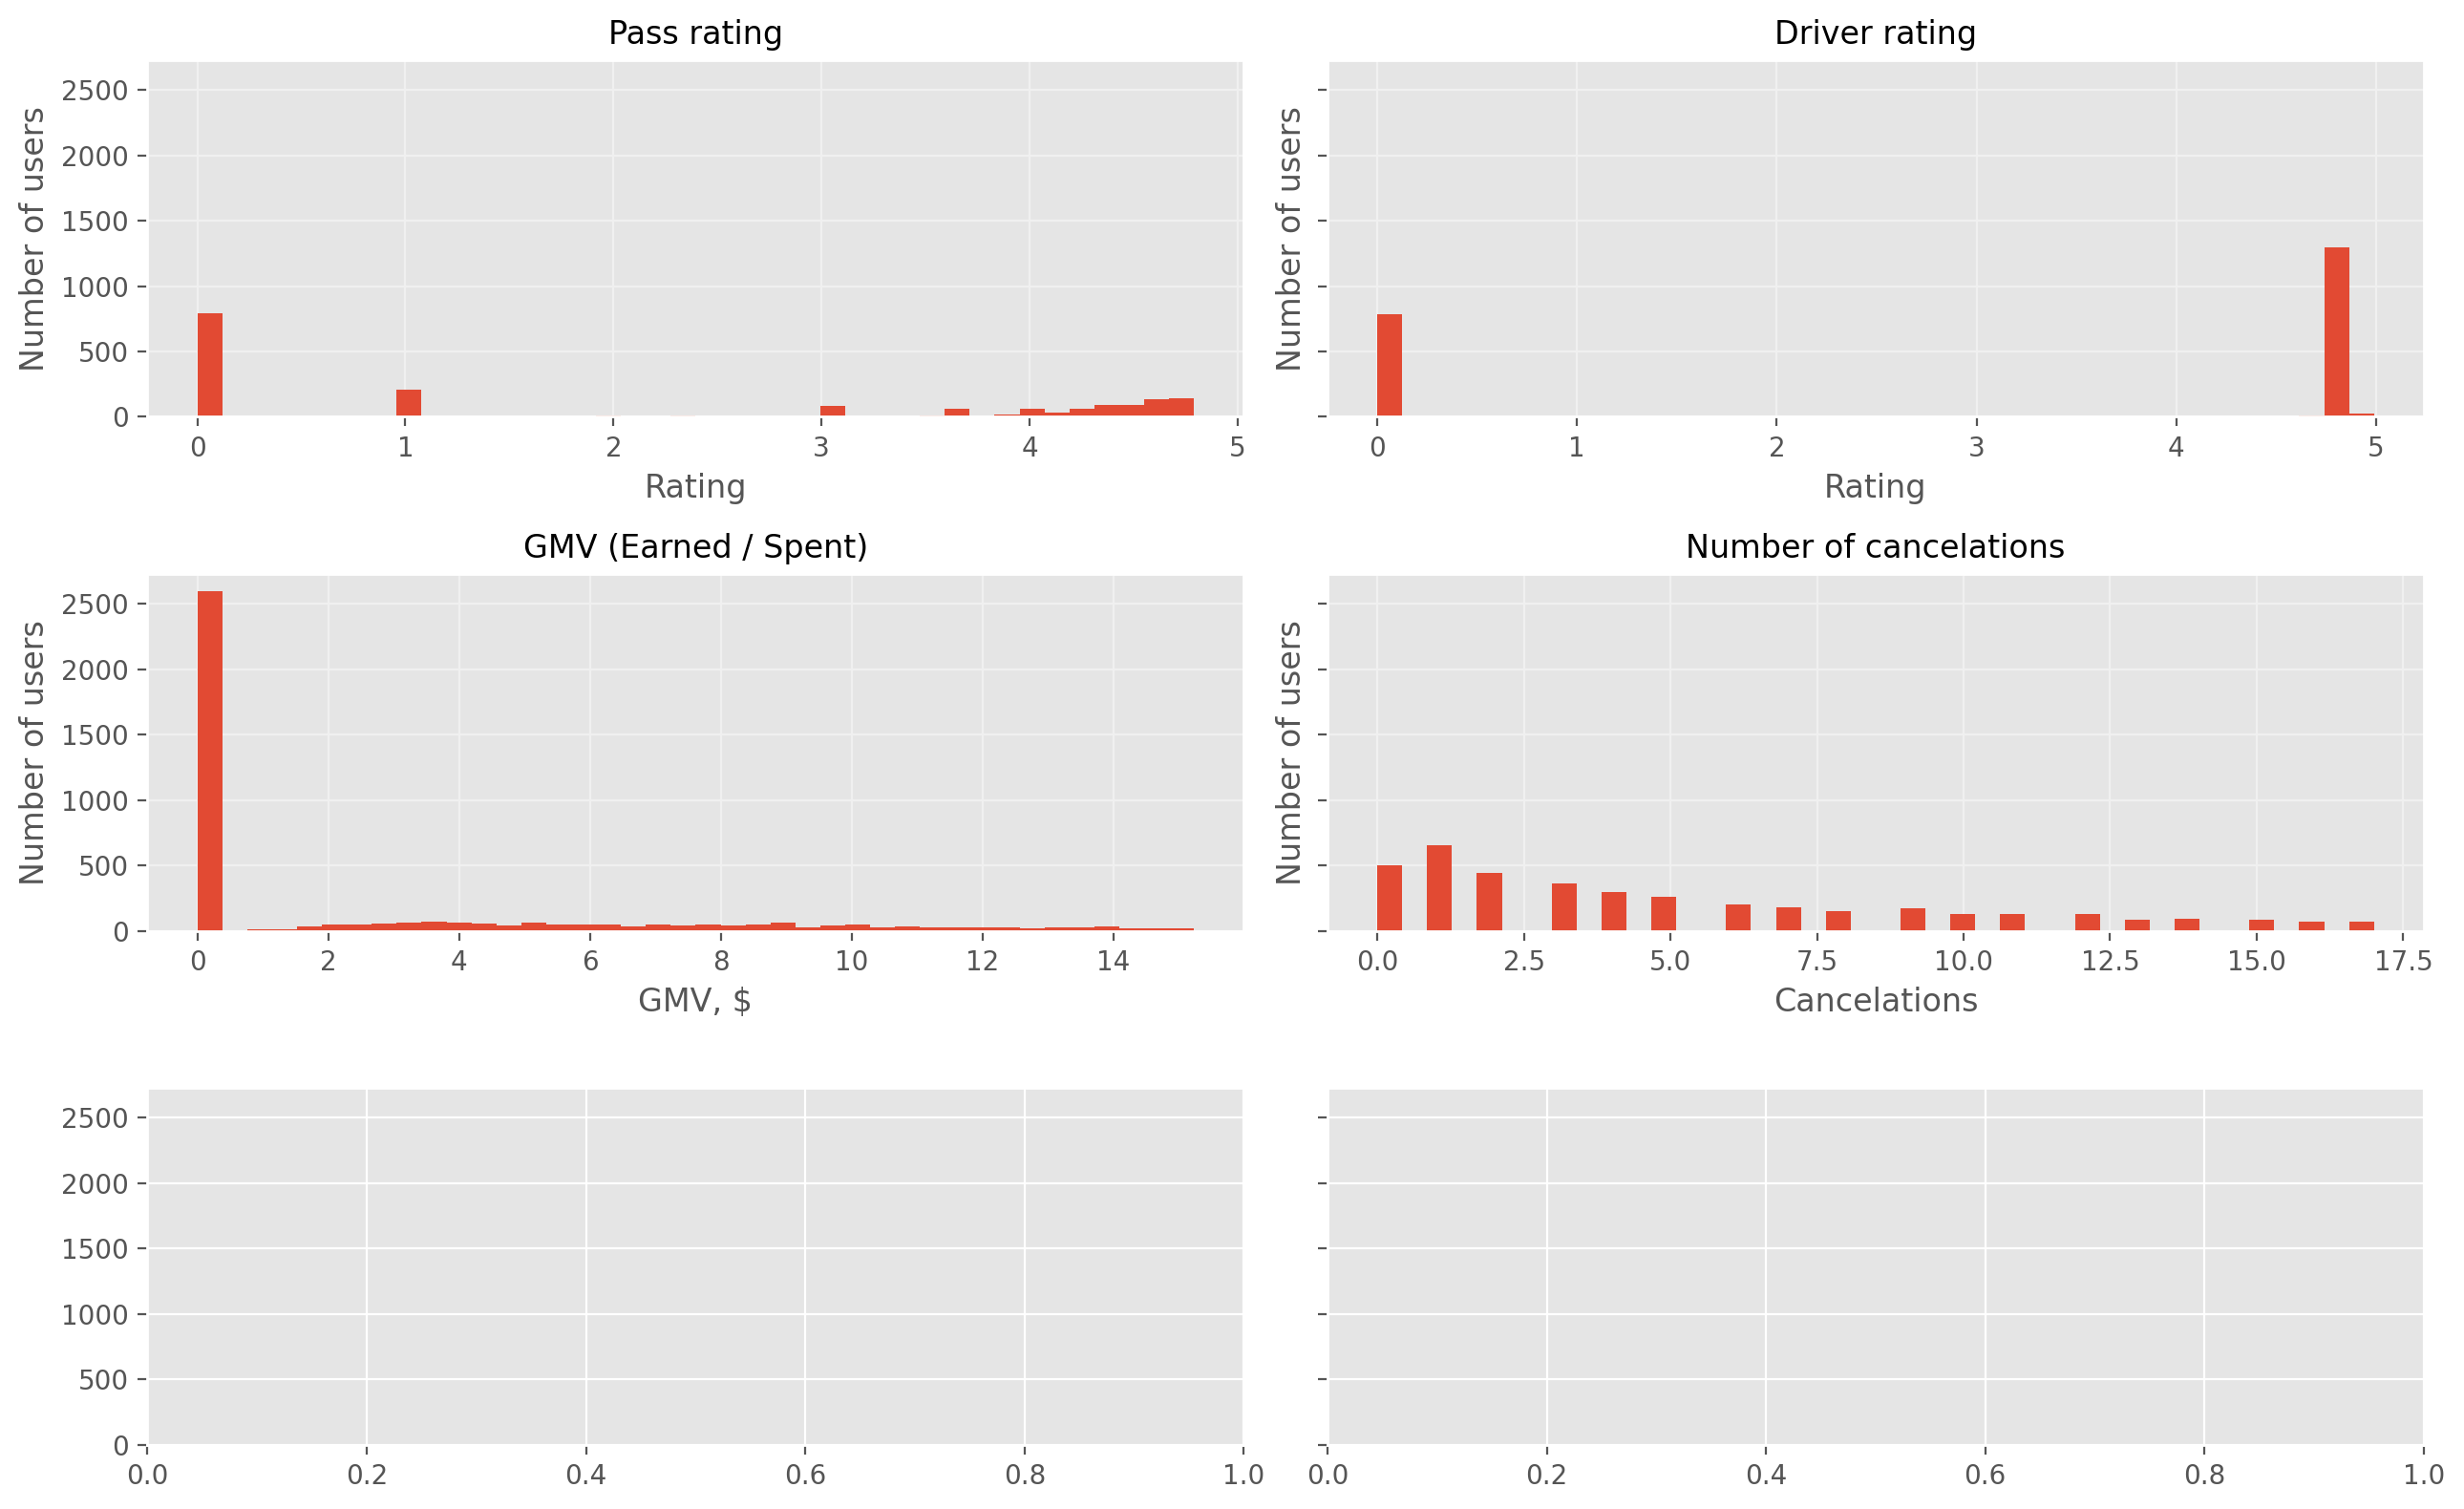

In [40]:
n_bins = 40
fs = 12
metrics = ['customer_rating', 'contractor_rating', 'gmv_clean_usd', 'canceled_orders_count']
percentile = 70

customer_rating = df_total[df_total['customer_rating'] < np.percentile(df_total['customer_rating'], percentile)]['customer_rating']
contractor_rating = df_total[df_total['contractor_rating'] < np.percentile(df_total['contractor_rating'], percentile)]['contractor_rating']
gmv = df_total[df_total['gmv_clean_usd'] < np.percentile(df_total['gmv_clean_usd'], percentile)]['gmv_clean_usd']
canceled_orders = df_total[df_total['canceled_orders_count'] < np.percentile(df_total['canceled_orders_count'], percentile)]['canceled_orders_count']

fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True, figsize=(13,8))

axs[0, 0].hist(customer_rating, bins=n_bins)
axs[0, 0].set_xlabel('Rating',fontsize=fs)
axs[0, 0].set_ylabel('Number of users',fontsize=fs)
axs[0, 0].set_title('Pass rating',fontsize=fs)
axs[0, 0].grid(visible=True,color="#f0f0f0",axis='both')
axs[0, 0].set_axisbelow(True)

axs[0, 1].hist(contractor_rating, bins=n_bins)
axs[0, 1].set_xlabel('Rating',fontsize=fs)
axs[0, 1].set_ylabel('Number of users',fontsize=fs)
axs[0, 1].set_title('Driver rating',fontsize=fs)
axs[0, 1].grid(visible=True,color="#f0f0f0",axis='both')
axs[0, 1].set_axisbelow(True)

axs[1, 0].hist(gmv, bins=n_bins)
axs[1, 0].set_xlabel('GMV, $',fontsize=fs)
axs[1, 0].set_ylabel('Number of users',fontsize=fs)
axs[1, 0].set_title('GMV (Earned / Spent)',fontsize=fs)
axs[1, 0].grid(visible=True,color="#f0f0f0",axis='both')
axs[1, 0].set_axisbelow(True)

axs[1, 1].hist(canceled_orders, bins=n_bins)
axs[1, 1].set_xlabel('Cancelations',fontsize=fs)
axs[1, 1].set_ylabel('Number of users',fontsize=fs)
axs[1, 1].set_title('Number of cancelations',fontsize=fs)
axs[1, 1].grid(visible=True,color="#f0f0f0",axis='both')
axs[1, 1].set_axisbelow(True)

# axs[2, 0].hist(canceled_orders, bins=n_bins)
# axs[2, 0].set_xlabel('Cancelations',fontsize=fs)
# axs[2, 0].set_ylabel('Number of users',fontsize=fs)
# axs[2, 0].set_title('Number of cancelations',fontsize=fs)
# axs[2, 0].grid(visible=True,color="#f0f0f0",axis='both')
# axs[2, 0].set_axisbelow(True)

# axs[2, 1].hist(canceled_orders, bins=n_bins)
# axs[2, 1].set_xlabel('Cancelations',fontsize=fs)
# axs[2, 1].set_ylabel('Number of users',fontsize=fs)
# axs[2, 1].set_title('Number of cancelations',fontsize=fs)
# axs[2, 1].grid(visible=True,color="#f0f0f0",axis='both')
# axs[2, 1].set_axisbelow(True)

plt.show()

In [41]:
df_unbanned_users = df_unbanned_users[(df_unbanned_users['gmv_clean_usd'] < np.percentile(df_unbanned_users['gmv_clean_usd'], 98)) & (df_unbanned_users['canceled_orders_count'] < np.percentile(df_unbanned_users['canceled_orders_count'], 98))].copy()

In [44]:
df_unbanned_users

,user_id,country_id,country_name,mode,lifetime,os,birthday,gender,customer_rating,contractor_rating,device_change,avatar_change,nickname_change,rides_count,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count,level
0,173256428,11,Brazil,client,741,android,0,0,5.00,5.00,1,0,0,93,335.70,145,31,Yellow
1,54253895,11,Brazil,client,1727,ios,48,0,4.71,5.00,2,0,0,8,35.29,14,6,Yellow
2,265706719,11,Brazil,client,179,android,0,0,1.00,5.00,0,0,0,4,35.84,6,3,Yellow
3,268872798,11,Brazil,client,160,android,0,0,5.00,5.00,1,0,0,3,8.90,12,5,Yellow
6,204165391,11,Brazil,client,547,ios,0,0,4.73,5.00,3,0,0,221,421.26,125,69,Yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,256350136,11,Brazil,client,235,android,0,0,5.00,5.00,0,1,1,5,22.98,62,5,Red
921,263761194,11,Brazil,client,191,android,0,0,4.33,5.00,0,0,0,8,38.15,15,9,Red
922,234335984,11,Brazil,client,358,android,0,0,4.67,5.00,2,0,1,18,108.99,34,9,Red
924,261569715,11,Brazil,client,204,android,0,0,4.67,5.00,1,0,0,27,72.35,26,14,Red


In [42]:
df_unbanned_users.describe()

,user_id,country_id,lifetime,birthday,gender,customer_rating,contractor_rating,device_change,avatar_change,nickname_change,rides_count,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count
count,"2,861.00","2,861.00","2,857.00","2,861.00","2,857.00","2,861.00","2,861.00","2,861.00","2,861.00","2,861.00","2,861.00","2,861.00","2,861.00","2,861.00"
mean,"220,083,831.52",11.00,477.40,3.83,0.02,4.16,4.43,0.52,0.08,0.17,9.52,37.39,20.01,5.62
std,"62,515,826.17",0.00,441.00,11.37,0.17,1.58,1.53,1.33,0.48,0.64,20.06,74.23,32.99,9.56
min,"18,539,172.00",11.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"202,491,347.00",11.00,181.00,0.00,0.00,4.56,4.80,0.00,0.00,0.00,0.00,0.00,2.00,0.00
50%,"234,745,583.00",11.00,355.00,0.00,0.00,4.80,5.00,0.00,0.00,0.00,2.00,8.27,7.00,2.00
75%,"265,477,960.00",11.00,558.00,0.00,0.00,5.00,5.00,1.00,0.00,0.00,9.00,35.92,23.00,7.00
max,"295,144,668.00",11.00,"2,248.00",77.00,2.00,5.00,5.00,31.00,12.00,14.00,221.00,552.50,259.00,122.00


In [43]:
metrics = ['gmv_clean_usd', 'rides_count']

for metric in metrics:
    
    fig = px.bar(
    df_unbanned_users.groupby(['os', 'level'], as_index=False)[['gmv_clean_usd', 'rides_count']].agg('sum').round(2), 
    x='level', 
    y=metric, 
    color='os',
    text = metric,
    title = metric
    )
    fig.show()

In [ ]:
df_unbanned_users.groupby(['level', 'os', 'mode'], as_index=False)[[
    'user_id',
    'lifetime',
    'customer_rating',
    'device_change',
    'avatar_change',
    'nickname_change',
    'rides_count',
    'gmv_clean_usd',
    'canceled_orders_count',
    'canceled_accepted_orders_count'
    ]].agg(
        {
            'user_id':'count',
            'lifetime':'mean',
            'customer_rating':'mean',
            'device_change':'mean',
            'avatar_change':'mean',
            'nickname_change':'mean',
            'rides_count':'mean',
            'gmv_clean_usd':'mean',
            # 'rides_count':'sum',
            # 'gmv_clean_usd':'sum',
            'canceled_orders_count':'mean',
            'canceled_accepted_orders_count':'mean'
        }
    ).query("mode == 'client'")

,level,os,mode,user_id,lifetime,customer_rating,device_change,avatar_change,nickname_change,rides_count,gmv_clean_usd,canceled_orders_count,canceled_accepted_orders_count
0,2,android,client,1467,462.26,4.07,0.48,0.09,0.18,10.19,38.71,23.67,5.55
2,2,ios,client,713,474.12,4.15,0.54,0.16,0.17,13.38,58.92,32.79,8.20
4,3,android,client,231,356.19,4.15,0.45,0.05,0.17,7.62,28.48,15.56,5.09
6,3,ios,client,52,386.52,4.01,0.50,0.02,0.13,11.48,46.60,22.08,8.38


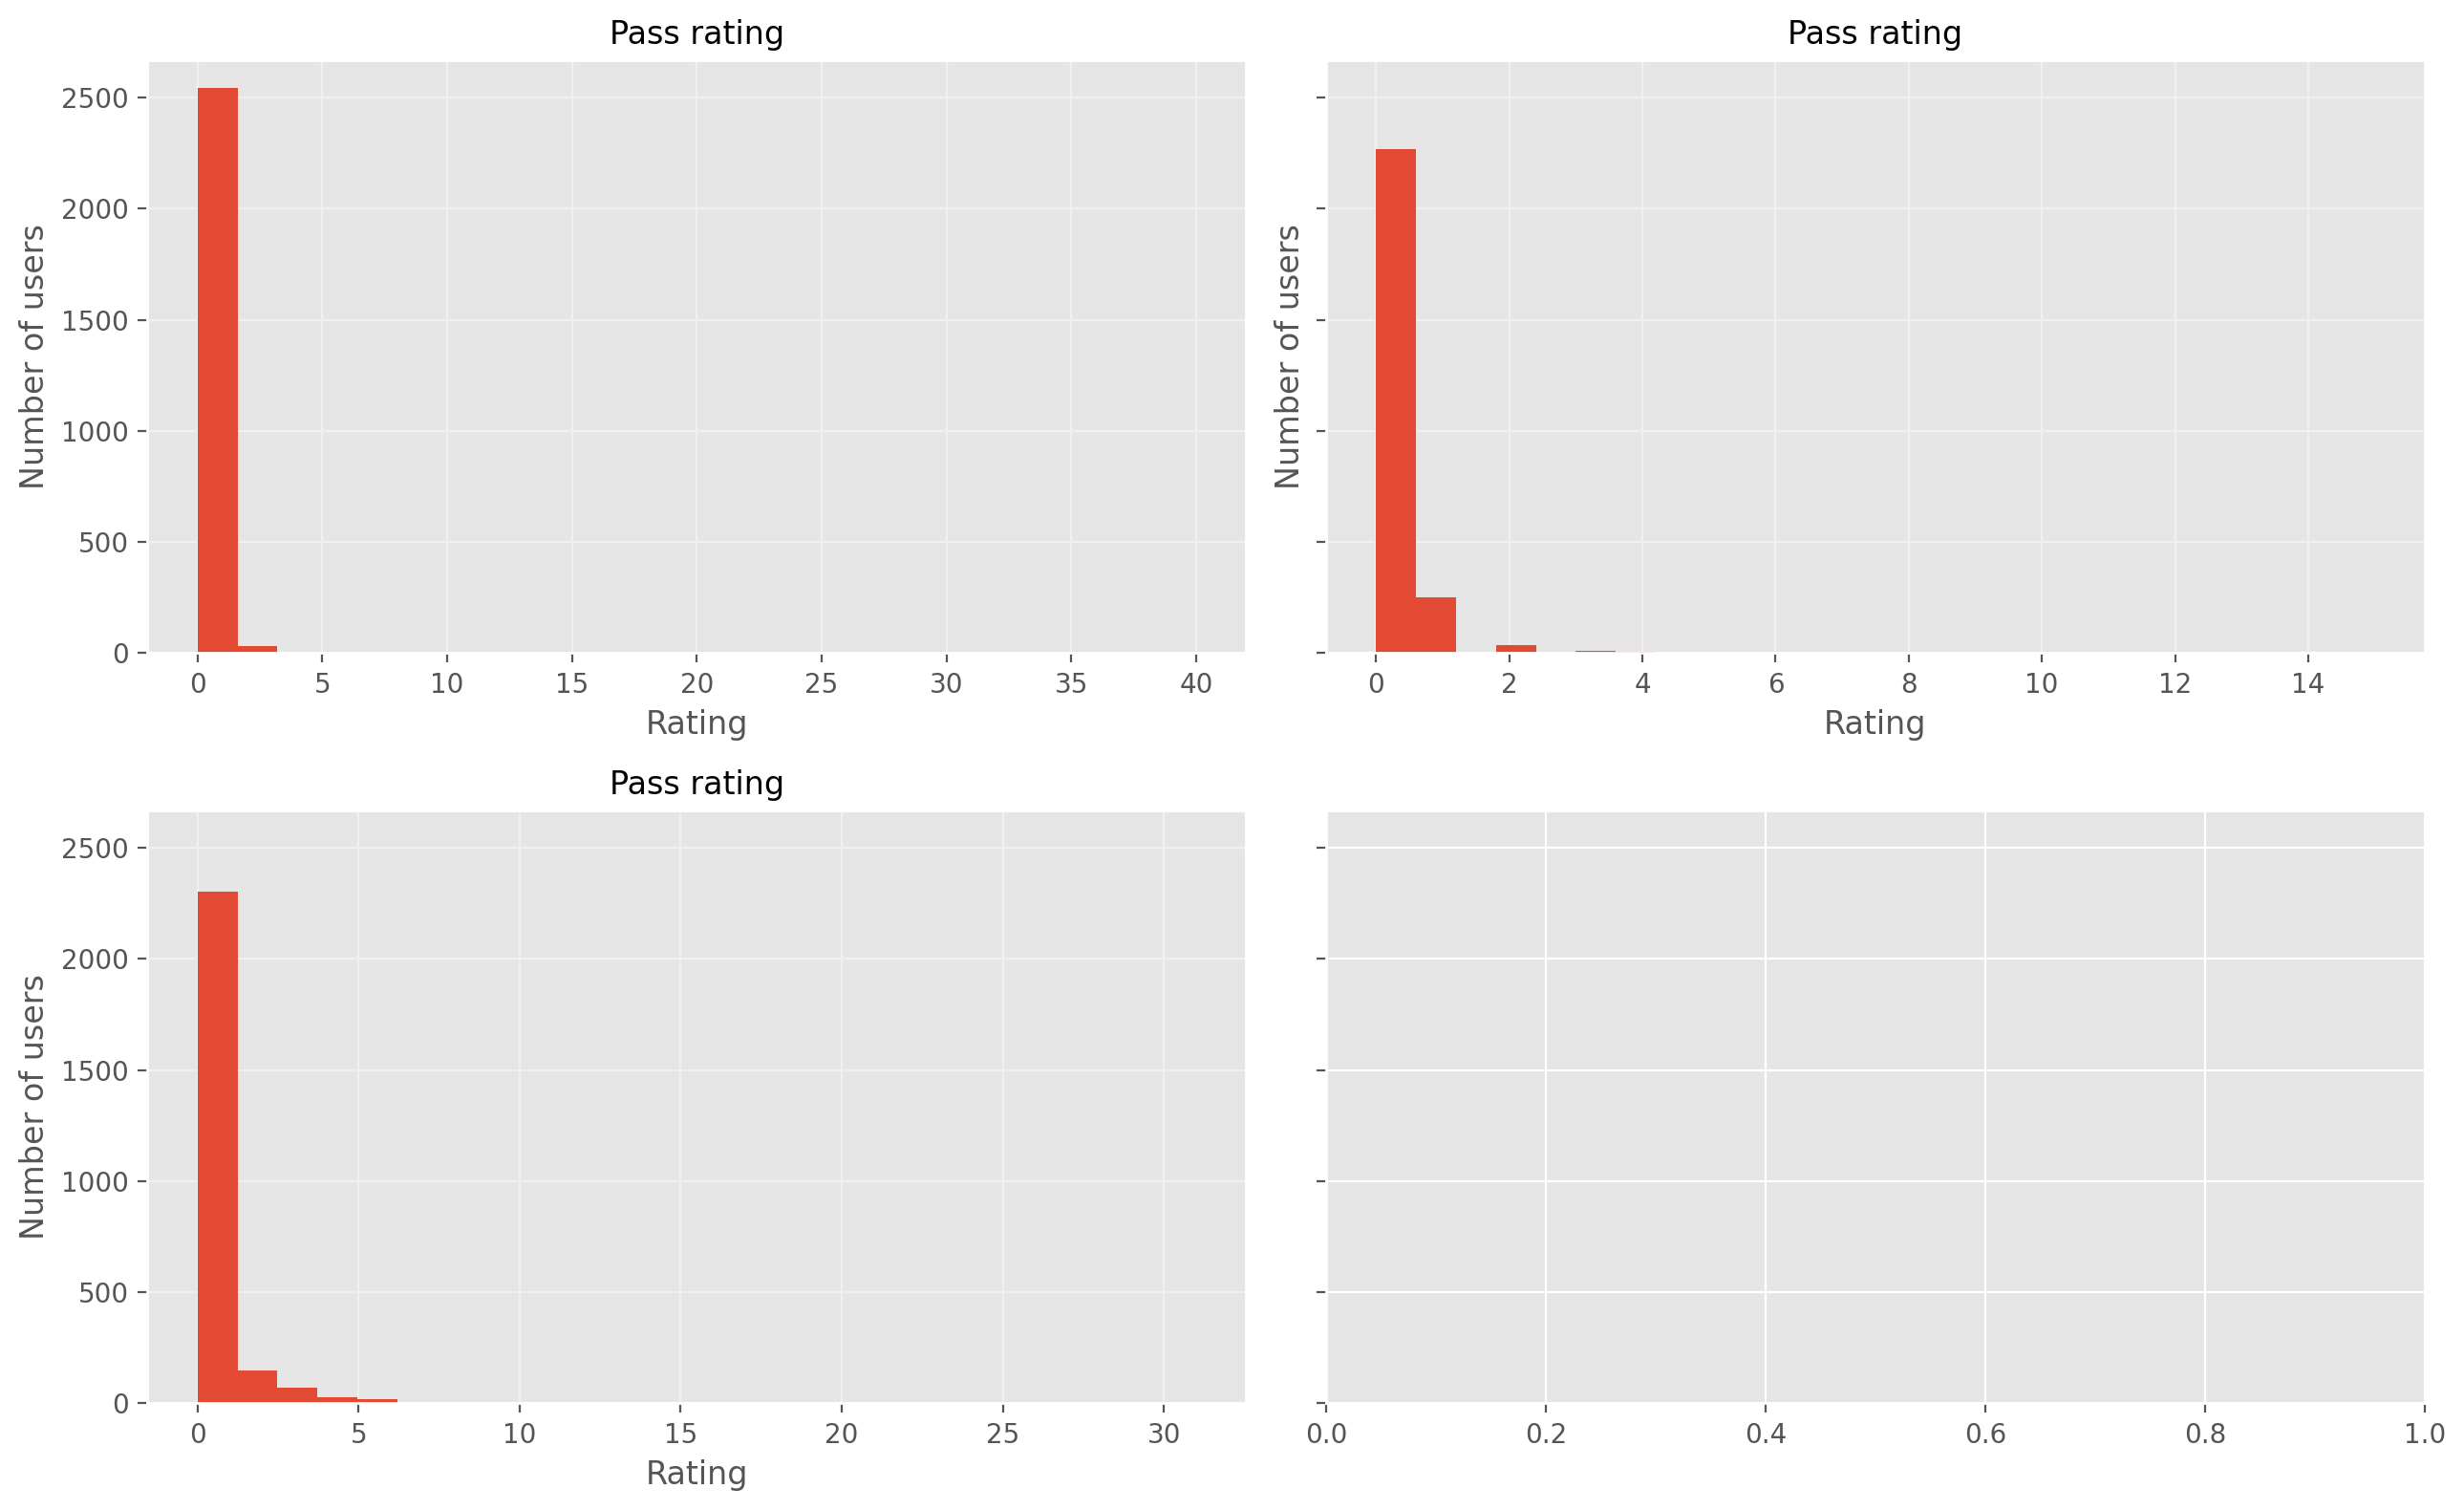

In [ ]:
avatar = df_unbanned_users['avatar_change']
nickname = df_unbanned_users['nickname_change']
device = df_unbanned_users['device_change']

n_bins = 25

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(13,8))

axs[0, 0].hist(avatar, bins=n_bins)
axs[0, 0].set_xlabel('Rating',fontsize=fs)
axs[0, 0].set_ylabel('Number of users',fontsize=fs)
axs[0, 0].set_title('Pass rating',fontsize=fs)
axs[0, 0].grid(visible=True,color="#f0f0f0",axis='both')
axs[0, 0].set_axisbelow(True)

axs[0, 1].hist(nickname, bins=n_bins)
axs[0, 1].set_xlabel('Rating',fontsize=fs)
axs[0, 1].set_ylabel('Number of users',fontsize=fs)
axs[0, 1].set_title('Pass rating',fontsize=fs)
axs[0, 1].grid(visible=True,color="#f0f0f0",axis='both')
axs[0, 1].set_axisbelow(True)

axs[1, 0].hist(device, bins=n_bins)
axs[1, 0].set_xlabel('Rating',fontsize=fs)
axs[1, 0].set_ylabel('Number of users',fontsize=fs)
axs[1, 0].set_title('Pass rating',fontsize=fs)
axs[1, 0].grid(visible=True,color="#f0f0f0",axis='both')
axs[1, 0].set_axisbelow(True)

In [473]:
df_complaints = read_bq(f"""
SELECT CAST(`indriver-e6e40.de_functions.convert_uuid_to_id`(target_uuid) AS INT) AS user_id,
       text,
       vertical_name,
       initiator,
       created_at
FROM dwh-storage-327422.ods_review.appeal
WHERE initiator = 'contractor'
  AND deleted_at IS NULL
  AND CAST(`indriver-e6e40.de_functions.convert_uuid_to_id`(target_uuid) AS INT) IN {tuple(df_unbanned_users['user_id'].to_list())}
""")

In [447]:
print(740 / 1962 * 100)
print(112 / 497 * 100)

37.71661569826708
22.535211267605636


In [474]:
from sklearn.feature_extraction.text import CountVectorizer

basic_stopwords = [
    'a', 'o', 'e', 'é', 'de', 'do', 'da', 'dos', 'das', 'um', 'uma', 'uns', 'umas',
    'para', 'com', 'não', 'sim', 'mais', 'mas', 'ou', 'por', 'em', 'me', 'foi', 'que',
    'no', 'na', 'nos', 'nas', 'se', 'ao', 'aos', 'como', 'são', 'isso', 'essa', 'esse',
    'este', 'esta', 'estes', 'estas', 'eu', 'ele', 'ela', 'eles', 'elas', 'você', 'vocês'
]

def keyword_counter(df, level_col='level', text_col='text', stopwords=basic_stopwords, top_n=15, vocab_top_n=30):
    levels = df[level_col].unique()
    result = {}
    top_keywords_dict = {}

    for lvl in levels:
        texts = df[df[level_col] == lvl][text_col].dropna()
        vectorizer = CountVectorizer(stop_words=stopwords)
        X = vectorizer.fit_transform(texts)
        word_counts = X.toarray().sum(axis=0)
        keywords = vectorizer.get_feature_names_out()
        
        counts_df = pd.DataFrame({
            'Keyword': keywords,
            'Count': word_counts
        }).sort_values(by='Count', ascending=False)

        result[lvl] = counts_df.head(top_n)
        top_keywords_dict[lvl] = counts_df.head(vocab_top_n)['Keyword'].tolist()

    return result, top_keywords_dict

df_complaints.merge(df_unbanned_users, left_on='user_id', right_on='user_id', how='inner')[['user_id', 'text', 'level']]
keyword_counts = keyword_counter(df_complaints.merge(df_unbanned_users, left_on='user_id', right_on='user_id', how='inner')[['user_id', 'text', 'level']])
# for level, df_keywords in keyword_counts.items():
#     print(f"\nTop - {level}:")
#     print(df_keywords)

In [475]:
keyword_counts[1].get('Red')

In [484]:
df_texts_complaints = df_complaints.merge(df_unbanned_users, left_on='user_id', right_on='user_id', how='inner')[['user_id', 'text', 'level', 'created_at']]

In [499]:
import pandas as pd
from deep_translator import GoogleTranslator
import time


def translate_text(text):
    try:

        return GoogleTranslator(source='auto', target='ru').translate(text)
    except Exception as e:
        print(f"Ошибка при переводе: {e}")
        return None


translated_texts = []
for t in tqdm(df_texts_complaints['text']):
    translated = translate_text(t)
    translated_texts.append(translated)
    time.sleep(0.5)

df_texts_complaints['text_ru'] = translated_texts


  0%|          | 0/543 [00:00<?, ?it/s]

In [501]:
df_texts_complaints.to_csv('translated.csv')

# Preparing for the marking

In [34]:
df_check = read_bq("""
WITH photos AS (SELECT user_id,
                       photo_uuid
                FROM indriver-e6e40.ods_facechecker.user_liveness
                WHERE created_at >= '2010-01-01'
                  AND photo_uuid IS NOT NULL
                QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY created_at DESC) = 1),
     pictures AS (SELECT *
                  FROM dwh-storage-327422.facechecker.user_photo
                  WHERE path IS NOT NULL
                    AND path != ''),
     connections AS (SELECT id,
                            user_id_from,
                            user_id_to,
                            connection_type,
                            confidence_level,
                            CASE
                                WHEN confidence_level BETWEEN 0.97 AND 0.98 THEN '97%-98%'
                                WHEN confidence_level BETWEEN 0.981 AND 0.99 THEN '98%-99%'
                                WHEN confidence_level BETWEEN 0.991 AND 0.995 THEN '99%-99.5%'
                                WHEN confidence_level BETWEEN 0.996 AND 1 THEN '99.5%-99.9%'
                                ELSE '<97%'
                                END segment
                     FROM indriver-e6e40.ods_user_connections.user_connections
                     WHERE connection_type = 'liveness')
SELECT t1.*,
       t2.photo_uuid AS photo_uuid_id_from,
       t4.path       AS path_pic_id_from,
       t3.photo_uuid AS photo_uuid_id_to,
       t5.path       AS path_pic_id_to
FROM connections t1
         LEFT JOIN photos t2 ON t1.user_id_from = t2.user_id
         LEFT JOIN photos t3 ON t1.user_id_to = t3.user_id
         LEFT JOIN pictures t4 ON t1.user_id_from = t4.user_id
         LEFT JOIN pictures t5 ON t1.user_id_to = t5.user_id
                   """)

df_check.head()

,id,user_id_from,user_id_to,connection_type,confidence_level,segment,photo_uuid_id_from,path_pic_id_from,photo_uuid_id_to,path_pic_id_to
0,01958c1a-83d0-7a6d-956f-53c74dcb8886,116032914,152919115,liveness,0.94,<97%,None,https://indriver.com/upload/facecheck/2022-12-...,None,https://indriver.com/upload/facecheck/2022-12-...
1,01958c66-1ac0-7b3e-8a28-e42e8ebea69b,128814871,196732714,liveness,0.96,<97%,None,https://indriver.com/upload/facecheck/2022-07-...,f4237c44-9e22-4d72-9dc8-be842dc0bbac,None
2,01957302-537d-76c0-b538-19305267131c,146264226,265075054,liveness,0.96,<97%,None,https://indriver.com/upload/facecheck/2022-10-...,0194a58a-e4ae-73ee-ad59-300f506480c5,None
3,01956273-0007-7130-a83c-2328cc3bd9f2,25464025,201657757,liveness,0.91,<97%,None,https://indriver.com/upload/facecheck/2021-10-...,ccafb3ed-3b2c-47b5-b95e-f352ab8118fc,None
4,01956367-2cab-7fdf-a1d6-2bdea0b08061,100329141,121830315,liveness,0.94,<97%,None,https://indriver.com/upload/facecheck/2021-11-...,948955e1-f3e4-4de3-9787-7c20c483b176,None


In [37]:
df_check[df_check['segment']!='<97%'].loc[random.sample(set(df_check[df_check['segment']!='<97%'].index), 3500)].to_csv('liveness_sample_connections.csv')

In [588]:
df = pd.read_excel('/Users/renatyunison/Desktop/VSC scripts/faces - Sheet1.xlsx')
df.head()

,id_image1,id_image2,annotator_1,Unnamed: 3,annotator_2,Unnamed: 5,annotator_3,Unnamed: 7
0,281585720_0195134d-c51c-796e-83f7-66e6201c1b06...,281590696_0195134d-c51c-796e-83f7-66e6201c1b06...,1.00,NaN,1.00,NaN,1.00,NaN
1,193072386_01951e1a-85fb-71eb-a62d-af5ad5951d34...,198214931_01951e1a-85fb-71eb-a62d-af5ad5951d34...,1.00,NaN,1.00,NaN,1.00,NaN
2,105418674_01951eb0-1309-7a9e-8044-79361e2b6694...,110937232_01951eb0-1309-7a9e-8044-79361e2b6694...,1.00,NaN,1.00,NaN,1.00,NaN
3,105295165_01951eb1-05d7-7201-bbfd-d22864e78bea...,111619702_01951eb1-05d7-7201-bbfd-d22864e78bea...,1.00,NaN,1.00,NaN,1.00,NaN
4,112056564_01951eb1-9bed-7a9e-9de6-721f4c46eb59...,259688339_01951eb1-9bed-7a9e-9de6-721f4c46eb59...,1.00,NaN,1.00,NaN,1.00,NaN


In [594]:
df.groupby(['Unnamed: 3', 'Unnamed: 5',	'Unnamed: 7'],as_index=False)['id_image1'].count()

,Unnamed: 3,Unnamed: 5,Unnamed: 7,id_image1
0,liveness,liveness,liveness,59
1,liveness,uncertain,uncertain,1
2,uncertain,uncertain,uncertain,10


In [601]:
df.groupby(['annotator_1', 'annotator_2', 'annotator_3'],as_index=False)['id_image1'].count()

,annotator_1,annotator_2,annotator_3,id_image1
0,0.00,0.00,0.00,26
1,0.00,0.00,1.00,8
2,0.00,1.00,0.00,10
3,0.00,1.00,1.00,64
4,1.00,0.00,0.00,18
5,1.00,0.00,1.00,69
6,1.00,1.00,0.00,41
7,1.00,1.00,1.00,3109


In [600]:
print((59+1)/3345*100)
print((26+8+10+18)/3345*100)
print((26+8+10+18+64+69+41)/3345*100)

1.7937219730941705
1.8535127055306428
7.055306427503736
